In [2]:
import pickle
import boris_extraction as boris
import multirecording_spikeanalysis as spike
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import sem
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import matplotlib.patches as mpatches
from itertools import combinations

def hex_2_rgb(hex_color): # Orange color
    rgb_color = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
    return rgb_color


## Behavior dict and collection creation


In [4]:

def p2_create_array(boris_df, times, order, min_iti, min_bout, baseline = False):
    familiarization_df = boris_df[(boris_df['Start (s)'] < times[0])]
    baseline_df = boris_df[(boris_df['Start (s)'] > times[1]) & (boris_df['Start (s)'] < times[2])]
    if order[0] == 'familiar':
        recall_df = boris_df[(boris_df['Start (s)'] > times[3]) & (boris_df['Start (s)'] < times[4])]
        exposure1_df = recall_df
    if order[0] == 'cagemate':
        cagemate_df = boris_df[(boris_df['Start (s)'] > times[3]) & (boris_df['Start (s)'] < times[4])]
        exposure1_df = cagemate_df
    if order[0] == 'novel':
        novel_df = boris_df[(boris_df['Start (s)'] > times[3]) & (boris_df['Start (s)'] < times[4])]
        exposure1_df = novel_df
    if order[1] == 'familiar':
        recall_df = boris_df[(boris_df['Start (s)'] > times[5]) & (boris_df['Start (s)'] < times[6])]
        exposure2_df = recall_df 
    if order[1] == 'cagemate':
        cagemate_df = boris_df[(boris_df['Start (s)'] > times[5]) & (boris_df['Start (s)'] < times[6])]
        exposure2_df = cagemate_df 
    if order[1] == 'novel':
        novel_df = boris_df[(boris_df['Start (s)'] > times[5]) & (boris_df['Start (s)'] < times[6])]
        exposure2_df = novel_df
    if order[2] == 'familiar':
        recall_df = boris_df[boris_df['Start (s)'] > times[7]]
        exposure3_df = recall_df 
    if order[2] == 'novel':
        novel_df = boris_df[boris_df['Start (s)'] > times[7]]
        exposure3_df = novel_df
    if order[2] == 'cagemate':
        cagemate_df = boris_df[boris_df['Start (s)'] > times[7]]
        exposure3_df = cagemate_df 

    acquisition_array = boris.get_behavior_bouts(familiarization_df, ['subject'], ['face sniffing', 'anogential sniffing'], min_iti, min_bout)
    recall_array = boris.get_behavior_bouts(recall_df, ['subject'], ['face sniffing', 'anogential sniffing'], min_iti, min_bout)
    cagemate_array = boris.get_behavior_bouts(cagemate_df, ['subject'], ['face sniffing', 'anogential sniffing'], min_iti, min_bout)
    novel_array = boris.get_behavior_bouts(novel_df, ['subject'], ['face sniffing', 'anogential sniffing'], min_iti, min_bout)
    exposure1_array = boris.get_behavior_bouts(exposure1_df, ['subject'], ['face sniffing', 'anogential sniffing'], min_iti, min_bout)
    exposure2_array = boris.get_behavior_bouts(exposure2_df, ['subject'], ['face sniffing', 'anogential sniffing'], min_iti, min_bout)
    exposure3_array = boris.get_behavior_bouts(exposure3_df, ['subject'], ['face sniffing', 'anogential sniffing'], min_iti, min_bout)
    
    if baseline:
        baseline_array = acquisition_array + 600000
        return [acquisition_array, recall_array, cagemate_array, novel_array, baseline_array]
    else:
        return [acquisition_array, recall_array, cagemate_array, novel_array, exposure1_array, exposure2_array, exposure3_array]

def p2_make_assignment(recording, subject, event_arrays, baseline= False):
    if baseline:
        event_dict = {'acquisition': event_arrays[0], 'recall':event_arrays[1], 'cagemate':event_arrays[2], 'novel': event_arrays[3], 'baseline':event_arrays[4]}
    else:
        event_dict = {'acquisition': event_arrays[0], 'recall':event_arrays[1], 'cagemate':event_arrays[2], 'novel': event_arrays[3], 
                      'exposure 0': event_arrays[0], 'exposure 1':event_arrays[4], 'exposure 2': event_arrays[5], 'exposure 3': event_arrays[6]}
    recording.event_dict = event_dict
    recording.subject = subject

def p2_camera_crash(boris_df1, boris_df2, times1, times2, order, media_duration, last_timestamp, min_iti, min_bout, baseline = False):
    array_1 = p2_create_array(boris_df1, times1, order, min_iti, min_bout, baseline)
    array_2 = p2_create_array(boris_df2, times2, order, min_iti, min_bout, baseline)
    diff = (last_timestamp / 20000 * 1000) - (media_duration)
    final_arrays = []
    for i in range(len(array_1)):
        array_2[i] = array_2[i] + diff
        new_array = np.concatenate([array_1[i], array_2[i]])
        final_arrays.append(new_array)
    return final_arrays
    
       
      
   

In [5]:
phase2_collection = spike.EphysRecordingCollection("D:\\social_ephys_pilot2_cum\\proc\\Phase 2")


20230803_101331_1_merged.rec
20230803_121318_1_merged.rec
20230803_141047_1_merged.rec
20230804_121600_1_merged.rec
20230804_141009_1_merged.rec
20230817_100823_1_merged.rec
20230817_113746_1_merged.rec
20230818_115728_1_merged.rec
20230818_133620_1_merged.rec
Please assign event dictionaries to each recording
as recording.event_dict
event_dict = {event name(str): np.array[[start(ms), stop(ms)]...]
Please assign subjects to each recording as recording.subject


In [6]:

FCN_1_1 = phase2_collection.get_by_name('20230803_101331_1_merged.rec')
CNF_1_1 = phase2_collection.get_by_name('20230817_100823_1_merged.rec')
NFC_1_1 = phase2_collection.get_by_name('20230818_115728_1_merged.rec')

NFC_1_2 = phase2_collection.get_by_name('20230804_141009_1_merged.rec')
FCN_1_2 = phase2_collection.get_by_name('20230817_113746_1_merged.rec')
CNF_1_2 = phase2_collection.get_by_name('20230803_141047_1_merged.rec')
                                        
FCN_1_4 = phase2_collection.get_by_name('20230804_121600_1_merged.rec')
NFC_1_4 = phase2_collection.get_by_name('20230803_121318_1_merged.rec')
CNF_1_4 = phase2_collection.get_by_name('20230818_133620_1_merged.rec')


In [7]:
#ONE VIDEO
#20230817_100823_1.1_CNF
CNF_1_1_boris_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 2\\20230817_100823_1_merged.rec\\20230817_100823_1.1_CNF.xlsx")
times_CNF_1_1 = [630, 633, 1226, 1228, 1526, 1531, 1828, 1832]
order_CNF_1_1 = ['cagemate', 'novel', 'familiar']

CNF_1_1_arrays = p2_create_array(CNF_1_1_boris_df, times_CNF_1_1, order_CNF_1_1, 2, 0.5)
p2_make_assignment(CNF_1_1, '1.1', CNF_1_1_arrays)

#TWO VIDEOS
#20230803_101331_1_FCN_1
FCN_1_1_1_boris_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 2\\20230803_101331_1_merged.rec\\20230803 101331 1.1.xlsx")
FCN_1_1_2_boris_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\Phase 2\\20230803_101331_1_merged.rec\\20230803 101331 1.2.xlsx")
times_FCN_1_1_1 = [599, 603, 821, 0, 0, 0, 0, 99999999999]
times_FCN_1_1_2 = [0, 0, 374, 377, 671, 677, 970, 976]
order_FCN_1_1 = ['familiar', 'cagemate', 'novel']
FCN_1_1_media_duration = 1290.567 * 1000
FCN_1_1_last_timestamp = FCN_1_1.timestamps_var[-1]

FCN_1_1_arrays = p2_camera_crash(FCN_1_1_1_boris_df, FCN_1_1_2_boris_df, times_FCN_1_1_1, times_FCN_1_1_2, order_FCN_1_1, FCN_1_1_media_duration, FCN_1_1_last_timestamp, 2, 0.5)
p2_make_assignment(FCN_1_1, '1.1', FCN_1_1_arrays)

#20230818_115728_1.1_NFC
NFC_1_1_1_boris_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 2\\20230818_115728_1_merged.rec\\20230818 115728 1.1.xlsx")
NFC_1_1_2_boris_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 2\\20230818_115728_1_merged.rec\\20230818 115728 1.2.xlsx")
times_NFC_1_1_1 = [111, 0, 0, 0, 0, 0, 0, 0, 99999999999]
times_NFC_1_1_2 = [527, 533, 1147, 1151, 1446, 1454, 1754, 1762]
order_NFC_1_1 = ['novel', 'familiar', 'cagemate']
NFC_1_1_media_duration = 2059.6 * 1000
NFC_1_1_last_timestamp = NFC_1_1.timestamps_var[-1]

NFC_1_1_arrays = p2_camera_crash(NFC_1_1_1_boris_df, NFC_1_1_2_boris_df, times_NFC_1_1_1, times_NFC_1_1_2, order_NFC_1_1, NFC_1_1_media_duration, NFC_1_1_last_timestamp, 2, 0.5)
p2_make_assignment(NFC_1_1, '1.1', NFC_1_1_arrays)


#20230704_141009_1.2_NFC8
NFC_1_2_boris_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 2\\20230804_141009_1_merged.rec\\20230804_141009_1.2_2t2bL_NFC.xlsx")
times_NFC_1_2 = [600, 606, 1199, 1202, 1500, 1508, 1800, 1806]
order_NFC_1_2 = ['novel', 'familiar', 'cagemate']

NFC_1_2_arrays = p2_create_array(NFC_1_2_boris_df, times_NFC_1_2, order_NFC_1_2, 2, 0.5)
p2_make_assignment(NFC_1_2, '1.2', NFC_1_2_arrays)


#20230817_113746_1.2_FCN
FCN_1_2_boris_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 2\\20230817_113746_1_merged.rec\\20230817_113746_1.2_2t2bL_FCN.xlsx")
times_FCN_1_2 = [599, 604, 1200, 1203, 1499, 1506, 1811, 1817]
order_FCN_1_2 = ['familiar', 'cagemate', 'novel']

FCN_1_2_arrays = p2_create_array(FCN_1_2_boris_df, times_FCN_1_2, order_FCN_1_2, 2, 0.5)
p2_make_assignment(FCN_1_2, '1.2', FCN_1_2_arrays)

#20230803_141047_1.2_CNF
CNF_1_2_boris_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 2\\20230803_141047_1_merged.rec\\20230803 _ 141047 _1.2 2t2bL CNF .xlsx")
times_CNF_1_2 = [600, 605, 1200, 1203, 1500, 1506, 1800, 1806]
order_CNF_1_2 = ['cagemate', 'novel', 'familiar']

CNF_1_2_arrays = p2_create_array(CNF_1_2_boris_df, times_CNF_1_2, order_CNF_1_2, 2, 0.5)
p2_make_assignment(CNF_1_2, '1.2', CNF_1_2_arrays)

#20230804_121600_1.4_FCN
FCN_1_4_boris_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 2\\20230804_121600_1_merged.rec\\20230804_121600_1.4_3t3bL_FCN.xlsx")
times_FCN_1_4 = [600, 607, 1203, 1206, 1499, 1505, 1799, 1807]
order_FCN_1_4 = ['familiar', 'cagemate', 'novel']

FCN_1_4_arrays = p2_create_array(FCN_1_4_boris_df, times_FCN_1_4, order_FCN_1_4, 2, 0.5)
p2_make_assignment(FCN_1_4, '1.4', FCN_1_4_arrays)

#20230818_133620_1.4_CNF
CNF_1_4_boris_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 2\\20230818_133620_1_merged.rec\\20230818_133620_1.4_3t3bL_CNF.xlsx")
times_CNF_1_4 = [599, 605, 1158, 1202, 1497, 1503, 1800, 1806]
order_CNF_1_4 = ['cagemate', 'familiar', 'novel']

CNF_1_4_arrays = p2_create_array(CNF_1_4_boris_df, times_CNF_1_4, order_CNF_1_4, 2, 0.5)
p2_make_assignment(CNF_1_4, '1.4', CNF_1_4_arrays)


#20230803_121318_1.4_NFC
NFC_1_4_1_boris_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 2\\20230803_121318_1_merged.rec\\20230803 121318 1.1.xlsx")
NFC_1_4_2_boris_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 2\\20230803_121318_1_merged.rec\\20230803 121318 1.2.xlsx")
times_NFC_1_4_1 = [599, 604, 1021, 0, 0, 0, 0, 99999999]
times_NFC_1_4_2 =  [0, 0, 50, 53, 347, 354, 650, 656]
order_NFC_1_4 = ['novel', 'familiar', 'cagemate']
NFC_1_4_media_duration = 951.633 * 1000
NFC_1_4_last_timestamp = NFC_1_4.timestamps_var[-1]

NFC_1_4_arrays = p2_camera_crash(NFC_1_4_1_boris_df, NFC_1_4_2_boris_df, times_NFC_1_4_1, times_NFC_1_4_2, order_NFC_1_4, NFC_1_4_media_duration, NFC_1_4_last_timestamp, 2, 0.5)
p2_make_assignment(NFC_1_4, '1.4', NFC_1_4_arrays)




In [6]:
# with open('phase2_collection.pkl','wb') as file:
#     pickle.dump(phase2_collection, file)

### Collection Load

In [3]:
with open('phase2_collection.pkl', 'rb') as file:
    phase2_collection = pickle.load(file)

## AUC plotting functions

In [8]:
# auc = phase2_analysis.trial_decoder(equalize = 5,pre_window = 5,post_window = 0,num_fold = 5,num_shuffle = 5,no_PCs =8,events=['novel', 'recall', 'cagemate'])


In [9]:
# with open('phase2_auc.pkl','wb') as file:
#     pickle.dump(auc, file)

In [10]:
with open('phase2_auc.pkl', 'rb') as file:
    auc = pickle.load(file)

In [11]:
# refined_auc = phase2_analysis.trial_decoder(5,5,post_window = 0, num_fold=5, num_shuffle=5, no_PCs=8,
#                                             events = ['novel', 'recall', 'cagemate'])
# identity_auc = phase2_analysis.trial_decoder(5,5,post_window = 0, num_fold=5, num_shuffle=5, no_PCs=8,
#                                             events = ['novel', 'recall', 'acquisition'])

In [12]:
# with open('refined_auc_phase2.pkl', 'wb') as file:
#     pickle.dump(refined_auc, file)
# with open('identity_auc_phase2.pkl','wb') as file:
#     pickle.dump(identity_auc, file)

In [13]:
with open('refined_auc_phase2.pkl', 'rb') as file:
    refined_auc = pickle.load(file)
with open('identity_auc_phase2.pkl', 'rb') as file:
    identity_auc = pickle.load(file)

In [14]:
glm = {}
glm_shuffle = {}
rf = {}
rf_shuffle = {}
for key in auc.keys():
    glm[key] = auc[key]['glm']
    rf[key] = auc[key]['rf']
    glm_shuffle_temp = []
    rf_shuffle_temp = []
    for i in range(5):
        glm_shuffle_temp.append(auc[key]['glm_shuffle'][i])
        rf_shuffle_temp.append(auc[key]['rf_shuffle'][i])
    glm_shuffle[key] = np.array(glm_shuffle_temp).reshape(25,100)
    rf_shuffle[key] = np.array(rf_shuffle_temp).reshape(25,100)
model_dict = {'Generalized Linear Model':glm, 'Random Forest Classifier':rf,
              'Generalized Linear Model\nSHUFFLED':glm_shuffle, 
              'Random Forest Classifier\nSHUFFLED':rf_shuffle}


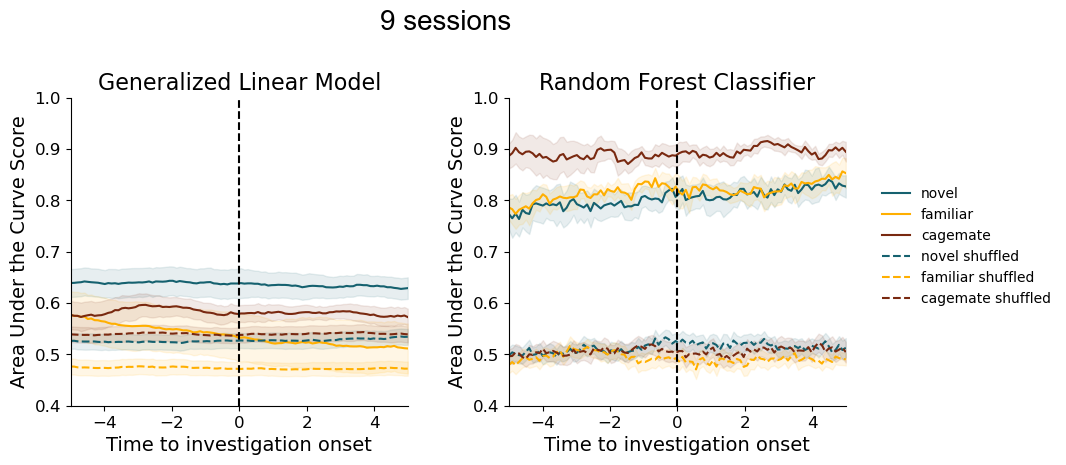

In [15]:



pre_window = 5
equalize = 5
avg_auc = {}
i = 1
alpha = 0.1
plt.figure(figsize=(10,4))
for key in ['Generalized Linear Model', 'Random Forest Classifier']:
    novel_avg = np.mean(model_dict[key]['novel'], axis = 0)
    novel_sem = sem(model_dict[key]['novel'], axis = 0)
    x =np.linspace(-pre_window, equalize, len(novel_avg))
    cagemate_avg = np.mean(model_dict[key]['cagemate'], axis = 0)
    cagemate_sem = sem(model_dict[key]['cagemate'], axis = 0)
    familiar_avg = np.mean(model_dict[key]['recall'], axis = 0)
    familiar_sem = sem(model_dict[key]['recall'], axis = 0)
    if key == 'Generalized Linear Model':
        shuffle_key = 'Generalized Linear Model\nSHUFFLED'
    else:
        shuffle_key = 'Random Forest Classifier\nSHUFFLED'
    novelshuf_avg = np.mean(model_dict[shuffle_key]['novel'], axis = 0)
    novelshuf_sem = sem(model_dict[shuffle_key]['novel'], axis = 0)
    x =np.linspace(-pre_window, equalize, len(novelshuf_avg))
    cagemateshuf_avg = np.mean(model_dict[shuffle_key]['cagemate'], axis = 0)
    cagemateshuf_sem = sem(model_dict[shuffle_key]['cagemate'], axis = 0)
    familiarshuf_avg = np.mean(model_dict[shuffle_key]['recall'], axis = 0)
    familiarshuf_sem = sem(model_dict[shuffle_key]['recall'], axis = 0)

    plt.subplot(1,2,i)
    plt.plot(x, novel_avg, label ='novel', color=hex_2_rgb('#15616F'))
    plt.fill_between(x, novel_avg-novel_sem, novel_avg+novel_sem,color=hex_2_rgb('#15616F'), alpha= alpha)
    plt.plot(x, familiar_avg, label = 'familiar', color = (1.0, 0.6862745098039216, 0.0))
    plt.fill_between(x, familiar_avg-familiar_sem, familiar_avg+familiar_sem, color = (1.0, 0.6862745098039216, 0.0), alpha = alpha)
    plt.plot(x, cagemate_avg, label = 'cagemate', color=hex_2_rgb('#792910'))
    plt.fill_between(x, cagemate_avg-cagemate_sem, cagemate_avg+cagemate_sem,color=hex_2_rgb('#792910'), alpha = alpha)
    plt.plot(x, novelshuf_avg, label ='novel shuffled',  linestyle='--', color=hex_2_rgb('#15616F'))
    plt.fill_between(x, novelshuf_avg-novelshuf_sem, novelshuf_avg+novelshuf_sem,color=hex_2_rgb('#15616F'), alpha= alpha)
    plt.plot(x, familiarshuf_avg, label = 'familiar shuffled', linestyle='--',  color = (1.0, 0.6862745098039216, 0.0))
    plt.fill_between(x, familiarshuf_avg-familiarshuf_sem, familiarshuf_avg+familiarshuf_sem, color = (1.0, 0.6862745098039216, 0.0), alpha = alpha)
    plt.plot(x, cagemateshuf_avg, label = 'cagemate shuffled',  linestyle='--', color=hex_2_rgb('#792910'))
    plt.fill_between(x, cagemateshuf_avg-cagemateshuf_sem, cagemateshuf_avg+cagemateshuf_sem, color=hex_2_rgb('#792910'), alpha = alpha)
    plt.title(f'{key}', fontsize = 16)
    plt.ylim(.4, 1)
    plt.xlim(-5,5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Time to investigation onset', fontsize=14)
    plt.ylabel('Area Under the Curve Score', fontsize=14)
    plt.axvline(x=0, color='k', linestyle='--')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    if i ==2:
        plt.legend(bbox_to_anchor = (1.07,.75), frameon=False)
    i += 1
plt.suptitle('9 sessions', fontsize = 20, font = 'Arial', y = 1.1)
plt.subplots_adjust(wspace=0.3)
plt.show()



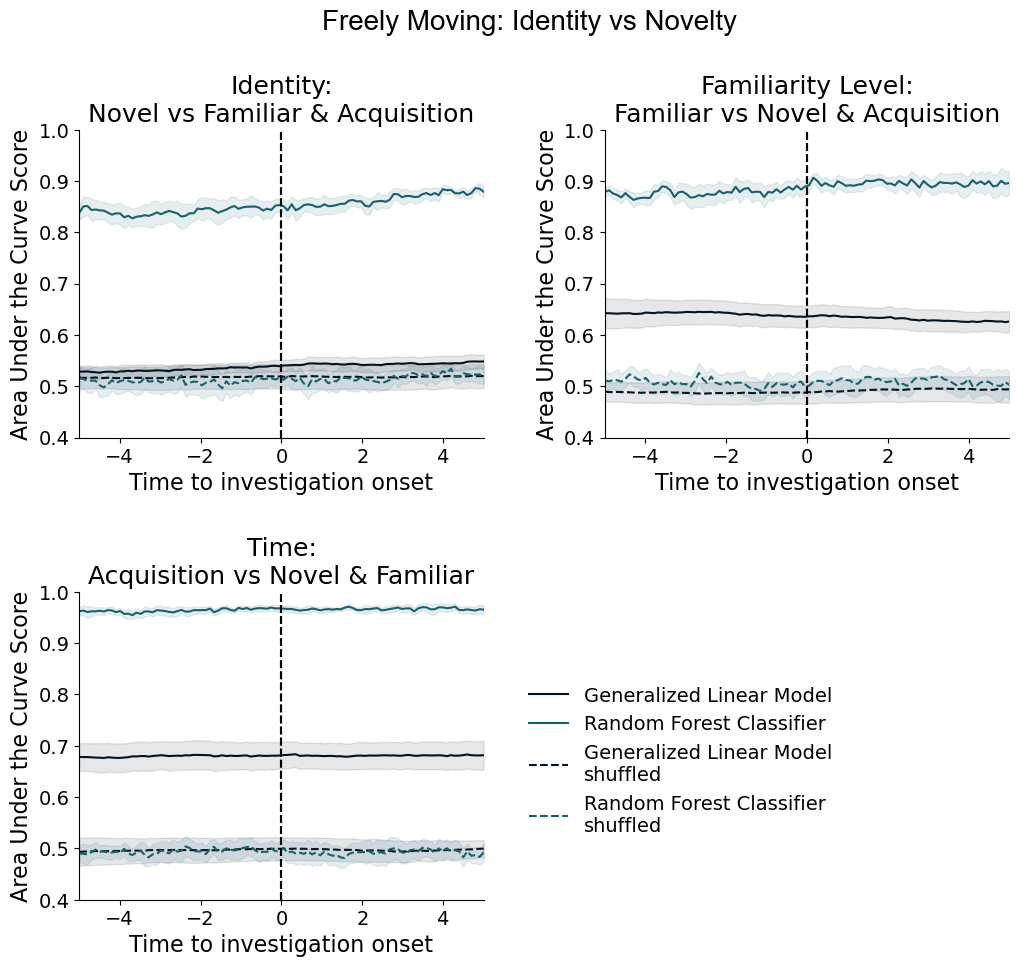

In [16]:
avg_auc = {}
no_plots = len(identity_auc.keys())
height_fig = math.ceil(no_plots/2)
i = 1
plt.figure(figsize=(12,10))
for key in identity_auc.keys():
    glm_avg = np.mean(identity_auc[key]['glm'], axis = 0)
    glm_sem = sem(identity_auc[key]['glm'], axis = 0)
    x =np.linspace(-pre_window, equalize, len(glm_avg))
    rf_avg = np.mean(identity_auc[key]['rf'], axis = 0)
    rf_sem = sem(identity_auc[key]['rf'], axis = 0)
    glm_shuffle_avg = np.mean(np.mean(identity_auc[key]['glm_shuffle'], axis = 1), axis = 0)
    glm_shuffle_sem = sem(np.mean(identity_auc[key]['glm_shuffle'], axis = 1), axis = 0)
    rf_shuffle_avg = np.mean(np.mean(identity_auc[key]['rf_shuffle'], axis = 1), axis = 0)
    rf_shuffle_sem = sem(np.mean(identity_auc[key]['rf_shuffle'], axis = 1), axis = 0)
    avg_auc[key] = [glm_avg, rf_avg, glm_shuffle_avg, rf_shuffle_avg]
    plt.subplot(2,2,i)
    plt.plot(x, glm_avg, label ='Generalized Linear Model', color = hex_2_rgb('#001424'))
    plt.fill_between(x, glm_avg-glm_sem, glm_avg+glm_sem, color = hex_2_rgb('#001424'), alpha = 0.1)
    plt.plot(x, rf_avg, label =  'Random Forest Classifier', color = hex_2_rgb('#15616F'))
    plt.fill_between(x, rf_avg-rf_sem, rf_avg+rf_sem, alpha = 0.1, color = hex_2_rgb('#15616F'))
    plt.plot(x, glm_shuffle_avg, linestyle='--', color = hex_2_rgb('#001424'), label = 'Generalized Linear Model\nshuffled')
    plt.fill_between(x, glm_shuffle_avg-glm_shuffle_sem, glm_shuffle_avg+glm_shuffle_sem, color = hex_2_rgb('#001424'), alpha = 0.1)
    plt.plot(x, rf_shuffle_avg, linestyle='--', label = 'Random Forest Classifier\nshuffled', color = hex_2_rgb('#15616F'))
    plt.fill_between(x, rf_shuffle_avg-rf_shuffle_sem, rf_shuffle_avg+rf_shuffle_sem, alpha = 0.1, color = hex_2_rgb('#15616F'))
    if key == 'recall':
        plt.title('Familiarity Level:\nFamiliar vs Novel & Acquisition', fontsize = 18)
    if key == 'novel':
        plt.title('Identity:\nNovel vs Familiar & Acquisition', fontsize = 18)
    if key == 'acquisition':
        plt.title('Time:\nAcquisition vs Novel & Familiar', fontsize = 18)
    plt.ylim(.4, 1)
    plt.axvline(x=0, color='k', linestyle='--')
    plt.xlim(-5,5)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Time to investigation onset', fontsize=16)
    plt.ylabel('Area Under the Curve Score', fontsize=16)
    plt.axvline(x=0, color='k', linestyle='--')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    if i ==3:
        plt.legend(bbox_to_anchor = (1.07,.75), frameon=False, fontsize = 14)
    i += 1
plt.suptitle('Freely Moving: Identity vs Novelty', fontsize = 20, font = 'Arial', y = 1)
plt.subplots_adjust(hspace = 0.5, wspace=0.3)
plt.show()

## PCA Analysis

All set to analyze


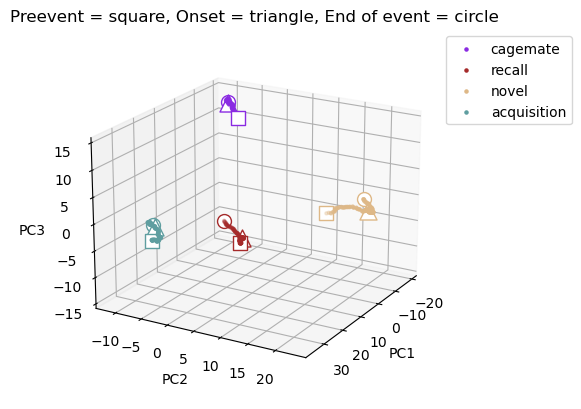

array([0.58783251, 0.21168139, 0.12948744])

In [189]:
pca_analysis = spike.SpikeAnalysis_MultiRecording(phase2_collection, 100,50,0.5)
pca_df, coeff, var = pca_analysis.PCA_trajectories(2, 2, d = 3, events = ['cagemate', 'recall', 'novel', 'acquisition'])
geo_dis = pca_analysis.LOO_PCA(2, 2, 0.9, events = ['acquisition', 'recall', 'cagemate', 'novel'])
var[0:3]


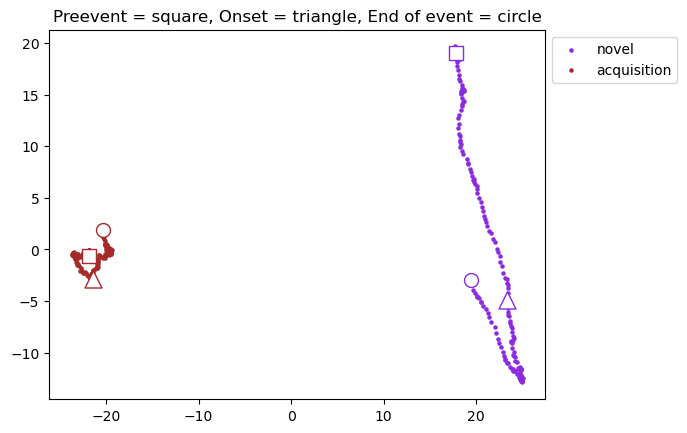

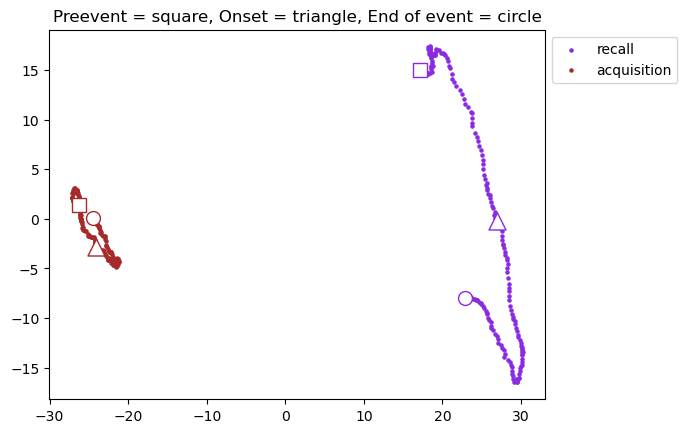

In [18]:
pca_df, coeff, var = pca_analysis.PCA_trajectories(5, 5, d = 2, events = ['novel', 'acquisition'])

pca_df, coeff, var = pca_analysis.PCA_trajectories(5, 5, d = 2, events = ['recall', 'acquisition'])

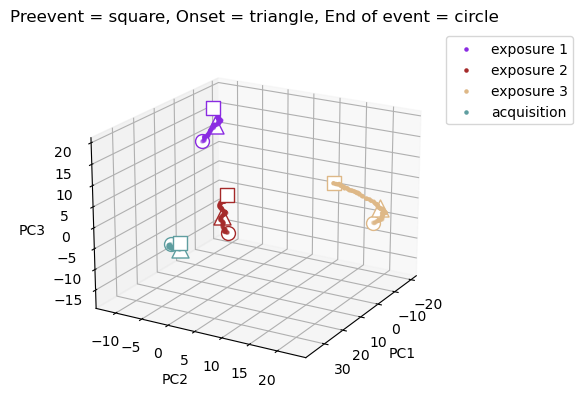

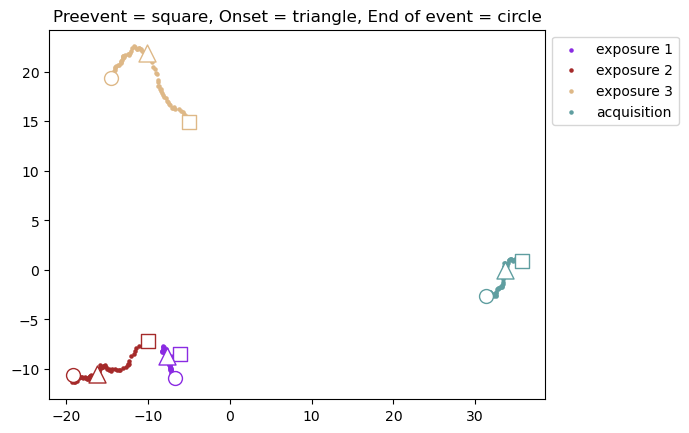

In [19]:
pca_df, coeff, var = pca_analysis.PCA_trajectories(2, 2, d = 3, events = ['exposure 1', 'exposure 2', 'exposure 3', 'acquisition'])
pca_df, coeff, var = pca_analysis.PCA_trajectories(2, 2, events = ['exposure 1', 'exposure 2', 'exposure 3', 'acquisition'])
order_distances = pca_analysis.avg_geo_dist(2, 2, .9, post_window = 0, events =['exposure 1', 'exposure 2', 'exposure 3', 'acquisition'])


### PCA Plotting function

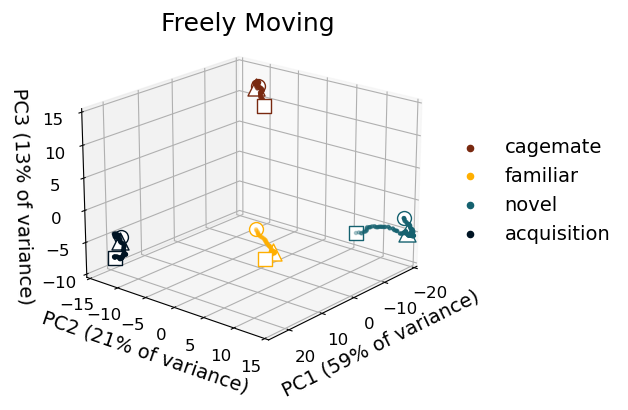

In [191]:

PCA_matrix = pca_df
PCA_key = ['cagemate', 'familiar', 'novel', 'acquisition']
equalize = 2
pre_window =2
post_window = 0
azim=45
elev=20
timebin = 50


event_lengths = int(
            (equalize + pre_window + post_window) * 1000 / timebin
        )
event_end = int((equalize + pre_window) * 1000 / timebin)
pre_window = pre_window * 1000 / timebin
post_window = post_window * 1000 / timebin
colors = [hex_2_rgb('#792910'),  (1.0, 0.6862745098039216, 0.0), hex_2_rgb('#15616F'), hex_2_rgb('#001424')]
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
counter = 0 
for i in range(0, len(PCA_key)*event_lengths, event_lengths):
    event_label = PCA_key[counter]
    onset = int(i + pre_window - 1)
    end = int(i + event_end - 1)
    post = int(i + event_lengths - 1)
    ax.scatter(
        PCA_matrix[i : i + event_lengths, 0],
        PCA_matrix[i : i + event_lengths, 1],
        PCA_matrix[i : i + event_lengths, 2],
        label=event_label,
        s=5,
        color=colors[counter],
    )
    ax.scatter(
        PCA_matrix[i, 0],
        PCA_matrix[i, 1],
        PCA_matrix[i, 2],
        marker="s",
        s=100,
        color="w",
        edgecolors=colors[counter],
    )
    ax.scatter(
        PCA_matrix[onset, 0],
        PCA_matrix[onset, 1],
        PCA_matrix[onset, 2],
        marker="^",
        s=150,
        color="w",
        edgecolors=colors[counter],
    )
    ax.scatter(
        PCA_matrix[end, 0],
        PCA_matrix[end, 1],
        PCA_matrix[end, 2],
        marker="o",
        s=100,
        color="w",
        edgecolors=colors[counter],
    )
    counter += 1
ax.legend(loc="upper left", bbox_to_anchor=(1, .70), frameon = False, fontsize = 14, markerscale = 2)
ax.set_xlabel("PC1 (59% of variance)", fontsize = 14)
ax.set_ylabel("PC2 (21% of variance)", fontsize = 14)
ax.set_zlabel("PC3 (13% of variance)", fontsize = 14)
ax.tick_params(labelsize = 12)
ax.view_init(azim = 40, elev = 20
    )
ax.set_xlim(-20, 25)
ax.set_ylim(-15, 15)
ax.set_zlim(-10, 15)
plt.title('Freely Moving', fontsize = 18, y = 1, x = .5)
plt.show()

#[0.58783251, 0.21168139, 0.12948744])

### Geodesic Distances

In [21]:
geo_dis_df = pd.DataFrame.from_dict(geo_dis)
geo_dis_df.to_excel('geo_dis_phase2.xlsx')
geo_dis_df
average_values = geo_dis_df.mean()


geo_dis_df

acquisition                            cagemate                   novel
     cagemate       novel      recall       novel      recall      recall
0  375.884211  357.236311  230.155625  172.623023  226.307953  236.994306
1  460.389401  490.922311  388.190100  132.432578  331.631801  300.088013
2  349.642508  478.740922  456.244027  160.752314  370.491585  426.777228
3  405.181052  411.875713  495.586837  124.832592  383.780994  370.900706
4  264.128957  401.331876  443.118702  167.754373  328.793801  399.840737
5  466.120834  539.080117  501.924469  169.155295  356.230055  415.412616
6  441.500034  505.044298  493.027910  187.701987  374.345625  417.175231
7  440.234118  505.523345  509.870808  214.766892  337.161290  412.022129
8  450.484043  516.969152  494.445953  206.744994  367.969560  417.056308

In [22]:

pca_analysis = spike.SpikeAnalysis_MultiRecording(phase2_collection, 100,50,0.5)
avg_geo_dis = pca_analysis.avg_geo_dist(2,2, 0.9,events = ['acquisition', 'recall', 'cagemate', 'novel'] )
avg_geo_dis_df = pd.DataFrame.from_dict(avg_geo_dis)
#acg_val = avg_geo_dis_df.mean()
#combined_index = avg_geo_dis_df.index.get_level_values("Outer") + avg_geo_dis_df.index.get_level_values("Inner")
#avg_geo_dis_df.index = combined_index
avg_geo_dis_df.columns.to_list()
avg_geo_dis_df.columns = ['acq vs cagemate', 'acq vs nov', 'acq vs recall', 'cage vs novel', 'cage vs recall', 'nov vs recall']
avg_geo_dis_df

All set to analyze


acq vs cagemate   acq vs nov  acq vs recall  cage vs novel  cage vs recall  \
0       732.555230   569.526326    1321.714668     235.885488     1584.274266   
1      1225.424808  1404.046889    1005.862706     245.260816      410.692869   
2      1417.818209  1408.412574    1265.294287     428.474030      487.719558   
3      1598.019459  1834.720219    1377.323728    1053.424018      696.051785   
4      1727.594494  1647.834214    1511.525322     408.607901      625.400548   
5      1616.527945  1486.486656    1388.847418     762.036945      495.424652   
6       688.666943   877.048341     655.538475     513.836501      423.810829   
7       970.182400   833.252257     866.394299     789.393207     1006.774167   
8      1722.461452  1038.991149    1007.058547     783.375545     1230.916795   

   nov vs recall  
0    1603.221256  
1     641.333019  
2     162.493691  
3     873.981112  
4     937.672867  
5     325.404557  
6     592.835593  
7     960.138193  
8     561.276930

In [23]:
p_values = pd.DataFrame(index=avg_geo_dis_df.columns, columns=avg_geo_dis_df.columns)
for group1 in avg_geo_dis_df.columns:
    for group2 in avg_geo_dis_df.columns:
        if group1 != group2:
            t_stat, p_value = stats.ttest_ind(avg_geo_dis_df[group1], avg_geo_dis_df[group2])
            p_values.at[group1, group2] = p_value
p_values

acq vs cagemate acq vs nov acq vs recall cage vs novel  \
acq vs cagemate             NaN   0.740024      0.401601      0.000534   
acq vs nov             0.740024        NaN      0.652329      0.001358   
acq vs recall          0.401601   0.652329           NaN      0.000528   
cage vs novel          0.000534   0.001358      0.000528           NaN   
cage vs recall         0.015751   0.032661       0.03618      0.261886   
nov vs recall          0.011739   0.024441       0.02601      0.357639   

                cage vs recall nov vs recall  
acq vs cagemate       0.015751      0.011739  
acq vs nov            0.032661      0.024441  
acq vs recall          0.03618       0.02601  
cage vs novel         0.261886      0.357639  
cage vs recall             NaN      0.866266  
nov vs recall         0.866266           NaN

### Geo plotting

All set to analyze


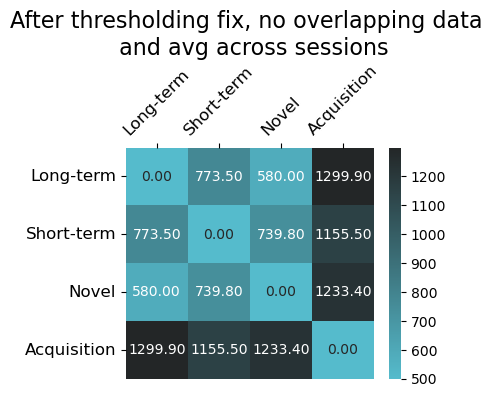

In [195]:

pca_analysis = spike.SpikeAnalysis_MultiRecording(phase2_collection, 100,50,0.5)
geo_dis_minpc1 = pca_analysis.LOO_PCA(5, 5, 0.9, events = ['acquisition', 'recall', 'cagemate', 'novel'])
geo_dis_minpc1_df = pd.DataFrame.from_dict(geo_dis_minpc1)
average_values = geo_dis_minpc1_df.mean()
average_values
data =[[0, 773.5, 580.0, 1299.9],
       [773.5, 0, 739.8, 1155.5],
       [580.0, 739.8, 0, 1233.4],
       [1299.9, 1155.5, 1233.4, 0]]


#with thresholding, LOo
# [[0, 341, 170, 405],
#         [341, 0, 377, 445],
#         [170, 377, 0, 467],
#         [405, 445, 467, 0]]
#old thresholding data, w/o first pc 
# [
#     [0, 898.674789, 520.671697,  1225.651583],
#     [898.674789, 0, 719.630639, 939.876768],
#     [520.671697, 719.630639, 0, 919.867544],
#     [1225.651583, 939.876768, 919.867544, 0]
# ]


plt.figure(figsize=(4,3))
col_pal = sns.dark_palette("#5BC", reverse=True, as_cmap=True)
heatmap = sns.heatmap(data, cmap=col_pal, annot=True, fmt = '.2f', vmin = 500)  # 'd' for integer format
heatmap.set_xticklabels(['Long-term', 'Short-term', 'Novel', 'Acquisition'], fontsize = 12, rotation = 45)
heatmap.set_yticklabels(['Long-term', 'Short-term', 'Novel', 'Acquisition'], fontsize = 12, rotation = 0)
heatmap.xaxis.set_ticks_position('top')
plt.title('After thresholding fix, no overlapping data \n and avg across sessions', fontsize = 16)
plt.show()

In [25]:
order_distances_df = pd.DataFrame.from_dict(order_distances)
avg_order_distances = order_distances_df.mean()
avg_order_distances

acquisition  exposure 1     568.587487
             exposure 2     777.229874
             exposure 3    1148.546038
exposure 1   exposure 2     747.484543
             exposure 3    1286.788861
exposure 2   exposure 3    1253.457215
dtype: float64

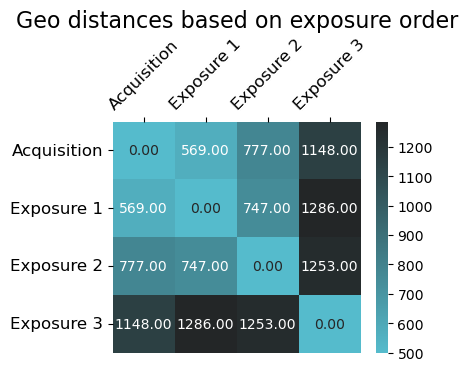

In [26]:

data = [[0, 569, 777, 1148],
        [569, 0, 747, 1286],
        [777, 747, 0 , 1253],
        [1148, 1286, 1253, 0]]
plt.figure(figsize=(4,3))
col_pal = sns.dark_palette("#5BC", reverse=True, as_cmap=True)
heatmap = sns.heatmap(data, cmap=col_pal, annot=True, fmt = '.2f', vmin = 500)  # 'd' for integer format
heatmap.set_xticklabels(['Acquisition','Exposure 1', 'Exposure 2', 'Exposure 3'], fontsize = 12, rotation = 45)
heatmap.set_yticklabels(['Acquisition','Exposure 1', 'Exposure 2', 'Exposure 3'], fontsize = 12, rotation = 0)
heatmap.xaxis.set_ticks_position('top')
plt.title('Geo distances based on exposure order', fontsize = 16)
plt.show()

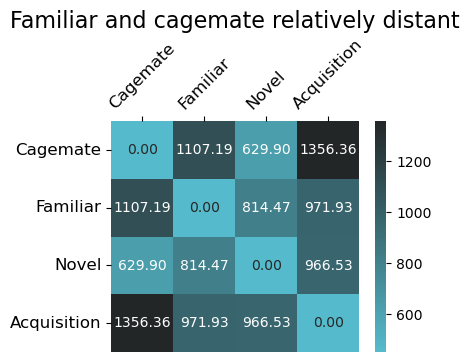

In [27]:
data = [
    [0, 1107.190208, 629.903540,  1356.359508],
    [1107.190208, 0, 814.465254, 971.933555],
    [629.903540, 814.465254, 0, 966.532550],
    [1356.359508, 971.933555, 966.532550, 0]
]


plt.figure(figsize=(4,3))
col_pal = sns.dark_palette("#5BC", reverse=True, as_cmap=True)
heatmap = sns.heatmap(data, cmap=col_pal, annot=True, fmt = '.2f', vmin = 450)  # 'd' for integer format
heatmap.set_xticklabels(['Cagemate', 'Familiar', 'Novel', 'Acquisition'], fontsize = 12, rotation = 45)
heatmap.set_yticklabels(['Cagemate', 'Familiar', 'Novel', 'Acquisition'], fontsize = 12, rotation = 0)
heatmap.xaxis.set_ticks_position('top')
plt.title('Familiar and cagemate relatively distant', fontsize = 16)
plt.show()

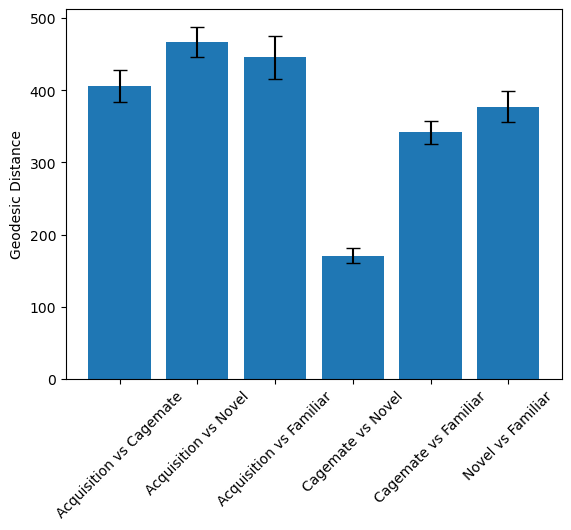

In [28]:
average_values = geo_dis_df.mean()
sems = geo_dis_df.sem()
plt.bar(['Acquisition vs Cagemate', 'Acquisition vs Novel',
         'Acquisition vs Familiar', 'Cagemate vs Novel', 'Cagemate vs Familiar',
         'Novel vs Familiar'], average_values, yerr=sems, capsize=5)

# Label the x-axis and y-axis
plt.ylabel('Geodesic Distance')
plt.xticks(rotation = 45)
# Show the plot
plt.show()


## Behavior Analysis

In [29]:
event_info = {}
is_first = True
sniff_itis = []
total_sniffs = 0
for recording_name, recording in phase2_collection.collection.items():
    for event, events in recording.event_dict.items():
        no_events = events.shape[0]
        sniff_length = 0
        for i in range(len(events)):
            #if (event == 'acquisition') and is_first: 
            #    first_five_min = sniff[0] + 300000
            #    is_first = False
            #if event == 'acquisition':
            #    if sniff[0] < first_five_min:
            #        sniff_length_temp = sniff[1] - sniff[0]
            #        sniff_length = sniff_length +sniff_length_temp
            #   else:
            #        pass
            #else:
            sniff_length_temp = events[i][1] - events[i][0]
            sniff_length = sniff_length +sniff_length_temp
            total_sniffs = total_sniffs + 1
            try:
                sniff_iti = events[i+1][0] - events[i][1]
                sniff_itis.append(sniff_iti)
            except IndexError:
                pass
        total_sniff_time = sniff_length/1000
        avg_event = sniff_length/no_events/1000
        if (recording_name + recording.subject) in event_info.keys():
            dict_event = event_info[recording_name + recording.subject]
            dict_event[event] =  {'no_events': no_events, 'avg event': avg_event, 'total time': total_sniff_time}
            event_info[recording_name + recording.subject] =  dict_event
        else:
            event_info[recording_name + recording.subject] = {event: {'no_events': no_events, 'avg event': avg_event,'total time': total_sniff_time }}
        
event_info_df = pd.DataFrame.from_dict(event_info)
sniff_itis = np.array(sniff_itis)/1000
sniff_itis 
overlapping_sniffs = 0 
for i in range(len(sniff_itis)):
    if sniff_itis[i] < 5:
        overlapping_sniffs = overlapping_sniffs + 1
print(overlapping_sniffs) # 212 with 5 and 106 with 2 out of 532
print(total_sniffs) #after fixing 0 for 2 out of 424, and 107 for less than 5

162
675


In [30]:
event_overview = pd.concat({k: pd.DataFrame(v) for k, v in event_info.items()}, axis=0)
event_overview = event_overview.reset_index()
event_overview['order'] = ['FCN', 'FCN', 'FCN', 'NFC', 'NFC', 'NFC', 'CNF', 'CNF','CNF', 
                           'FCN', 'FCN', 'FCN', 'NFC', 'NFC','NFC', 'CNF', 'CNF', 'CNF',
                            'FCN','FCN', 'FCN', 'NFC', 'NFC','NFC', 'CNF', 'CNF', 'CNF' ]

event_overview.to_excel('behaviordata_acquisition5min.xlsx')


In [31]:
no_events = event_overview[event_overview['level_1'] == 'no_events']
no_events

FCN_df = event_overview[event_overview['order'] == 'FCN']
CNF_df = event_overview[event_overview['order'] == 'CNF']
NFC_df = event_overview[event_overview['order'] == 'NFC']

In [32]:
event_total_time = event_overview[event_overview['level_1'] == 'total time']
event_total_time_averages = {}
for event in ['acquisition', 'recall', 'novel', 'cagemate']:
    avg_event = event_total_time[event].mean()
    event_total_time_averages[event] = avg_event
event_total_time_averages

{'acquisition': 67.88611111111108,
 'recall': 29.781777777777776,
 'novel': 32.28133333333333,
 'cagemate': 28.41422222222225}

Text(0, 0.5, 'Total sniff (s)')

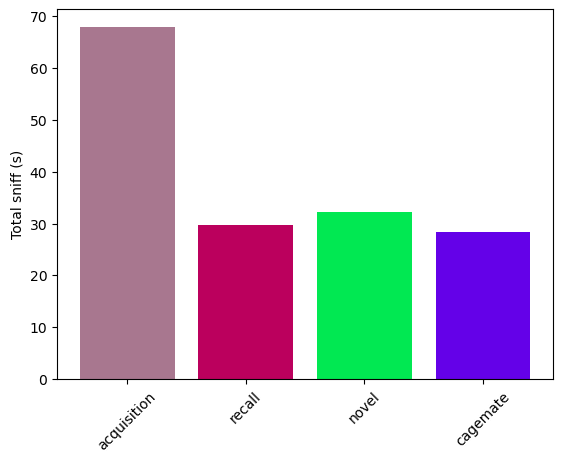

In [33]:
import matplotlib.pyplot as plt
colors = ['#A8778f', '#Bb005d','#01e852','#6401e8']
plt.bar(event_total_time_averages.keys(), event_total_time_averages.values(), color = colors)
plt.xticks(rotation=45)
plt.ylabel('Total sniff (s)')


In [34]:
FCN_event_total_time = FCN_df[FCN_df['level_1'] == 'total time']
FCN_event_total_time_averages = {}
for event in ['acquisition', 'recall', 'novel', 'cagemate']:
    avg_event = FCN_event_total_time[event].mean()
    FCN_event_total_time_averages[event] = avg_event
FCN_event_total_time_averages

{'acquisition': 33.22266666666661,
 'recall': 20.111333333333334,
 'novel': 27.200333333333333,
 'cagemate': 21.621}

In [35]:
NFC_event_total_time = NFC_df[NFC_df['level_1'] == 'total time']
NFC_event_total_time_averages = {}
for event in ['acquisition', 'recall', 'novel', 'cagemate']:
    avg_event = NFC_event_total_time[event].mean()
    NFC_event_total_time_averages[event] = avg_event
NFC_event_total_time_averages

{'acquisition': 40.609,
 'recall': 17.57766666666667,
 'novel': 23.921000000000003,
 'cagemate': 19.432000000000077}

In [36]:
CNF_event_total_time = CNF_df[CNF_df['level_1'] == 'total time']
CNF_event_total_time_averages = {}
for event in ['acquisition', 'recall', 'novel', 'cagemate']:
    avg_event = CNF_event_total_time[event].mean()
    CNF_event_total_time_averages[event] = avg_event
CNF_event_total_time_averages

{'acquisition': 129.82666666666665,
 'recall': 51.65633333333333,
 'novel': 45.72266666666667,
 'cagemate': 44.189666666666675}

## Wilcoxon Single Unit Analysis 

In [37]:
phase2_analysis = spike.SpikeAnalysis_MultiRecording(phase2_collection, 100,50,0.5)

All set to analyze


In [38]:
            #offset included                     offset excluded
# 3, 5, -2 =      76                                   84
# 1 , 5, -2 =     84                                   76
# 2, 5, -2 =      82                                   80                               
# 2, 4, 0 =       82                                   
# 3, 4 , -1 =     65                                   73
# 2, 4, -1 =      71                                   82
# 3, 4, 0 =       74
# 3, 3, 0 =       70
# 2, 3, 0 =       69
# 2, 4, 1 =       69

In [39]:
equalize = 2
baseline_window = 4
offset = -1
print(phase2_analysis.fishers_exact_wilcox('novel', 'cagemate', equalize = equalize, baseline_window=baseline_window,offset= offset, event3 = None))
phase2_analysis.fishers_exact_wilcox('recall', 'acquisition',equalize = equalize, baseline_window=baseline_window,offset= offset, event3 = None)

(1.0, 1.0, [[16, 199], [16, 199]])


(0.8440899202320522, 0.7374012096932558, [[18, 197], [21, 194]])

In [40]:
# wilcoxon_results = wilcoxon_results[['original unit id',
#  'Event_x',
#  'event1 vs event2_x',
#  'Event_y',
#  'event1 vs event2_y',
#  'Event_x.1',
#  'event1 vs event2_x.1',
#  'Event_y.1',
#  'event1 vs event2_y.1',
#  'Event',
#  'event1 vs event2']]
# wilcoxon_results.columns = ['original unit id',
#  'Event_x',
#  'acquisition vs novel',
#  'Event_y',
#  'acquisition vs recall',
#  'Event_x.1',
#  'recall vs cagemate',
#  'Event_y.1',
#  'novel vs recall',
#  'Event',
#  'novel vs cagemate']
# wilcoxon_results = wilcoxon_results[['original unit id',
#  'acquisition vs novel',
#  'acquisition vs recall',
#  'recall vs cagemate',
#  'novel vs recall',
#  'novel vs cagemate']]

In [41]:
equalize = 2
baseline_window = 4
offset = -1
for event in ['novel', 'cagemate', 'recall', 'acquisition']:
    pca_analysis.wilcox_baseline_v_event_collection(event=event, equalize =equalize, baseline_window=baseline_window, offset=offset, plot = False, save = True)

In [42]:
phase2_collection.wilcox_dfs
df_list = []
for comparison in ['2s novel vs 4s baseline', '2s cagemate vs 4s baseline', '2s recall vs 4s baseline', '2s acquisition vs 4s baseline']:
    df = phase2_collection.wilcox_dfs[comparison]
    df_list.append(df)

is_first = True 
for df in df_list:
    if is_first:
        master_df = df[['Subject', 'Recording', 'original unit id', 
                            'Event','event1 vs event2']]
        is_first = False
    else: 
        temp_df = df[['Subject', 'Recording', 'original unit id', 
                            'Event', 'event1 vs event2']]
        master_df = master_df.merge(temp_df,  on=['Subject', 'Recording', 'original unit id'], how = 'left')
    
master_df 

C:\Users\megha\AppData\Local\Temp\ipykernel_9500\2744780774.py:16: FutureWarning: Passing 'suffixes' which cause duplicate columns {'event1 vs event2_x', 'Event_x'} in the result is deprecated and will raise a MergeError in a future version.
  master_df = master_df.merge(temp_df,  on=['Subject', 'Recording', 'original unit id'], how = 'left')


Subject                     Recording  original unit id  \
0       1.1  20230803_101331_1_merged.rec               196   
1       1.1  20230803_101331_1_merged.rec                91   
2       1.1  20230803_101331_1_merged.rec               267   
3       1.1  20230803_101331_1_merged.rec               136   
4       1.1  20230803_101331_1_merged.rec                79   
..      ...                           ...               ...   
210     1.4  20230818_133620_1_merged.rec               101   
211     1.4  20230818_133620_1_merged.rec                50   
212     1.4  20230818_133620_1_merged.rec                74   
213     1.4  20230818_133620_1_merged.rec               107   
214     1.4  20230818_133620_1_merged.rec                53   

                     Event_x event1 vs event2_x                     Event_y  \
0    2s novel vs 4s baseline    not significant  2s cagemate vs 4s baseline   
1    2s novel vs 4s baseline    not significant  2s cagemate vs 4s baseline   
2    2s novel vs 4s baseline    not significant  2s cagemate vs 4s baseline   
3    2s novel vs 4s baseline    not significant  2s cagemate vs 4s baseline   
4    2s novel vs 4s baseline    not significant  2s cagemate vs 4s baseline   
..                       ...                ...                         ...   
210  2s novel vs 4s baseline    not significant  2s cagemate vs 4s baseline   
211  2s novel vs 4s baseline    not significant  2s cagemate vs 4s baseline   
212  2s novel vs 4s baseline    not significant  2s cagemate vs 4s baseline   
213  2s novel vs 4s baseline    not significant  2s cagemate vs 4s baseline   
214  2s novel vs 4s baseline    not significant  2s cagemate vs 4s baseline   

    event1 vs event2_y                   Event_x event1 vs event2_x  \
0      not significant  2s recall vs 4s baseline    not significant   
1      not significant  2s recall vs 4s baseline    not significant   
2      not significant  2s recall vs 4s baseline    not significant   
3      not significant  2s recall vs 4s baseline    not significant   
4            increases  2s recall vs 4s baseline    not significant   
..                 ...                       ...                ...   
210    not significant  2s recall vs 4s baseline    not significant   
211    not significant  2s recall vs 4s baseline    not significant   
212    not significant  2s recall vs 4s baseline    not significant   
213    not significant  2s recall vs 4s baseline    not significant   
214    not significant  2s recall vs 4s baseline    not significant   

                           Event_y event1 vs event2_y  
0    2s acquisition vs 4s baseline    not significant  
1    2s acquisition vs 4s baseline    not significant  
2    2s acquisition vs 4s baseline    not significant  
3    2s acquisition vs 4s baseline    not significant  
4    2s acquisition vs 4s baseline    not significant  
..                             ...                ...  
210  2s acquisition vs 4s baseline    not significant  
211  2s acquisition vs 4s baseline    not significant  
212  2s acquisition vs 4s baseline    not significant  
213  2s acquisition vs 4s baseline    not significant  
214  2s acquisition vs 4s baseline    not significant  

[215 rows x 11 columns]

In [43]:
master_df.columns = ['Subject',
 'Recording',
 'original unit id',
 'Event_x',
 'novel vs baseline',
 'Event_y',
 'cagemate vs baseline',
 'Event_x',
 'familiar vs baseline',
 'Event_y',
 'acquisition vs baseline']
master_df = master_df[['original unit id',
 'novel vs baseline',
 'cagemate vs baseline',
 'familiar vs baseline',
 'acquisition vs baseline']]
master_df

original unit id novel vs baseline cagemate vs baseline  \
0                 196   not significant      not significant   
1                  91   not significant      not significant   
2                 267   not significant      not significant   
3                 136   not significant      not significant   
4                  79   not significant            increases   
..                ...               ...                  ...   
210               101   not significant      not significant   
211                50   not significant      not significant   
212                74   not significant      not significant   
213               107   not significant      not significant   
214                53   not significant      not significant   

    familiar vs baseline acquisition vs baseline  
0        not significant         not significant  
1        not significant         not significant  
2        not significant         not significant  
3        not significant         not significant  
4        not significant         not significant  
..                   ...                     ...  
210      not significant         not significant  
211      not significant         not significant  
212      not significant         not significant  
213      not significant         not significant  
214      not significant         not significant  

[215 rows x 5 columns]

In [44]:
def group_cells(novel, cagemate, fam, acquisition):
    group = ''
    if novel != 'not significant':
        group = 'novel'
    if cagemate != 'not significant':
        group = group + 'cagemate' 
    if fam != 'not significant':
        group = group + 'fam'
    if acquisition != 'not significant':
        group = group + 'acquisition'
    return group

master_df['cell group'] = master_df.apply(lambda row: group_cells(row['novel vs baseline'],
                                                                  row['cagemate vs baseline'],
                                                                  row['familiar vs baseline'],
                                                                  row['acquisition vs baseline']), axis = 1)
results = master_df.groupby('cell group').count()
results

C:\Users\megha\AppData\Local\Temp\ipykernel_9500\2510486990.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_df['cell group'] = master_df.apply(lambda row: group_cells(row['novel vs baseline'],


original unit id  novel vs baseline  \
cell group                                                      
                                       153                153   
acquisition                             16                 16   
cagemate                                10                 10   
cagemateacquisition                      2                  2   
cagematefamacquisition                   1                  1   
fam                                     16                 16   
famacquisition                           1                  1   
novel                                   13                 13   
novelcagemate                            2                  2   
novelcagemateacquisition                 1                  1   

                          cagemate vs baseline  familiar vs baseline  \
cell group                                                             
                                           153                   153   
acquisition                                 16                    16   
cagemate                                    10                    10   
cagemateacquisition                          2                     2   
cagematefamacquisition                       1                     1   
fam                                         16                    16   
famacquisition                               1                     1   
novel                                       13                    13   
novelcagemate                                2                     2   
novelcagemateacquisition                     1                     1   

                          acquisition vs baseline  
cell group                                         
                                              153  
acquisition                                    16  
cagemate                                       10  
cagemateacquisition                             2  
cagematefamacquisition                          1  
fam                                            16  
famacquisition                                  1  
novel                                          13  
novelcagemate                                   2  
novelcagemateacquisition                        1

### Wilcoxon Plotting function

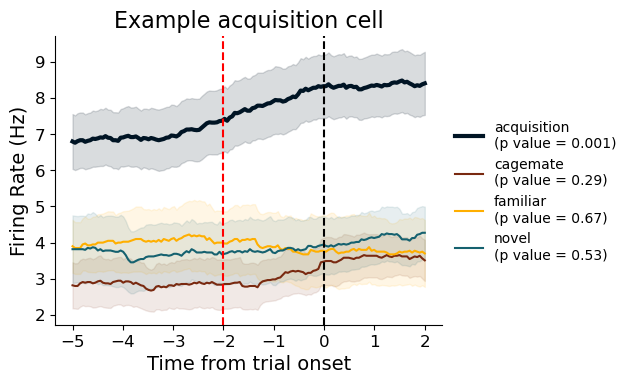

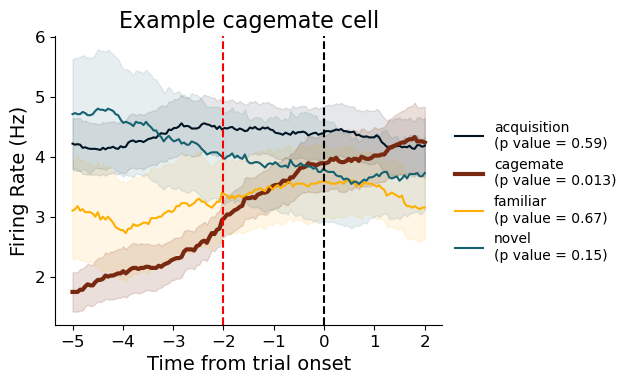

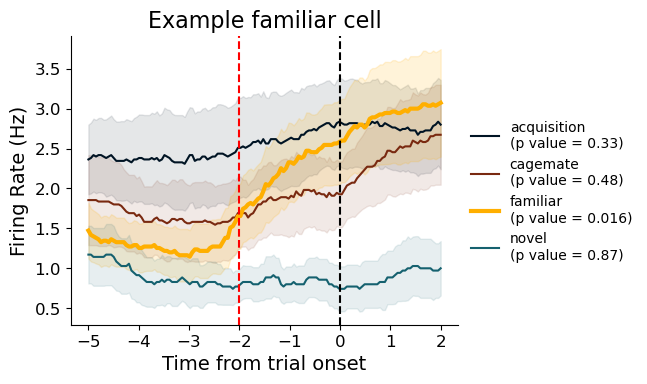

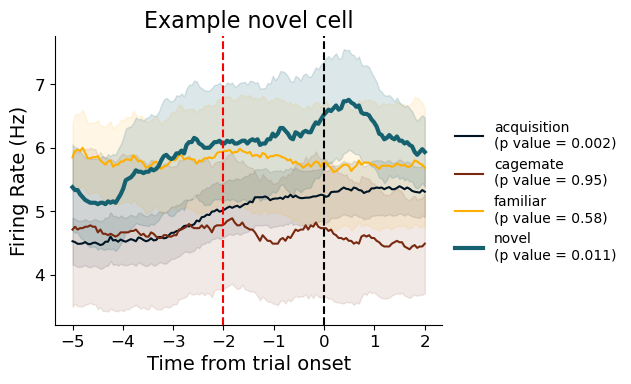

In [45]:
color_dict = {'cagemate':hex_2_rgb('#792910'), 'novel':hex_2_rgb('#15616F'),
              'recall':hex_2_rgb('#FFAF00'), 'acquisition':hex_2_rgb('#001424') }
def wilcox_baseline_v_event_unit(
    recording_name, unit_id, events,
    equalize, baseline_window, offset, title, highlight, exclude_offset=False,
    
):
    """
    plots event triggered average firing rates for units with significant
    wilcoxon signed rank tests (p value <0.05) for event v baseline window.

    Args(4 total, 4 required):
        events: list of str, event types of which ehpys snippets happen during
        equalize: float, length (s) of events used by padding with post
            event time or trimming events all to equalize (s) long used
        baseline_window: int, default=0, seconds prior to start of event
        offset: int, adjusts end of baseline by offset(s) from onset of
            behavior such that offset=2 adds the first two seconds of event
            data into baseline while offest=-2 removes them from baseline
            averages

    Returns:
        none
    """
    plt.figure(figsize=(5, 3.75))
    recording = phase2_analysis.ephyscollection.get_by_name(recording_name)
    for event in events:
        if event == highlight:
            linewidth = 3
            alpha = .15
        else:
            linewidth = 1.5
            alpha = .1
        temp_master_df = pca_analysis.wilcox_baseline_v_event_collection(
            event,
            equalize,
            baseline_window,
            offset,
            exclude_offset,
            plot=False,
            save=False)
        master_df = temp_master_df[(temp_master_df['Recording'] ==
                                    recording_name) & (
                                        temp_master_df['original unit id']
                                        == unit_id)]
        master_df = master_df.reset_index()
        unit_event_firing_rates = pca_analysis.__get_unit_event_firing_rates__(
            recording,
            event,
            equalize,
            baseline_window,
            0)
        mean_arr = np.mean(unit_event_firing_rates[unit_id], axis=0)
        sem_arr = sem(unit_event_firing_rates[unit_id], axis=0)
        p_value = master_df["p value"].values[0]
        x = np.linspace(
            start=-baseline_window, stop=equalize, num=len(mean_arr)
        )
        title_p = "{:.2g}".format(p_value)
        if event != 'recall':
            plt.plot(x, mean_arr, c=color_dict[event], linewidth=linewidth, label = f'{event}\n(p value = {title_p})')
        else:
            plt.plot(x, mean_arr, c=color_dict[event], linewidth=linewidth, label = f'familiar\n(p value = {title_p})')
        plt.fill_between(
            x, mean_arr - sem_arr, mean_arr + sem_arr, alpha=alpha,
            color = color_dict[event])
    if offset != 0:
        plt.axvline(x=offset, color='r', linestyle='--')
    plt.axvline(x=0, color="k", linestyle="--")   
    plt.title(title, fontsize = 16)
    plt.legend(bbox_to_anchor = (1,.75), frameon = False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel('Time from trial onset', fontsize=14)
    plt.ylabel('Firing Rate (Hz)', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
wilcox_baseline_v_event_unit('20230804_141009_1_merged.rec', 6, 
                            ['acquisition', 'cagemate', 'recall', 'novel'], 
                            2, 5, -2, 'Example acquisition cell',
                            'acquisition')
wilcox_baseline_v_event_unit('20230804_141009_1_merged.rec', 147, 
                             ['acquisition', 'cagemate', 'recall', 'novel'], 
                             2, 5, -2, 'Example cagemate cell',
                             'cagemate')
wilcox_baseline_v_event_unit('20230804_121600_1_merged.rec', 19,
                            ['acquisition', 'cagemate', 'recall', 'novel'],
                               2, 5, -2, 'Example familiar cell',
                               'recall')
wilcox_baseline_v_event_unit('20230803_141047_1_merged.rec', 50, 
                             ['acquisition', 'cagemate', 'recall', 'novel'],
                               2, 5, -2,'Example novel cell',
                               'novel')


## Decoders

In [8]:
phase2_analysis = spike.SpikeAnalysis_MultiRecording(phase2_collection, 100, 50, 0.5)

All set to analyze


### Functions

In [11]:
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
                                   
def __PCA_for_decoding_minus_pc1__(equalize, pre_window, post_window, no_PCs, events, counter_event=None):
        full_PCA_matrix, t_df, key, coefficients, explained_variance_ratios = phase2_analysis.PCA_matrix_generation(equalize, pre_window, post_window, events = None)
        recordings = full_PCA_matrix.columns.to_list()
        recording_list = np.unique(recordings)
        coefficients = coefficients[:, 1:no_PCs]
        recording_indices = get_indices(recordings)
        decoder_data1 = {}
        all_events = events
        if counter_event is not None:
            for event in counter_event:
                if event not in all_events:
                    all_events.append(event)
        #decoder data dict: events for keys, values is a list of len(events)
        #each element in the list is the transformed matrix
        for recording in recording_list:
            #iterate through recordings
            start = recording_indices[recording][0]
            stop = recording_indices[recording][1]
            print(recording)
            #trim weight matrix for only those neurons in the current recording
            subset_coeff = coefficients[start:stop+1, :]
            recording_instance = phase2_analysis.ephyscollection.get_by_name(recording)
            for event in all_events:
                #grab all event firing rates for current event in current recording
                event_firing_rates = phase2_analysis.__get_event_firing_rates__(recording_instance, event,
                                                                equalize, pre_window, post_window)
                for trial in range(len(event_firing_rates)):
                    #iterate through each event
                    trial_data = np.transpose(event_firing_rates[trial])
                    #transpoe event firing rates from neurons x timebins to timebins x neurons
                    transformed_trial = np.dot(trial_data, subset_coeff)
                    #transform each trial with original weight matrix
                    #T (timebins x pcs) = D (timebins x neurons). W (pcs x neurons) 
                    if event in decoder_data1.keys():
                        #append transformed matrix to decoder_data1 dict
                        decoder_data1[event].append(transformed_trial)
                    else: 
                        decoder_data1[event] = []
                        decoder_data1[event].append(transformed_trial)
        return decoder_data1


def get_indices(repeated_items_list):
    """
    Takes in an indexed key or a list of repeated items, 
    creates a list of indices that correspond to each unique item.

    Args (1):
        repeated_items_list: list, list of repeated items

    Returns:
        item_indices: list of tuples, where the first element
            is the first index of an item, and the second
            element is the last index of that item
    """
    is_first = True
    item_indices = {}
    for i in range(len(repeated_items_list)):
        if is_first:
            current_item = repeated_items_list[i]
            start_index = 0
            is_first = False
        else:
            if repeated_items_list[i] == current_item:
                end_index = i
                if i == (len(repeated_items_list)-1):
                    item_indices[current_item] = [start_index, end_index]
            else:
                item_indices[current_item] = [start_index, end_index]
                start_index = i
                current_item = repeated_items_list[i]
    return item_indices

def __PCA_for_decoding__(equalize, pre_window, post_window, no_PCs, events, counter_events = None):
        full_PCA_matrix, t_df, key, coefficients, explained_variance_ratios = phase2_analysis.PCA_matrix_generation(equalize, pre_window, post_window, events = events)
        recordings = full_PCA_matrix.columns.to_list()
        recording_list = np.unique(recordings)
        coefficients = coefficients[:, :no_PCs]
        recording_indices = get_indices(recordings)
        decoder_data = {}
        if counter_events is not None:
            for event in counter_events:
                if event not in events:
                    events.append(event)
        #decoder data dict: events for keys, values is a list of len(events)
        #each element in the list is the transformed matrix
        for recording in recording_list:
            #iterate through recording
            start = recording_indices[recording][0]
            stop = recording_indices[recording][1]
            #trim weight matrix for only those neurons in the current recording
            subset_coeff = coefficients[start:stop+1, :]
            recording_instance = phase2_analysis.ephyscollection.get_by_name(recording)
            for event in events:
                #grab all event firing rates for current event in current recording
                event_firing_rates = phase2_analysis.__get_event_firing_rates__(recording_instance, event,
                                                                equalize, pre_window, post_window)
                for trial in range(len(event_firing_rates)):
                    #iterate through each event
                    trial_data = np.transpose(event_firing_rates[trial])
                    #transpoe event firing rates from neurons x timebins to timebins x neurons
                    transformed_trial = np.dot(trial_data, subset_coeff)
                    #transform each trial with original weight matrix
                    #T (timebins x pcs) = D (timebins x neurons). W (pcs x neurons) 
                    if event in decoder_data.keys():
                        #append transformed matrix to decoder_data1 dict
                        decoder_data[event].append(transformed_trial)
                    else: 
                        decoder_data[event] = []
                        decoder_data[event].append(transformed_trial)
        return decoder_data



def cross_trial_decoder(equalize, pre_window, post_window, num_fold, num_shuffle, no_PCs, same_event, event1, event2, plot = True):
    decoder_data1 = __PCA_for_decoding__(equalize, pre_window, post_window, no_PCs, events = [same_event, event1], counter_events = [event2])
    decoder_data2 = __PCA_for_decoding__(equalize, pre_window, post_window, no_PCs, events = [same_event, event2], counter_events = [event1])
    ex_trial_matrix = decoder_data1[same_event][0]
    T = ex_trial_matrix.shape[0]
    auc = {}
    diff_events = [event1, event2]
    decoders = [decoder_data1, decoder_data2]
    for i in [0,1]:  
        data_neg_train = []
        data_neg_test = []
        data_pos = []
        decoder_data = decoders[i]  
        for trial in decoder_data[same_event]:
            data_pos.append(trial)
        for trial in decoder_data[diff_events[i]]:
            data_neg_train.append(trial)
        if i == 0:
            for trial in decoder_data[diff_events[1]]:
                data_neg_test.append(trial)
        else:
            for trial in decoder_data[diff_events[0]]:
                data_neg_test.append(trial)
        data_pos= np.stack(data_pos, axis=2)
        data_neg_train = np.stack(data_neg_train, axis=2)
        data_neg_test = np.stack(data_neg_test, axis=2)
        num_pos = data_pos.shape[2]
        num_neg_train = data_neg_train.shape[2]
        num_neg_test = data_neg_test.shape[2]
        data_pos = data_pos[:, :, np.random.permutation(num_pos)]
        data_neg_train = data_neg_train[:, :, np.random.permutation(num_neg_train)]
        data_neg_test = data_neg_test[:, :, np.random.permutation(num_neg_test)]
        event = diff_events[i]
        auc[event] = {'glm': [], 'rf': [], 'glm_shuffle': [], 'rf_shuffle': []}
        for fold in range(num_fold):
            auc_glm = []
            auc_rf = []
            auc_glm_shuffle = []
            auc_rf_shuffle = []
            pos_fold = num_pos // num_fold
            neg_fold_train = num_neg_train // num_fold
            neg_fold_test = num_neg_test // num_fold
            data_test = np.concatenate((data_pos[:, :, fold * pos_fold:(fold + 1) * pos_fold],
                                        data_neg_test[:, :, fold * neg_fold_test:(fold + 1) * neg_fold_test]), axis=2)
            label_test = np.concatenate((np.ones((fold + 1) * pos_fold - fold * pos_fold),
                                        np.zeros((fold + 1) * neg_fold_test - fold * neg_fold_test)))
            data_train = np.concatenate((
                data_pos[:, :, np.setdiff1d(np.arange(num_pos), 
                np.arange(fold * pos_fold, (fold + 1) * pos_fold))],
                data_neg_train[:, :, np.setdiff1d(np.arange(num_neg_train), 
                np.arange(fold * neg_fold_train, (fold + 1) * neg_fold_train))]),
                axis=2)
            label_train = np.concatenate((np.ones(num_pos - (fold + 1) * pos_fold + fold * pos_fold),
                                        np.zeros(num_neg_train - (fold + 1) * neg_fold_train + fold * neg_fold_train)))
            for timebin in range(T):
                model_glm = LogisticRegression(class_weight='balanced') 
                model_glm.fit(data_train[timebin, :, :].T, label_train)
                pred_glm = model_glm.predict_proba(data_test[timebin, :, :].T)
                auc_glm.append(roc_auc_score(label_test, pred_glm[:, 1]))
                
                model_rf = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight = 'balanced'), n_estimators=50, random_state=0)
                model_rf.fit(data_train[timebin, :, :].T, label_train)
                pred_rf = model_rf.predict_proba(data_test[timebin, :, :].T)
                auc_rf.append(roc_auc_score(label_test, pred_rf[:, 1]))
            auc[event]['glm'].append(auc_glm)
            auc[event]['rf'].append(auc_rf)
            for shuffle in range(num_shuffle):
                temp_glm_shuffle = []
                temp_rf_shuffle = []
                label_train = np.random.permutation(label_train)
                for timebin in range(T):
                    model_glm = LogisticRegression(class_weight='balanced')
                    model_glm.fit(data_train[timebin, :, :].T, label_train)
                    pred_glm = model_glm.predict_proba(data_test[timebin, :, :].T)
                    temp_glm_shuffle.append(roc_auc_score(label_test, pred_glm[:, 1]))

                    model_rf = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight = 'balanced'), n_estimators=50, random_state=0)
                    model_rf.fit(data_train[timebin, :, :].T, label_train)
                    pred_rf = model_rf.predict_proba(data_test[timebin, :, :].T)
                    temp_rf_shuffle.append(roc_auc_score(label_test, pred_rf[:, 1]))
                auc_glm_shuffle.append(temp_glm_shuffle)
                auc_rf_shuffle.append(temp_rf_shuffle)
            auc[event]['glm_shuffle'].append(auc_glm_shuffle)
            auc[event]['rf_shuffle'].append(auc_rf_shuffle)
    if plot:
        __plot_auc__(auc, equalize, pre_window)
    return auc

def trial_decoder_AvB_BvC(equalize, pre_window, post_window, num_fold, num_shuffle, no_PCs, training_events, test_events, plot = True):
    #ugh fuck okay so this gonna take the 4/5 of positive training data, and make it the 1/5 neg data if two events are the same type
    decoder_data = __PCA_for_decoding__(equalize, pre_window, post_window, no_PCs, events = training_events, counter_events = test_events)
    ex_trial_matrix = decoder_data[training_events[0]][0]
    T = ex_trial_matrix.shape[0]
    all_events = list(set(training_events + test_events))
    auc = {}  
    data_A = []
    data_B = []
    data_C = []
    i = 0
    for event in all_events:
        for trial in decoder_data[event]:
            if i == 0: 
                data_A.append(trial)
            if i == 1:
                data_B.append(trial)
            if i == 2:
                data_C.append(trial)
        i+=1
    data_A= np.stack(data_A, axis=2)
    data_B = np.stack(data_B, axis=2)
    data_C = np.stack(data_C, axis=2)
    num_A = data_A.shape[2]
    num_B = data_B.shape[2]
    num_C = data_C.shape[2]
    data_A = data_A[:, :, np.random.permutation(num_A)]
    data_B = data_B[:, :, np.random.permutation(num_B)]
    data_C = data_C[:, :, np.random.permutation(num_C)]
    auc = {'glm': [], 'rf': [], 'glm_shuffle': [], 'rf_shuffle': []}
    for fold in range(num_fold):
        auc_glm = []
        auc_rf = []
        auc_glm_shuffle = []
        auc_rf_shuffle = []
        A_fold = num_A // num_fold
        B_fold = num_B // num_fold
        C_fold = num_C // num_fold
        data_test = np.concatenate((data_C[:, :, fold * C_fold:(fold + 1) * C_fold],
                                    data_B[:, :, fold * B_fold:(fold + 1) * B_fold]), axis=2)
        #here B is pos and c is neg
        label_test = np.concatenate((np.zeros((fold + 1) * C_fold - fold * C_fold),
                                    np.ones((fold + 1) * B_fold - fold * B_fold)))
        #so here i want A to be pos and b to neg  
        data_train = np.concatenate((
            data_B[:, :, np.setdiff1d(np.arange(num_B), 
            np.arange(fold * B_fold, (fold + 1) * B_fold))],
            data_A[:, :, np.setdiff1d(np.arange(num_A), 
            np.arange(fold * A_fold, (fold + 1) * A_fold))]),
            axis=2)
        label_train = np.concatenate((np.zeros(num_B - (fold + 1) * B_fold + fold * B_fold),
                                    np.ones(num_A - (fold + 1) * A_fold + fold * A_fold)))
        for timebin in range(T):
            model_glm = LogisticRegression(class_weight='balanced') 
            model_glm.fit(data_train[timebin, :, :].T, label_train)
            pred_glm = model_glm.predict_proba(data_test[timebin, :, :].T)
            auc_glm.append(roc_auc_score(label_test, pred_glm[:, 1]))
            
            model_rf = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight = 'balanced'), n_estimators=50, random_state=0)
            model_rf.fit(data_train[timebin, :, :].T, label_train)
            pred_rf = model_rf.predict_proba(data_test[timebin, :, :].T)
            auc_rf.append(roc_auc_score(label_test, pred_rf[:, 1]))
        auc['glm'].append(auc_glm)
        auc['rf'].append(auc_rf)
        for shuffle in range(num_shuffle):
            temp_glm_shuffle = []
            temp_rf_shuffle = []
            label_train = np.random.permutation(label_train)
            for timebin in range(T):
                model_glm = LogisticRegression(class_weight='balanced')
                model_glm.fit(data_train[timebin, :, :].T, label_train)
                pred_glm = model_glm.predict_proba(data_test[timebin, :, :].T)
                temp_glm_shuffle.append(roc_auc_score(label_test, pred_glm[:, 1]))

                model_rf = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight = 'balanced'), n_estimators=50, random_state=0)
                model_rf.fit(data_train[timebin, :, :].T, label_train)
                pred_rf = model_rf.predict_proba(data_test[timebin, :, :].T)
                temp_rf_shuffle.append(roc_auc_score(label_test, pred_rf[:, 1]))
            auc_glm_shuffle.append(temp_glm_shuffle)
            auc_rf_shuffle.append(temp_rf_shuffle)
        auc['glm_shuffle'].append(auc_glm_shuffle)
        auc['rf_shuffle'].append(auc_rf_shuffle)
    if plot:
        __plot_auc_1__(auc, equalize, pre_window)
    return auc

def __plot_auc_1__(auc_dict, equalize, pre_window):
    avg_auc = {}
    no_plots = len(auc_dict.keys())
    height_fig = math.ceil(no_plots/2)
    plt.figure(figsize=(12,4*height_fig))
    glm_avg = np.mean(auc_dict['glm'], axis = 0)
    glm_sem = sem(auc_dict['glm'], axis = 0)
    x =np.linspace(-pre_window, equalize, len(glm_avg))
    rf_avg = np.mean(auc_dict['rf'], axis = 0)
    rf_sem = sem(auc_dict['rf'], axis = 0)
    glm_shuffle_avg = np.mean(np.mean(auc_dict['glm_shuffle'], axis = 1), axis = 0)
    glm_shuffle_sem = sem(np.mean(auc_dict['glm_shuffle'], axis = 1), axis = 0)
    rf_shuffle_avg = np.mean(np.mean(auc_dict['rf_shuffle'], axis = 1), axis = 0)
    rf_shuffle_sem = sem(np.mean(auc_dict['rf_shuffle'], axis = 1), axis = 0)
    plt.plot(x, glm_avg, label ='glm')
    plt.fill_between(x, glm_avg-glm_sem, glm_avg+glm_sem, alpha = 0.2)
    plt.plot(x, rf_avg, label =  'rf')
    plt.fill_between(x, rf_avg-rf_sem, rf_avg+rf_sem, alpha = 0.2)
    plt.plot(x, glm_shuffle_avg, label = 'glm shuffle')
    plt.fill_between(x, glm_shuffle_avg-glm_shuffle_sem, glm_shuffle_avg+glm_shuffle_sem, alpha = 0.2)
    plt.plot(x, rf_shuffle_avg, label = 'rf shuffle')
    plt.fill_between(x, rf_shuffle_avg-rf_shuffle_sem, rf_shuffle_avg+rf_shuffle_sem, alpha = 0.2)
    plt.ylim(.25, 1)
    plt.axvline(x=0, color='k', linestyle='--')
    plt.legend(bbox_to_anchor=(1,1))
    plt.title('Decoder Accuracy')
    plt.show()
            
def __plot_auc__(auc_dict, equalize, pre_window):
    avg_auc = {}
    no_plots = len(auc_dict.keys())
    height_fig = math.ceil(no_plots/2)
    i = 1
    plt.figure(figsize=(12,4*height_fig))
    for key in auc_dict.keys():
        glm_avg = np.mean(auc_dict[key]['glm'], axis = 0)
        glm_sem = sem(auc_dict[key]['glm'], axis = 0)
        x =np.linspace(-pre_window, equalize, len(glm_avg))
        rf_avg = np.mean(auc_dict[key]['rf'], axis = 0)
        rf_sem = sem(auc_dict[key]['rf'], axis = 0)
        glm_shuffle_avg = np.mean(np.mean(auc_dict[key]['glm_shuffle'], axis = 1), axis = 0)
        glm_shuffle_sem = sem(np.mean(auc_dict[key]['glm_shuffle'], axis = 1), axis = 0)
        rf_shuffle_avg = np.mean(np.mean(auc_dict[key]['rf_shuffle'], axis = 1), axis = 0)
        rf_shuffle_sem = sem(np.mean(auc_dict[key]['rf_shuffle'], axis = 1), axis = 0)
        avg_auc[key] = [glm_avg, rf_avg, glm_shuffle_avg, rf_shuffle_avg]
        plt.subplot(height_fig,2,i)
        plt.plot(x, glm_avg, label ='glm')
        plt.fill_between(x, glm_avg-glm_sem, glm_avg+glm_sem, alpha = 0.2)
        plt.plot(x, rf_avg, label =  'rf')
        plt.fill_between(x, rf_avg-rf_sem, rf_avg+rf_sem, alpha = 0.2)
        plt.plot(x, glm_shuffle_avg, label = 'glm shuffle')
        plt.fill_between(x, glm_shuffle_avg-glm_shuffle_sem, glm_shuffle_avg+glm_shuffle_sem, alpha = 0.2)
        plt.plot(x, rf_shuffle_avg, label = 'rf shuffle')
        plt.fill_between(x, rf_shuffle_avg-rf_shuffle_sem, rf_shuffle_avg+rf_shuffle_sem, alpha = 0.2)
        plt.title(f'Trained for {key}')
        plt.ylim(.4, 1)
        plt.axvline(x=0, color='k', linestyle='--')
        if i == 2:
            plt.legend(bbox_to_anchor=(1,1))
        i += 1
    plt.suptitle('Decoder Accuracy')
    plt.show()

    
def collapsed_auc_dict(auc, t1, t2, timebin, pre_window):
    collapsed_auc_dict = {}
    glm = {}
    glm_shuffle = {}
    rf = {}
    rf_shuffle = {}
    t1 = int((t1 + pre_window) * 1000 / timebin)
    t2 = int((t2 + pre_window) * 1000 / timebin)
    for key in auc.keys():
        glm_across_time = np.array(auc[key]['glm'])
        glm_trimmed = glm_across_time[:, t1:t2]
        # glm across time = fold x timebins 
        glm[key] = np.mean(glm_trimmed, axis =1)
        rf_across_time = np.array(auc[key]['rf'])
        rf_trimmed = rf_across_time[:, t1:t2]
        rf[key] =  np.mean(rf_trimmed, axis =1)
        glm_shuffle_temp = []
        rf_shuffle_temp = []
        for i in range(5):
            glm_shuffle_across_time = np.array(auc[key]['glm_shuffle'][i])
            glm_shuffle_trimmed = glm_shuffle_across_time[:, t1:t2]
            glm_shuffle_temp.append(np.mean(glm_shuffle_trimmed, axis = 1))
            rf_shuffle_across_time = np.array(auc[key]['rf_shuffle'][i])
            rf_shuffle_trimmed = rf_shuffle_across_time[:, t1:t2]
            rf_shuffle_temp.append(np.mean(rf_shuffle_trimmed, axis = 1))
        glm_shuffle[key] = np.mean(np.array(glm_shuffle_temp), axis = 1)
        rf_shuffle[key] = np.mean(np.array(rf_shuffle_temp), axis = 1)
    collapsed_auc_dict = {'Generalized\nLinear Model':glm,'Shuffled ':glm_shuffle,
                    'Random Forest\nClassifier':rf,'Shuffled':rf_shuffle}
    return collapsed_auc_dict 



def across_pcs_auc(auc_dict, t1, t2, timebin, pre_window):
    pc_dict = {}
    for pc in auc_dict.keys():
        pc_dict[pc] = collapsed_auc_dict(auc_dict[pc], t1, t2, timebin, pre_window)
    return pc_dict


### 100 smoothing window and 50 ms time bins

In [48]:
# nov_acq_v_fam_auc = cross_trial_decoder(equalize = 3, pre_window = 3, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= 8, same_event='acquisition', event1='recall', event2='novel')
# acq_nov = {}
# acq_fam = {}
# for pc in range(1,9):
#     print(pc, 'novel')
#     acq_nov[pc] = phase2_analysis.trial_decoder(equalize = 3, pre_window = 3, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= pc, events = ['acquisition', 'novel'])
#     print(pc, 'fam')
#     acq_fam[pc] = phase2_analysis.trial_decoder(equalize = 3, pre_window = 3, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= pc, events = ['acquisition', 'recall'])


In [49]:
#nov_acq_v_fam_auc = cross_trial_decoder(equalize = 3, pre_window = 3, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= 8, same_event='acquisition', event1='cagemate', event2='novel')



In [50]:
#novel_v_fam = cross_trial_decoder(equalize = 3, pre_window = 3, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= 8, same_event='novel', event1='cagemate', event2='recall')

In [51]:
#cagemate_v_other = cross_trial_decoder(equalize = 3, pre_window = 3, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= 8, same_event='cagemate', event1='novel', event2='recall')

In [52]:
#cagemate_v_other = cross_trial_decoder(equalize = 3, pre_window = 3, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= 8, same_event='recall', event1='cagemate', event2='novel')

In [53]:
#cagemate_v_other = cross_trial_decoder(equalize = 3, pre_window = 3, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= 8, same_event='acquisition', event1='cagemate', event2='recall')

In [54]:
#oneA_results = trial_decoder_AvB_BvC(3, 3, post_window=0, num_fold=5, num_shuffle=5, no_PCs=8, training_events = ['cagemate', 'recall'], test_events = ['recall', 'novel'], plot = True)

In [55]:
#oneA_results = trial_decoder_AvB_BvC(3, 3, post_window=0, num_fold=5, num_shuffle=5, no_PCs=8, training_events = ['novel', 'recall'], test_events = ['recall', 'cagemate'], plot = True)

In [56]:
# all_4 = {}
# for pc in range(1,9):
#         all_4[pc] = phase2_analysis.trial_decoder(equalize = 3, pre_window = 3, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= pc, events = ['acquisition', 'novel', 'cagemate', 'recall'])

    

In [57]:
# three_SA = {}
# for pc in range(1,9):
#         three_SA[pc] = phase2_analysis.trial_decoder(equalize = 3, pre_window = 3, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= pc, events = ['novel', 'cagemate', 'recall'])

In [58]:
# pcs = 9
# three_SA[pcs] = phase2_analysis.trial_decoder(equalize = 3, pre_window = 3, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= pcs, events = ['novel', 'cagemate', 'recall'])

### 250 smoothing Window 100 ms Timebin

In [24]:
decoder_tester = spike.SpikeAnalysis_MultiRecording(phase2_collection, 250, 100, 0.5)
phase2_analysis = spike.SpikeAnalysis_MultiRecording(phase2_collection, 250, 100, 0.5)
pca_analysis = spike.SpikeAnalysis_MultiRecording(phase2_collection, 100, 50, 0.5)

All set to analyze
All set to analyze
All set to analyze


In [22]:
matrix, coeff, var =  phase2_analysis.PCA_trajectories(3, 3, 0, plot = False, events = ['acquisition','cagemate', 'recall', 'novel'])
print(spike.PCs_needed(var, .95))

3


In [33]:
matrix, coeff, var =  pca_analysis.PCA_trajectories(5, 5, 0, plot = False, events = ['acquisition','cagemate', 'recall', 'novel'])
print(spike.PCs_needed(var, .95))

6


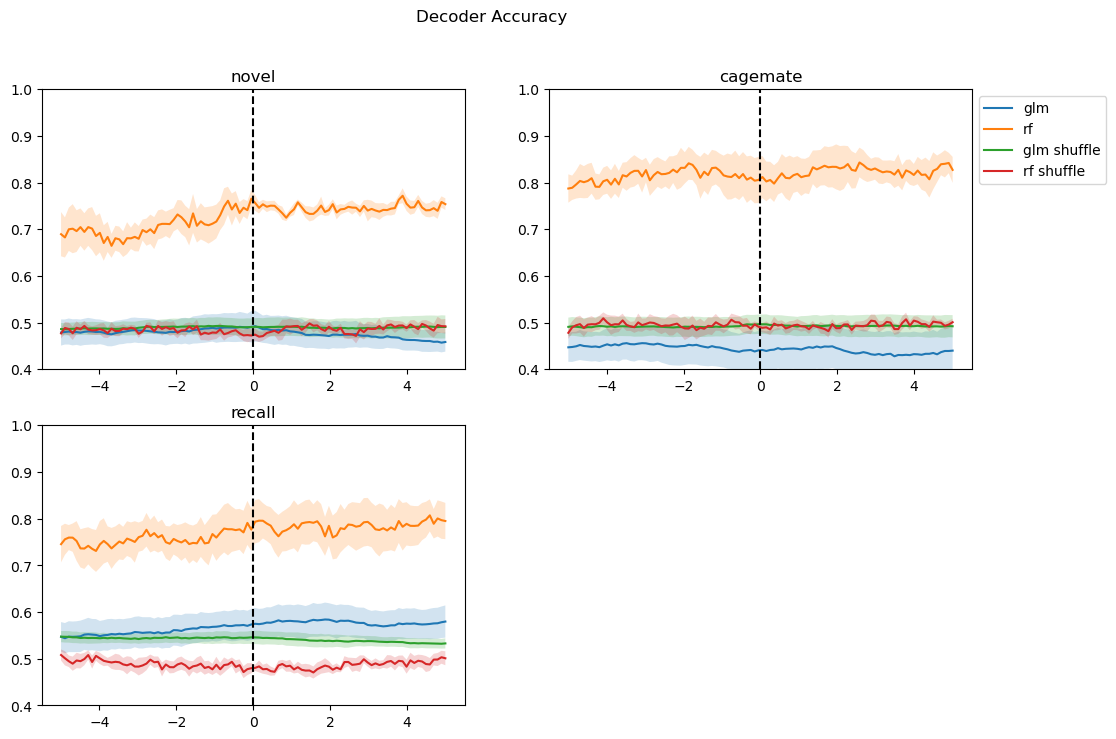

In [60]:
sm_250_tb_100_5_5 = decoder_tester.trial_decoder(equalize = 5, pre_window = 5, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= 8, events = ['novel', 'cagemate', 'recall'])


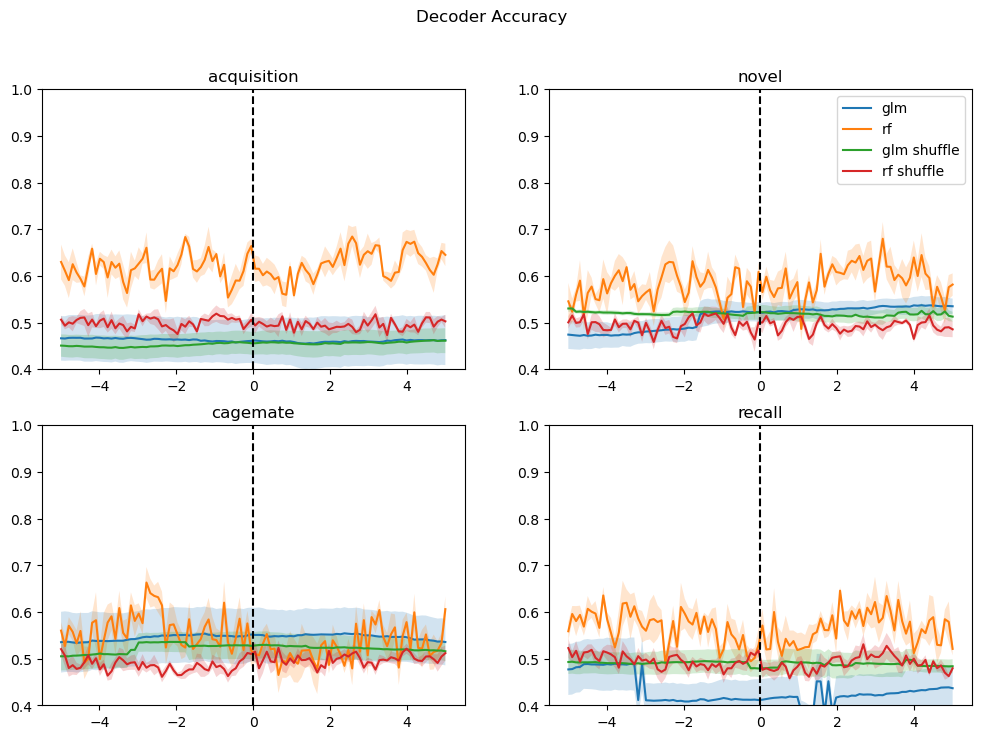

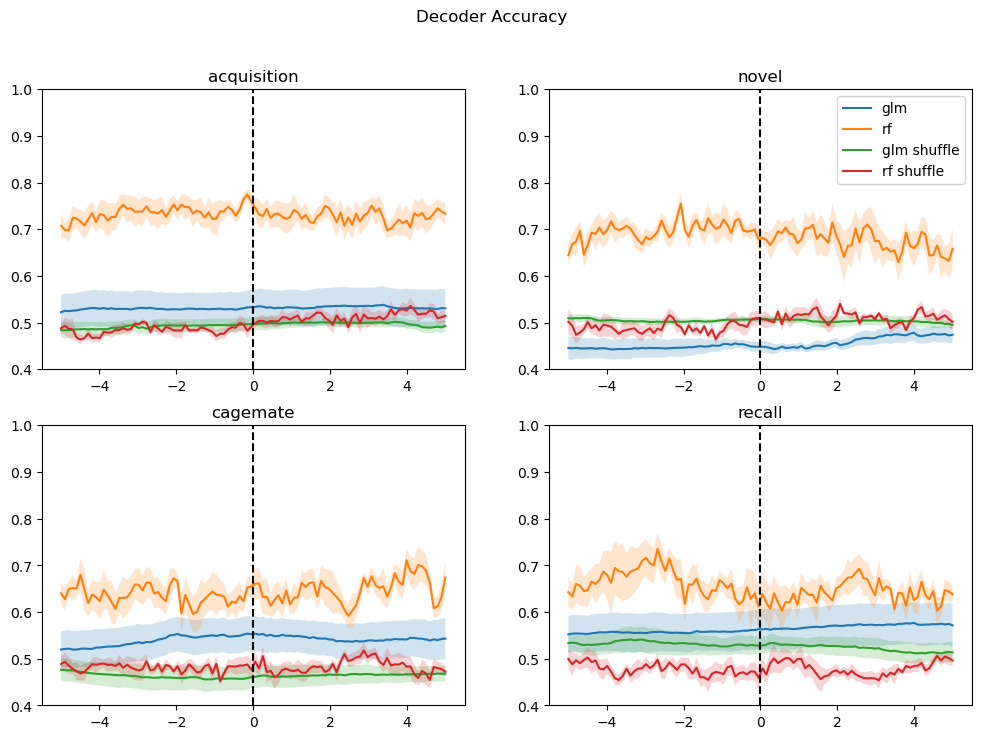

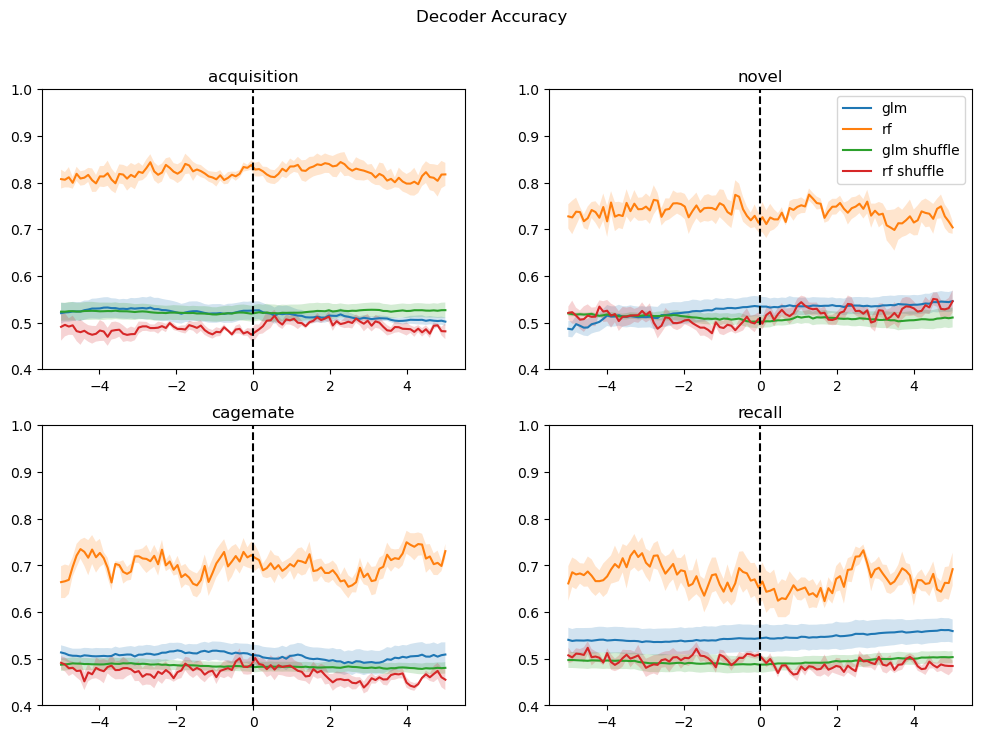

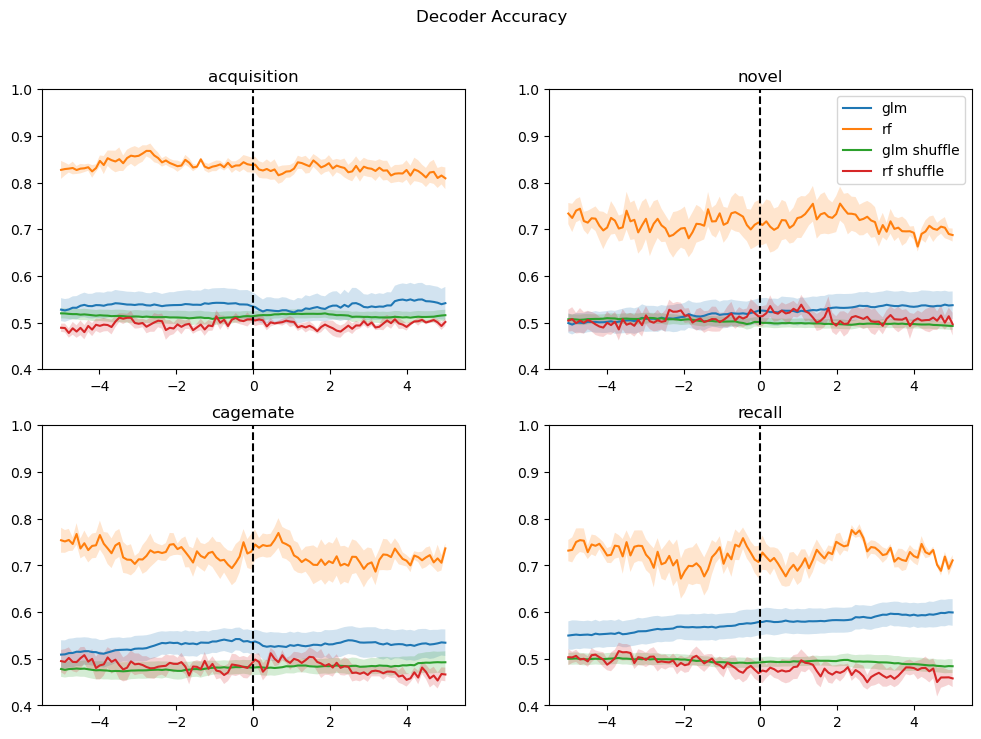

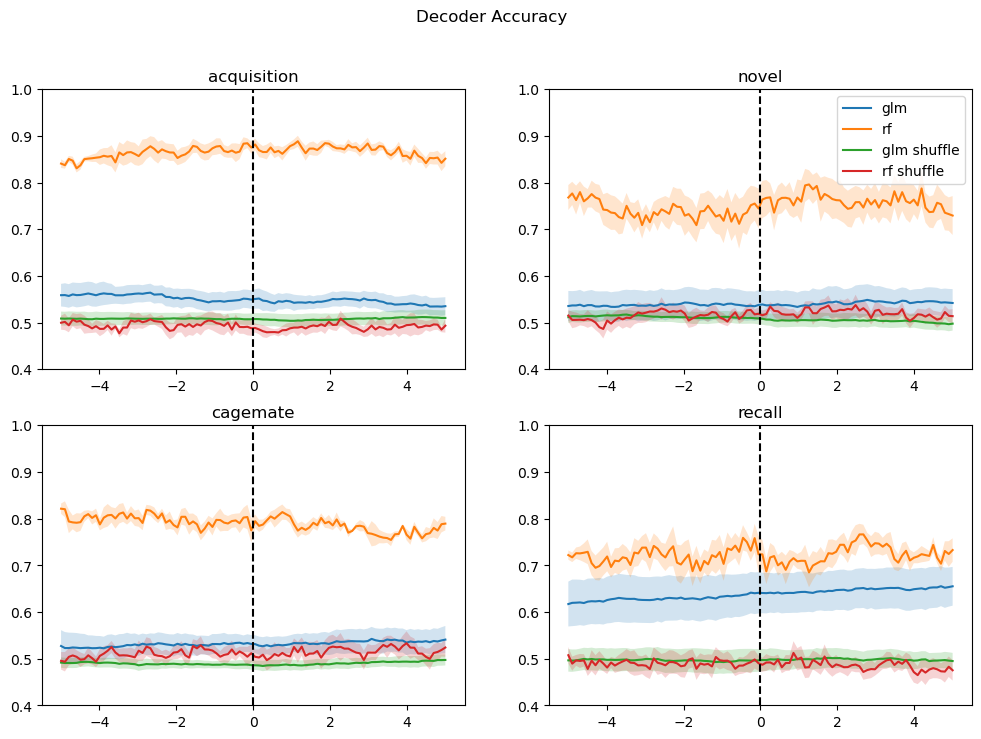

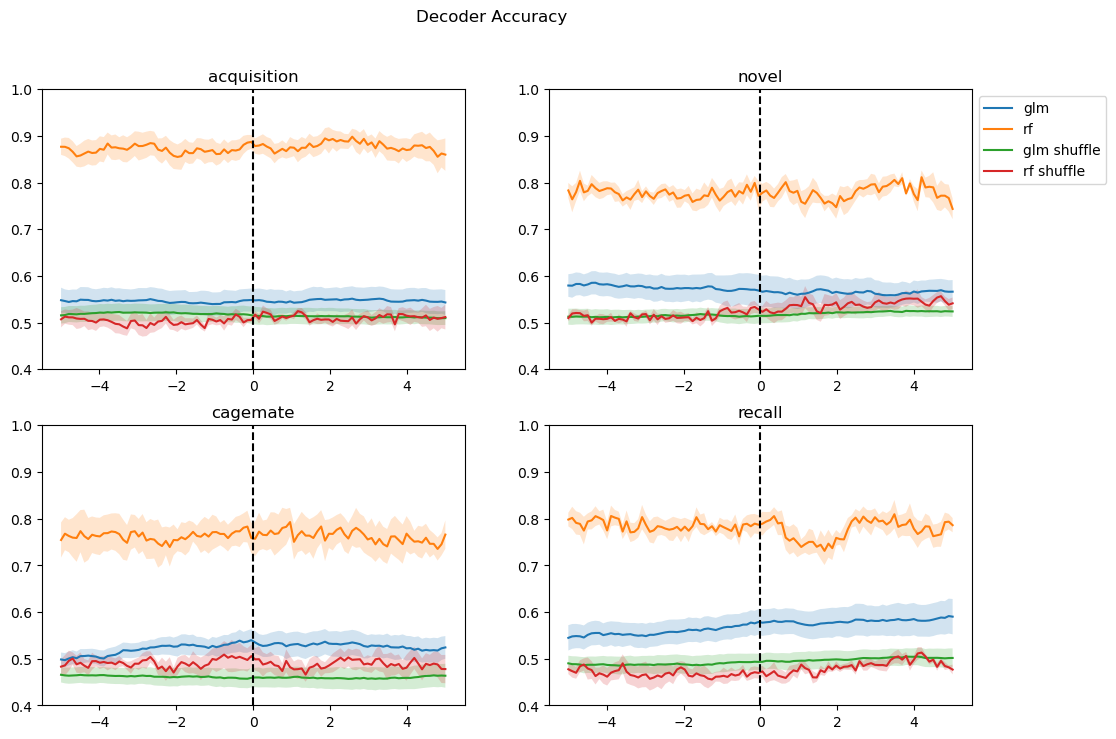

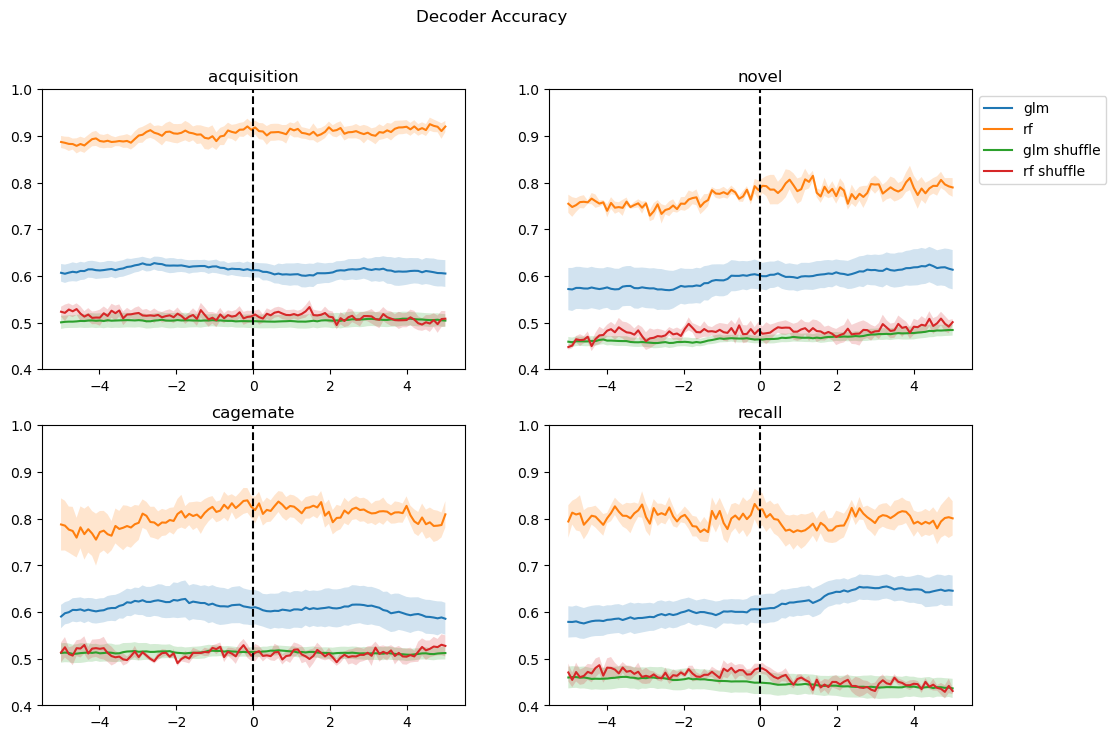

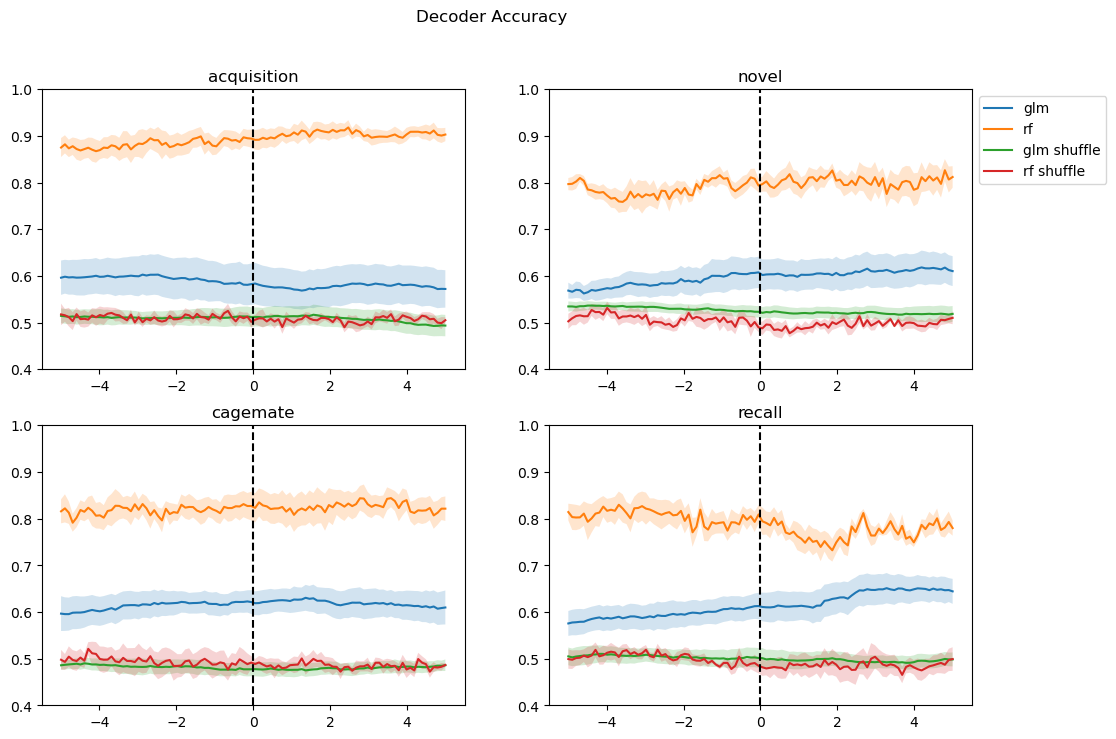

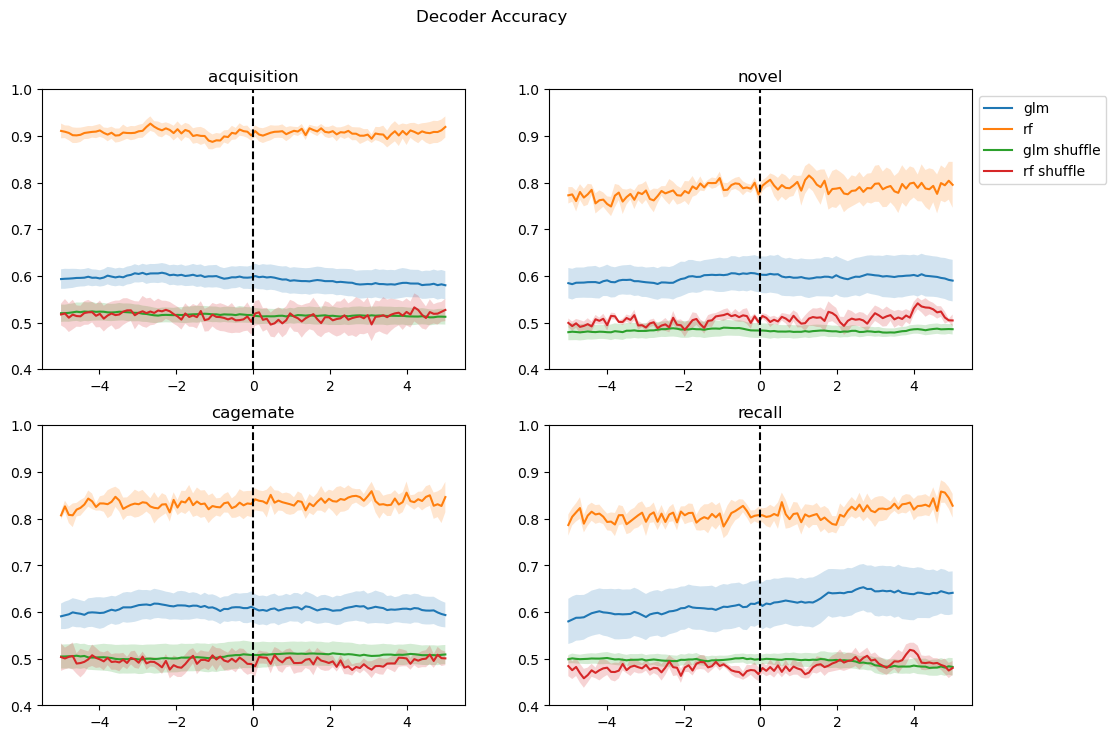

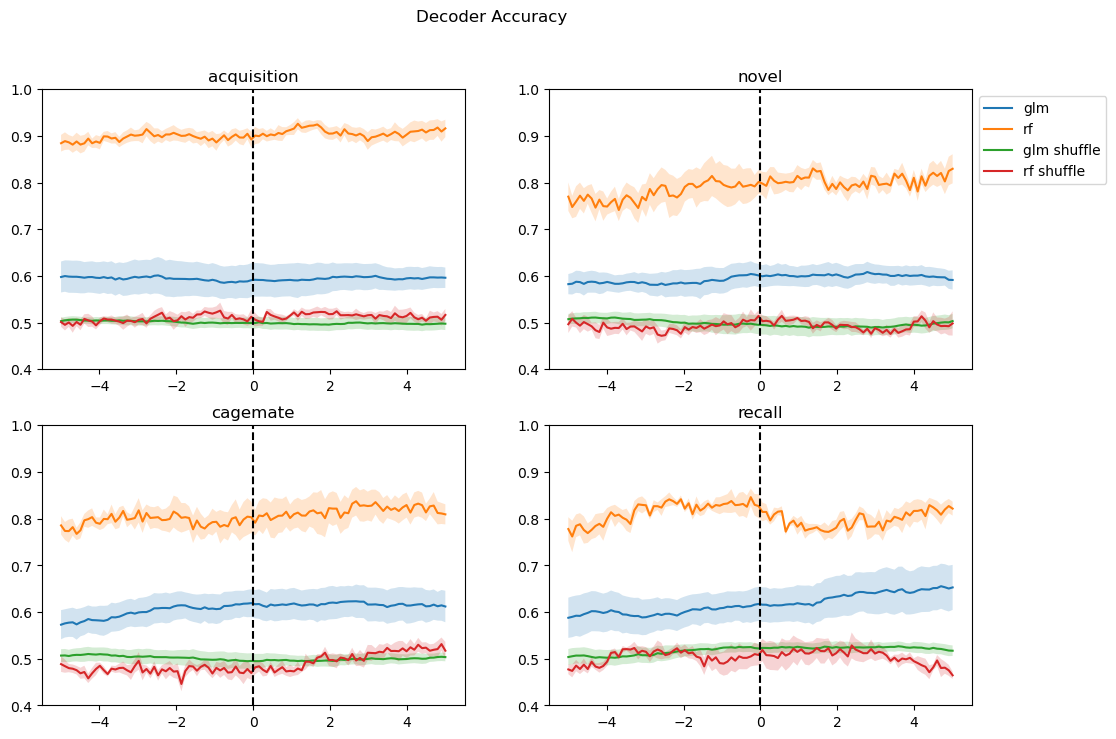

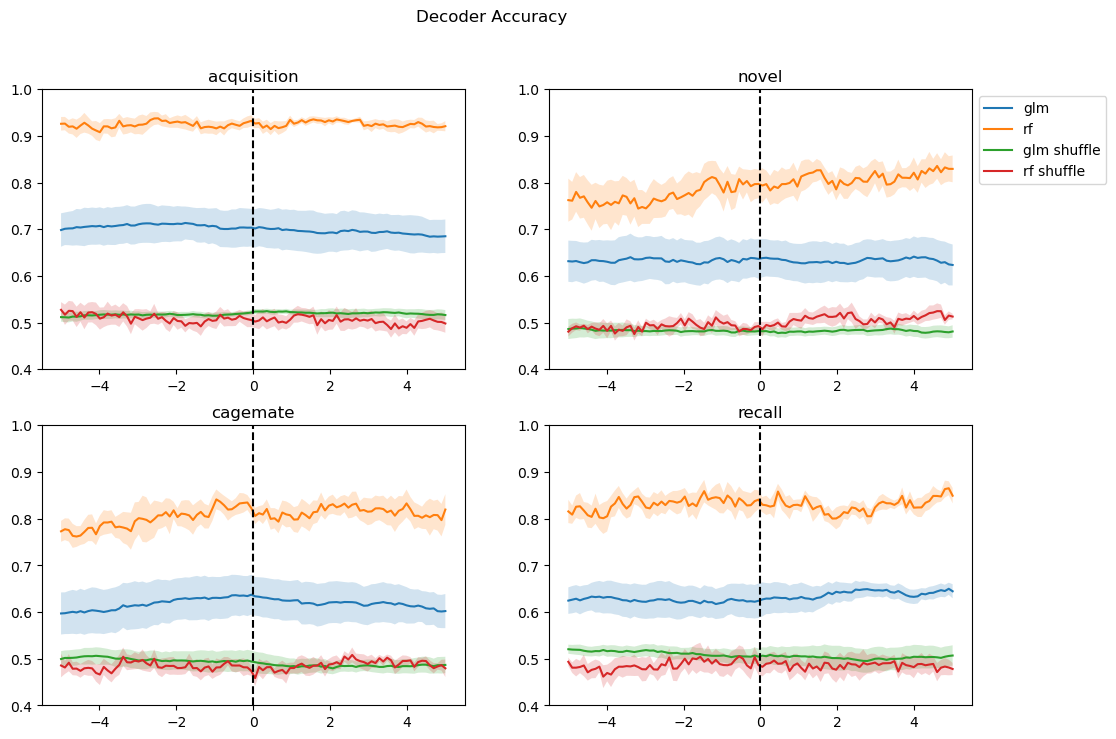

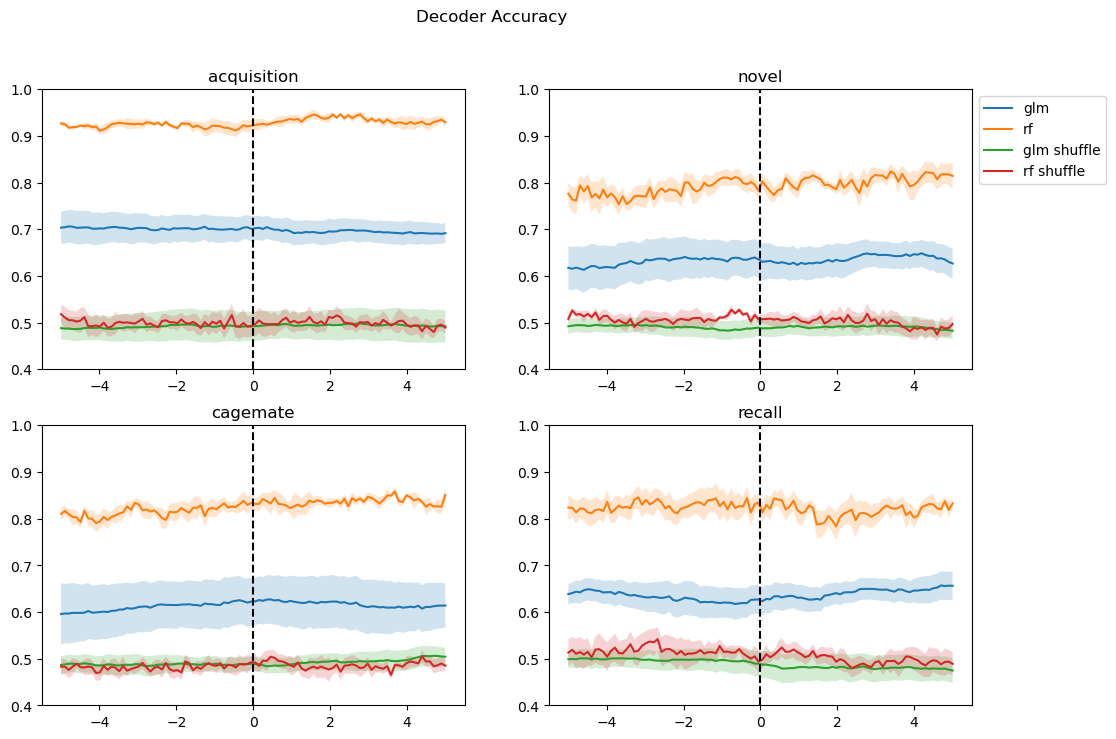

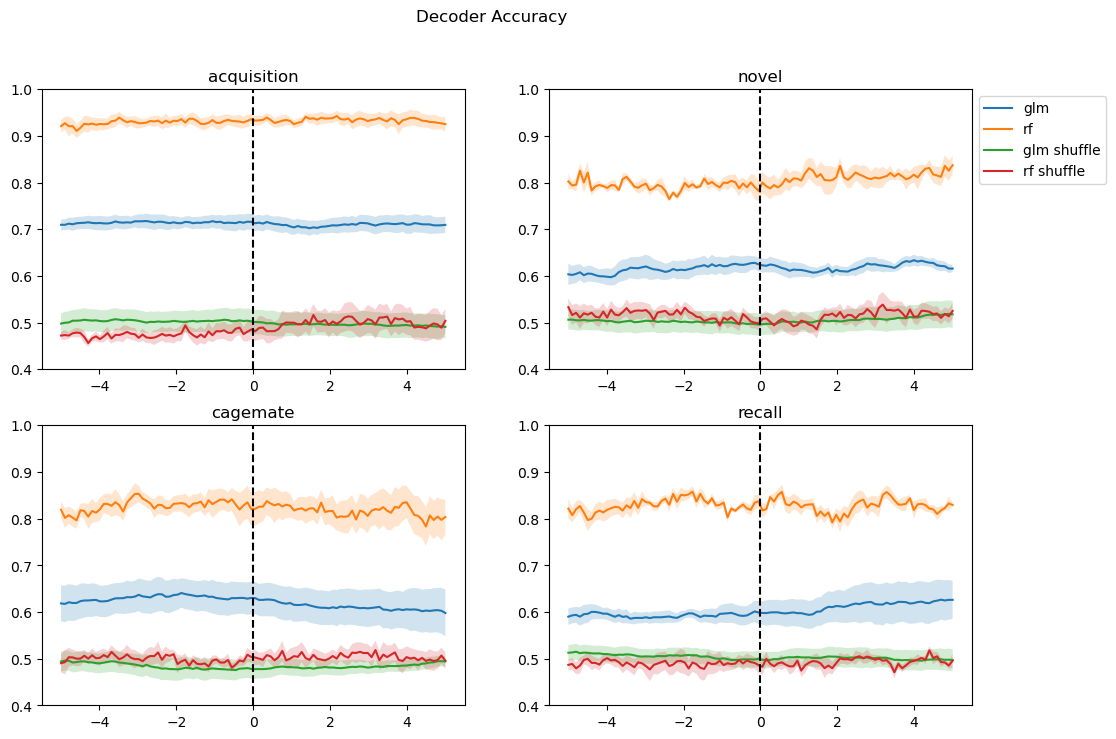

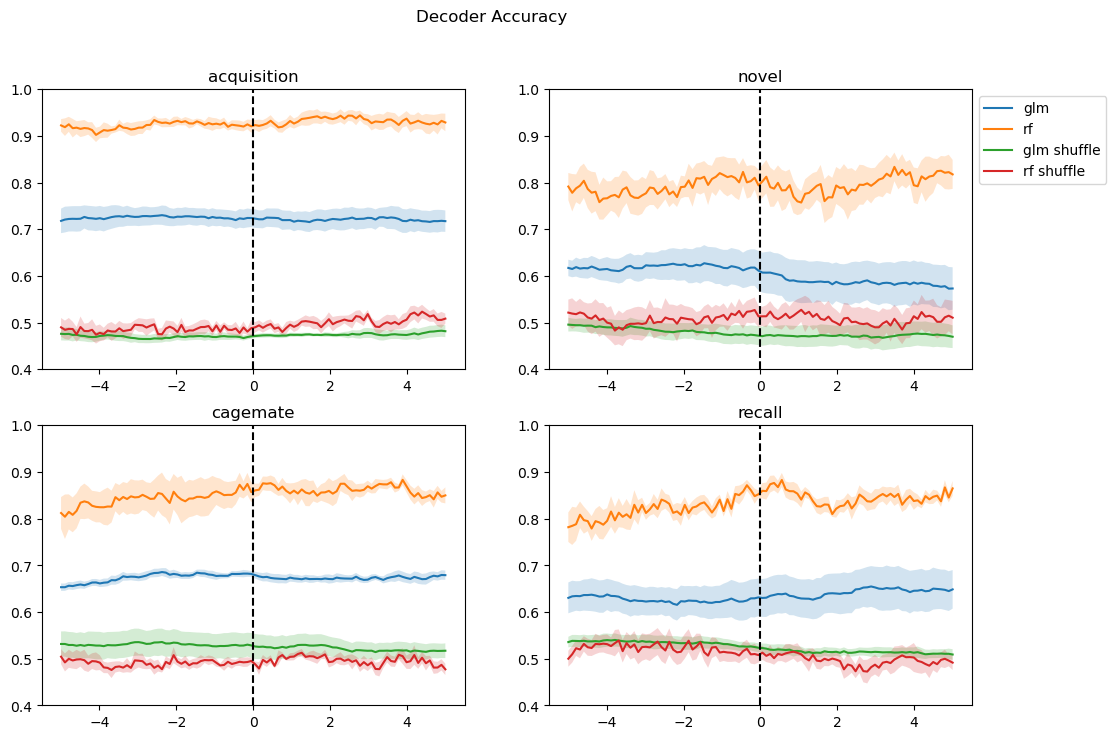

In [34]:
all_4_larger_timebins = {}
for pc in range(1,15):
        all_4_larger_timebins[pc] = decoder_tester.trial_decoder(equalize = 5, pre_window = 5, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= pc, events = ['acquisition', 'novel', 'cagemate', 'recall'])

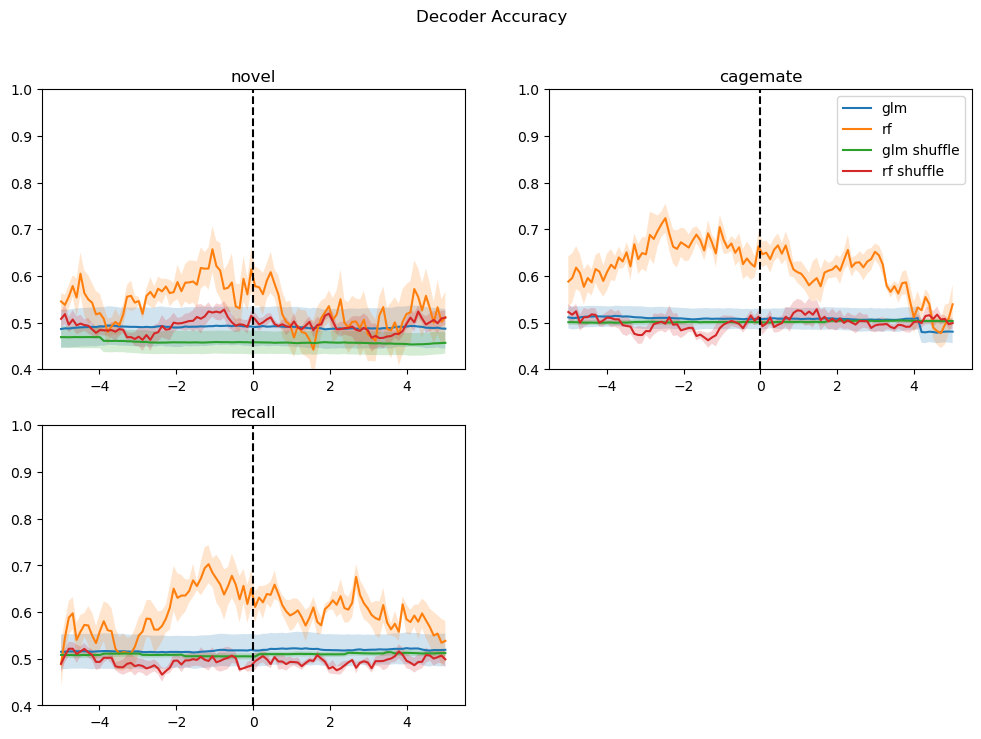

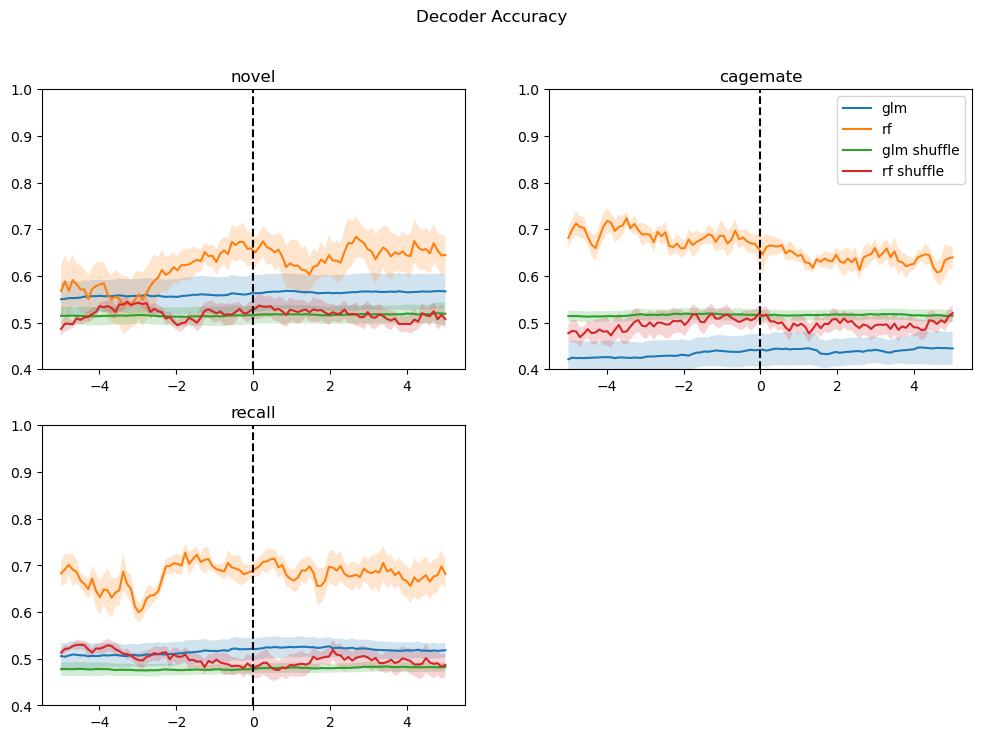

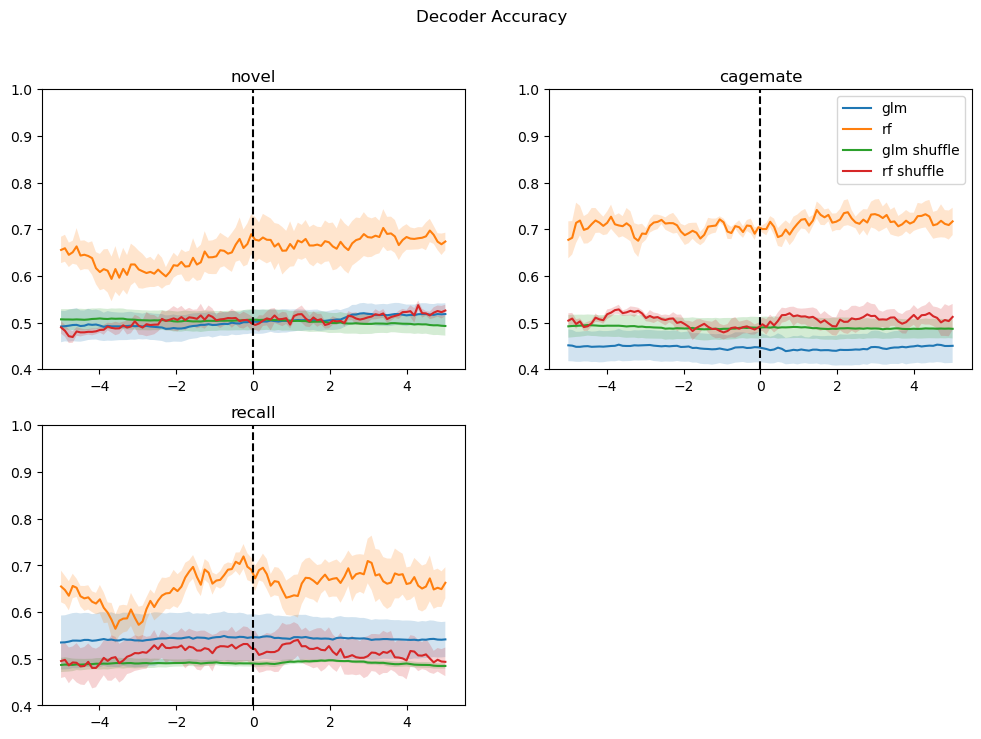

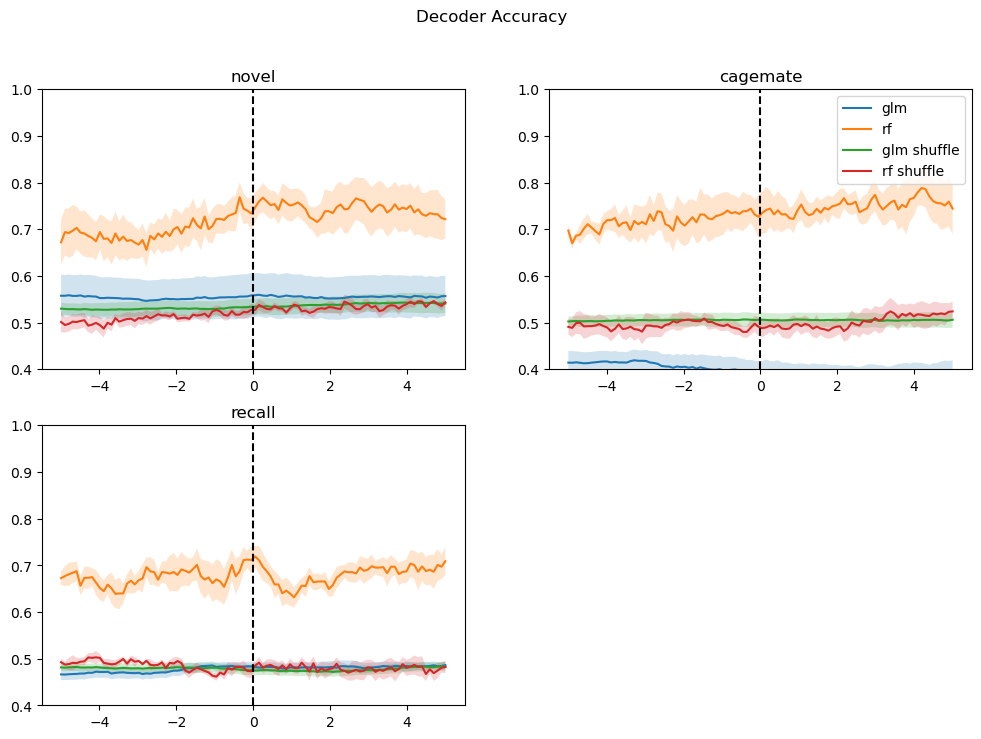

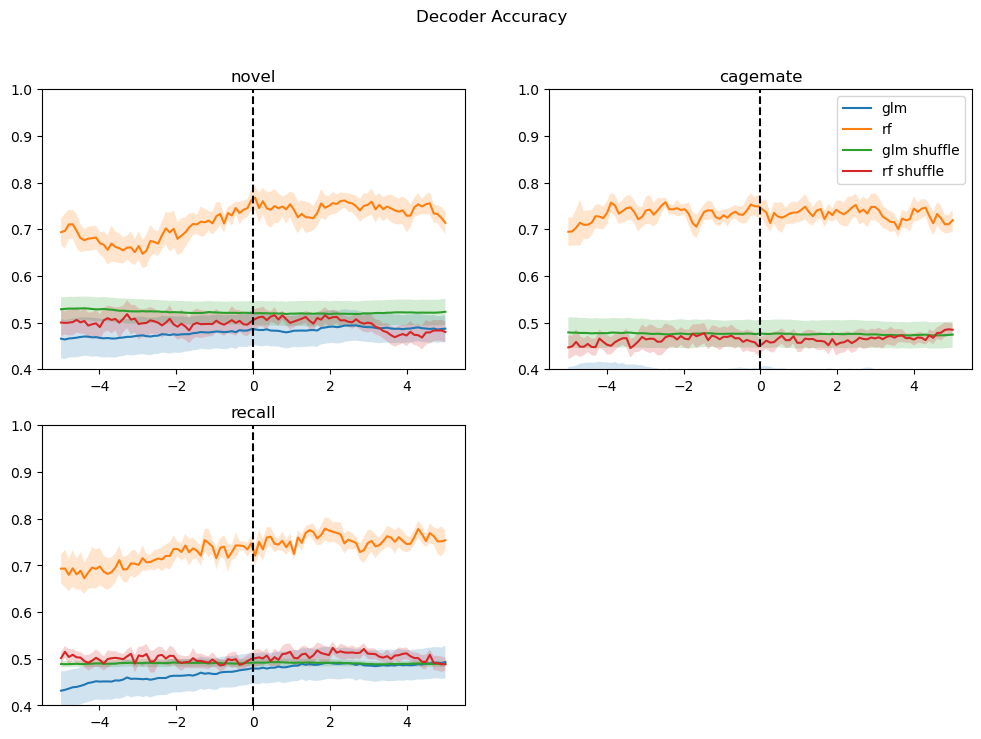

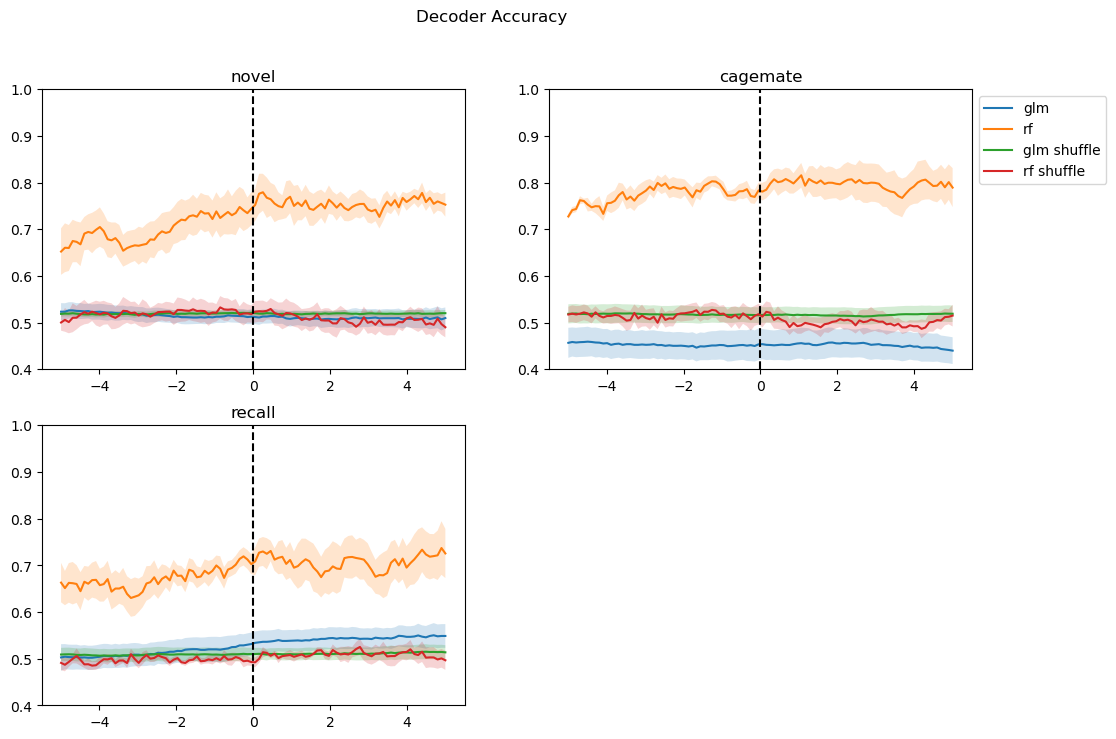

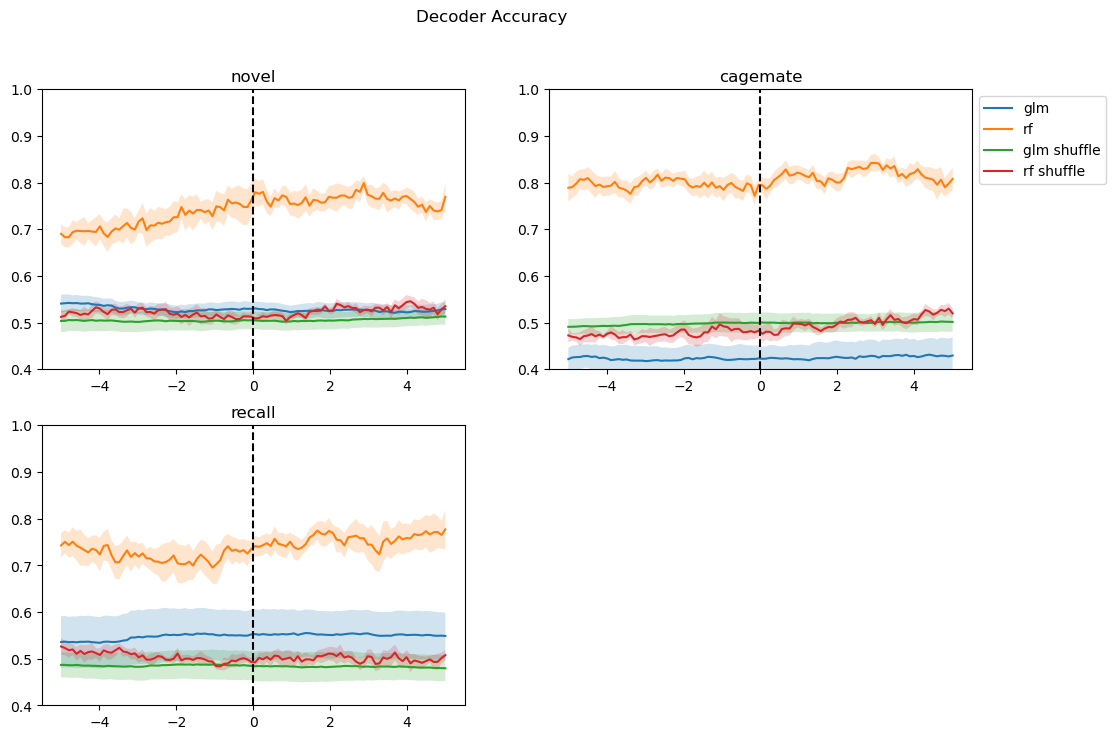

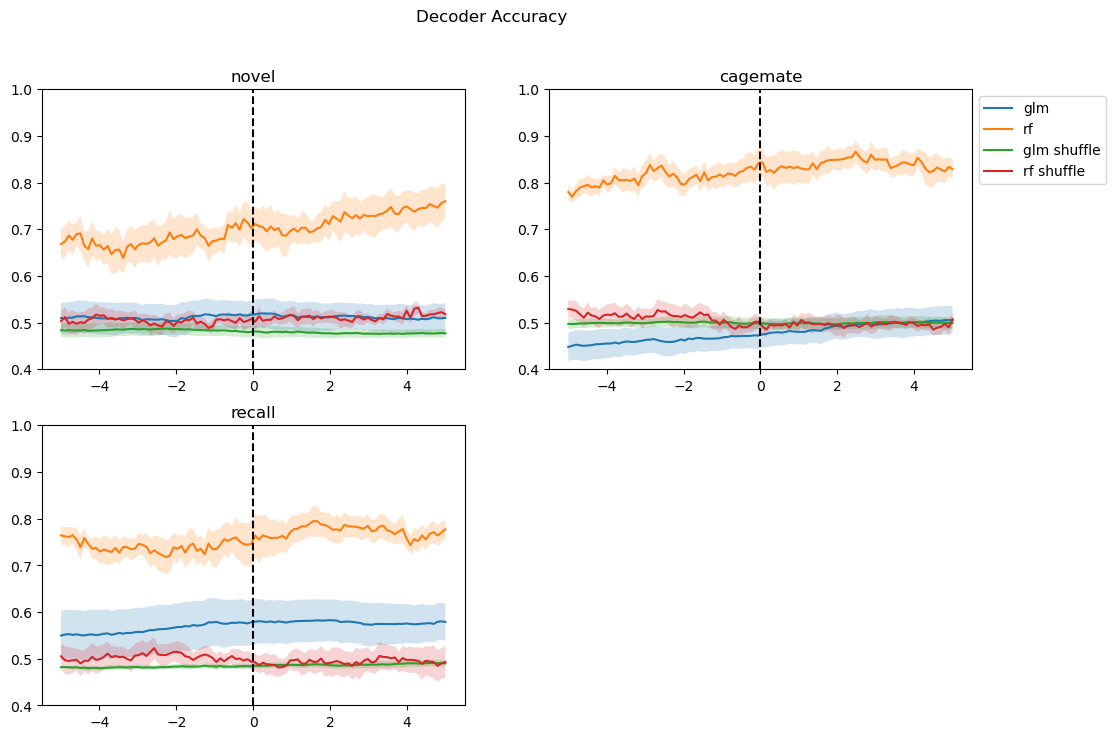

In [62]:
all_3_larger_timebins = {}
for pc in range(1,9):
        all_3_larger_timebins[pc] = decoder_tester.trial_decoder(equalize = 5, pre_window = 5, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= pc, events = ['novel', 'cagemate', 'recall'])

### Plotting across PCS

In [114]:
agents_three = across_pcs_auc(all_3_larger_timebins, 0, 3, 100, 5)

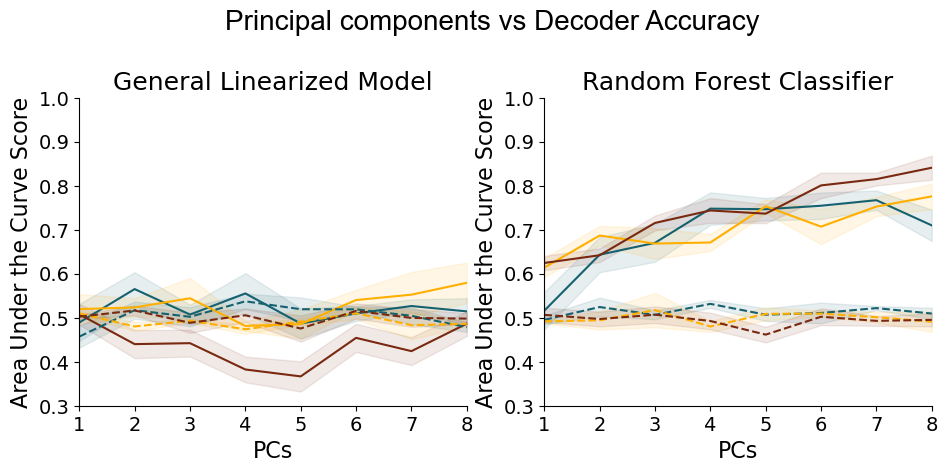

In [122]:

plt.figure(figsize=(11,4))
linestyle = ['-', '--','-', '--']
i = 0
subplots = [1,1,2,2]
for model in agents_three[1].keys():
    plt.subplot(1,2,subplots[i])
    novel_avg = []
    novel_sem = []
    cagemate_avg = []
    cagemate_sem = []
    familiar_avg = []
    familiar_sem = []
    for pc in agents_three.keys():
        novel_avg.append(np.mean(agents_three[pc][model]['novel'], axis = 0))
        novel_sem.append(sem(agents_three[pc][model]['novel']))
        cagemate_avg.append(np.mean(agents_three[pc][model]['cagemate'], axis = 0))
        cagemate_sem.append(sem(agents_three[pc][model]['cagemate']))
        familiar_avg.append(np.mean(agents_three[pc][model]['recall'], axis = 0))
        familiar_sem.append(sem(agents_three[pc][model]['recall']))
    x = list(agents_three.keys())
    plt.plot(x, novel_avg, label ='novel', color=hex_2_rgb('#15616F'), linestyle = linestyle[i])
    plt.fill_between(x, np.array(novel_avg)-np.array(novel_sem), np.array(novel_avg)+np.array(novel_sem),color=hex_2_rgb('#15616F'), alpha= alpha)
    plt.plot(x, familiar_avg, label = 'familiar', color = (1.0, 0.6862745098039216, 0.0), linestyle = linestyle[i])
    plt.fill_between(x, np.array(familiar_avg)-np.array(familiar_sem), np.array(familiar_avg)+np.array(familiar_sem), color = (1.0, 0.6862745098039216, 0.0), alpha = alpha)
    plt.plot(x, cagemate_avg, label = 'cagemate', color=hex_2_rgb('#792910'), linestyle = linestyle[i])
    plt.fill_between(x, np.array(cagemate_avg)-cagemate_sem, np.array(cagemate_avg)+np.array(cagemate_sem),color=hex_2_rgb('#792910'), alpha = alpha)
    plt.ylim(0.3, 1)
    plt.xlim(1,8)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('PCs', fontsize=16)
    plt.ylabel('Area Under the Curve Score', fontsize=16)
    plt.axvline(x=0, color='k', linestyle='--')
    if subplots[i] == 1:
        plt.title('General Linearized Model', fontsize = 18)
    else:
        plt.title('Random Forest Classifier', fontsize = 18)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    i +=1
plt.suptitle('Principal components vs Decoder Accuracy', fontsize = 20, font = 'Arial', y = 1.1)
plt.show()



In [94]:
collpased_pc_dict = across_pcs_auc(all_4_larger_timebins, 0, 3, 100, 5)


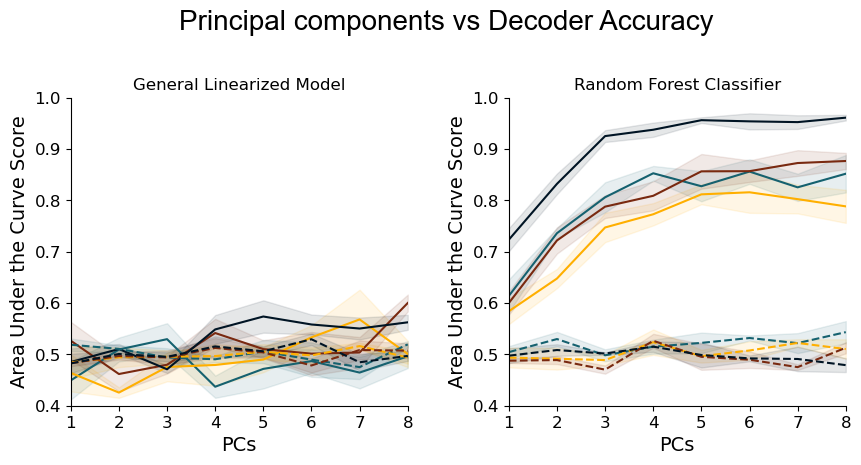

In [119]:
plt.figure(figsize=(10,4))
linestyle = ['-', '--','-', '--']
i = 0
subplots = [1,1,2,2]
for model in collpased_pc_dict[1].keys():
    plt.subplot(1,2,subplots[i])
    novel_avg = []
    novel_sem = []
    cagemate_avg = []
    cagemate_sem = []
    familiar_avg = []
    familiar_sem = []
    acquisition_avg = []
    acquisition_sem = []
    for pc in collpased_pc_dict.keys():
        novel_avg.append(np.mean(collpased_pc_dict[pc][model]['novel'], axis = 0))
        novel_sem.append(sem(collpased_pc_dict[pc][model]['novel']))
        cagemate_avg.append(np.mean(collpased_pc_dict[pc][model]['cagemate'], axis = 0))
        cagemate_sem.append(sem(collpased_pc_dict[pc][model]['cagemate']))
        familiar_avg.append(np.mean(collpased_pc_dict[pc][model]['recall'], axis = 0))
        familiar_sem.append(sem(collpased_pc_dict[pc][model]['recall']))
        acquisition_avg.append(np.mean(collpased_pc_dict[pc][model]['acquisition'], axis = 0))
        acquisition_sem.append(sem(collpased_pc_dict[pc][model]['acquisition']))
    x = list(collpased_pc_dict.keys())
    plt.plot(x, novel_avg, label ='novel', color=hex_2_rgb('#15616F'), linestyle = linestyle[i])
    plt.fill_between(x, np.array(novel_avg)-np.array(novel_sem), np.array(novel_avg)+np.array(novel_sem),color=hex_2_rgb('#15616F'), alpha= alpha)
    plt.plot(x, familiar_avg, label = 'familiar', color = (1.0, 0.6862745098039216, 0.0), linestyle = linestyle[i])
    plt.fill_between(x, np.array(familiar_avg)-np.array(familiar_sem), np.array(familiar_avg)+np.array(familiar_sem), color = (1.0, 0.6862745098039216, 0.0), alpha = alpha)
    plt.plot(x, cagemate_avg, label = 'cagemate', color=hex_2_rgb('#792910'), linestyle = linestyle[i])
    plt.fill_between(x, np.array(cagemate_avg)-cagemate_sem, np.array(cagemate_avg)+np.array(cagemate_sem),color=hex_2_rgb('#792910'), alpha = alpha)
    plt.plot(x, acquisition_avg, label = 'acquisition', color=hex_2_rgb('#001424'), linestyle = linestyle[i])
    plt.fill_between(x, np.array(acquisition_avg)-np.array(acquisition_sem), np.array(acquisition_avg)+np.array(acquisition_sem),color=hex_2_rgb('#001424'), alpha = alpha)
   
    plt.ylim(0.4, 1)
    plt.xlim(1,8)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('PCs', fontsize=14)
    plt.ylabel('Area Under the Curve Score', fontsize=14)
    plt.axvline(x=0, color='k', linestyle='--')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    if subplots[i] == 1:
        plt.title('General Linearized Model')
    else:
        plt.title('Random Forest Classifier')
    i +=1
plt.suptitle('Principal components vs Decoder Accuracy', fontsize = 20, font = 'Arial', y = 1.1)
plt.subplots_adjust(wspace=0.3)
plt.show()


### Fig1 a. results + plotting

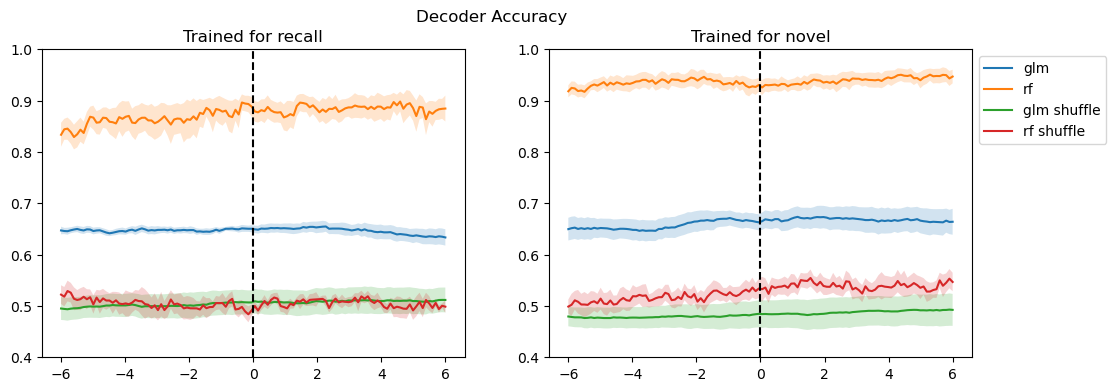

In [123]:
nov_acq_v_fam_auc = cross_trial_decoder(equalize = 6, pre_window = 6, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= 8, same_event='acquisition', event1='recall', event2='novel')    



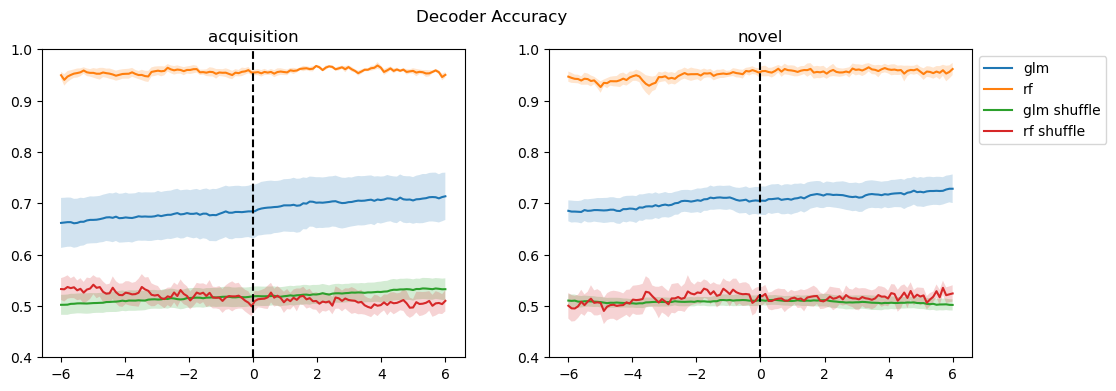

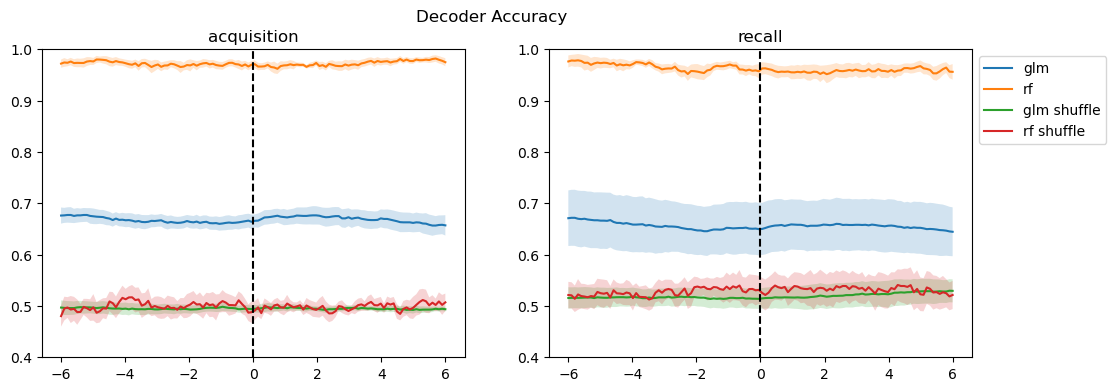

In [124]:
acq_vs_novel_baseline = phase2_analysis.trial_decoder(equalize = 6, pre_window = 6, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= 8, events = ['acquisition','novel'])
acq_vs_recall_baseline = phase2_analysis.trial_decoder(equalize = 6, pre_window = 6, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= 8, events = ['acquisition','recall'])

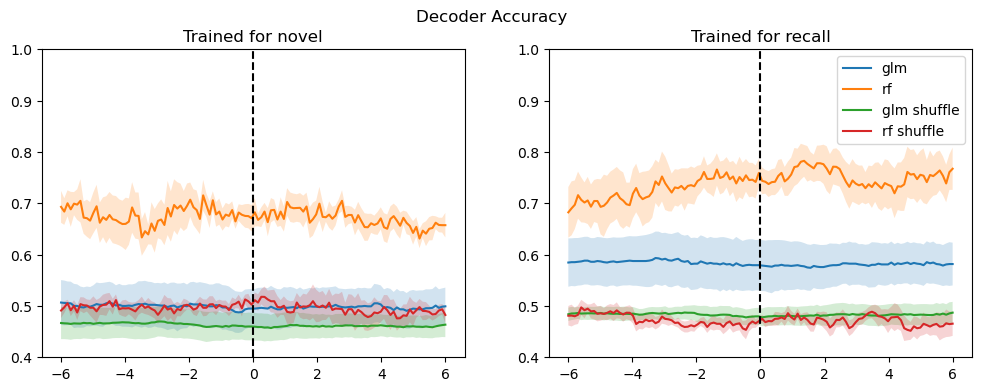

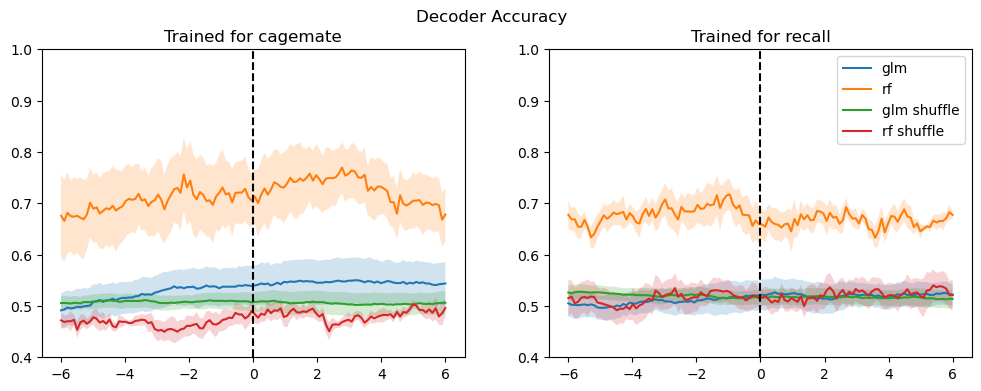

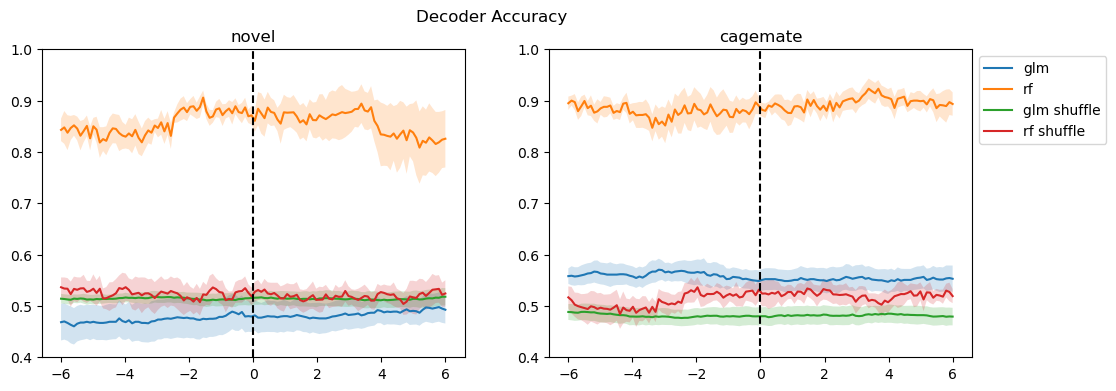

In [125]:
cagemate_v_other = cross_trial_decoder(equalize = 6, pre_window = 6, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= 8, same_event='cagemate', event1='novel', event2='recall')
novel_v_fam = cross_trial_decoder(equalize = 6, pre_window = 6, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= 8, same_event='novel', event1='cagemate', event2='recall')
novel_vs_cagemate_baseline = phase2_analysis.trial_decoder(equalize = 6, pre_window = 6, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= 8, events = ['novel','cagemate'])

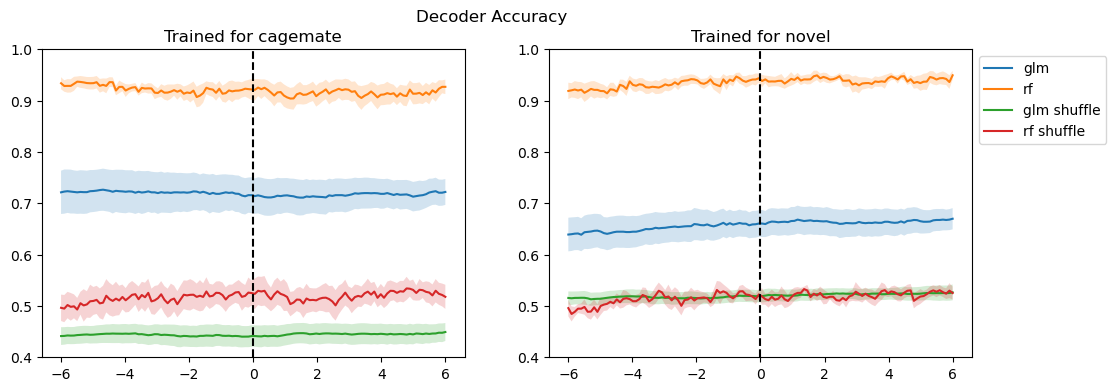

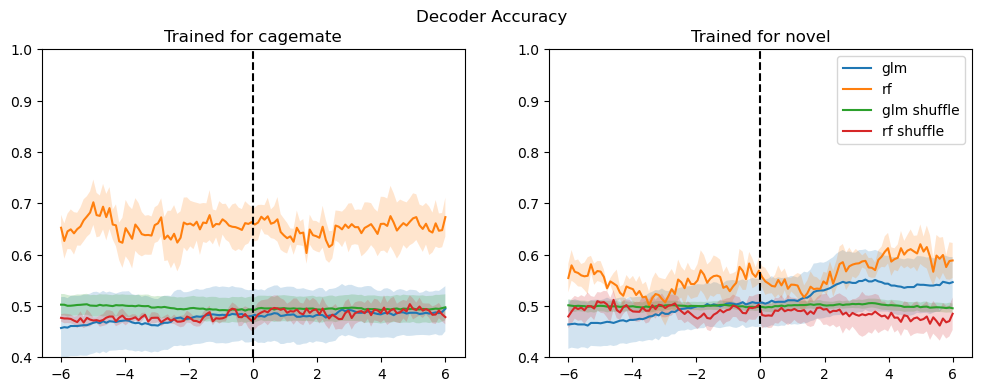

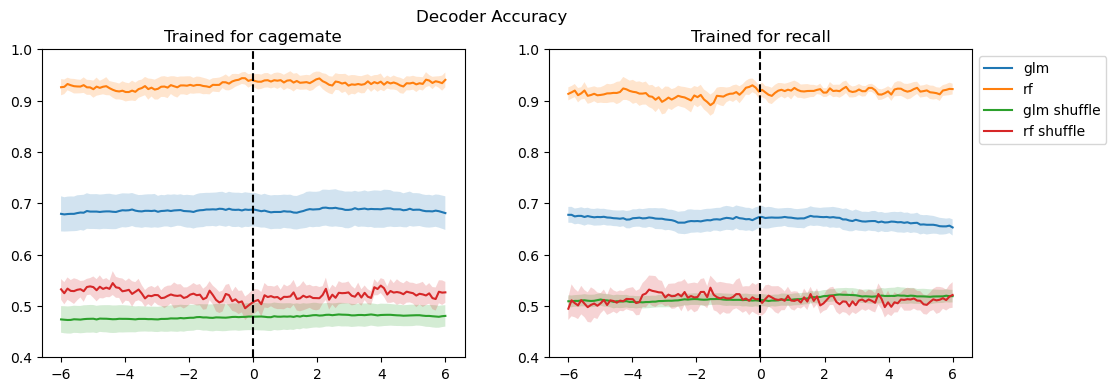

In [126]:
nov_acq_v_fam_auc = cross_trial_decoder(equalize = 6, pre_window = 6, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= 8, same_event='acquisition', event1='cagemate', event2='novel')
fam_v_other = cross_trial_decoder(equalize = 6, pre_window = 6, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= 8, same_event='recall', event1='cagemate', event2='novel')
acq_v_fam = cross_trial_decoder(equalize = 6, pre_window = 6, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= 8, same_event='acquisition', event1='cagemate', event2='recall')

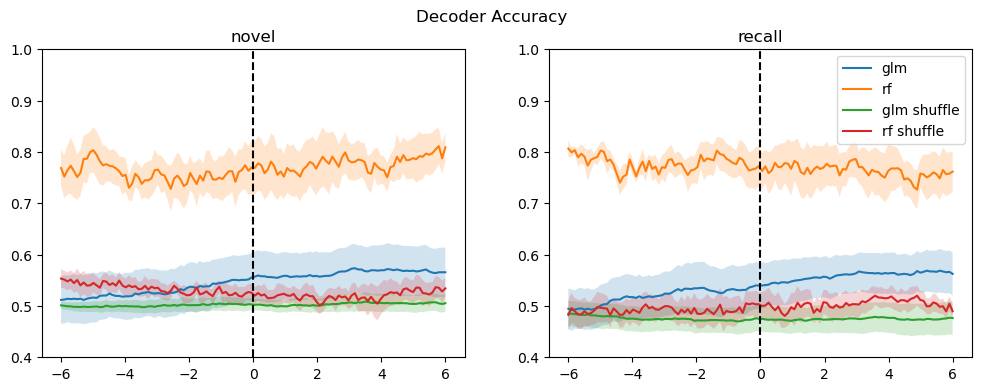

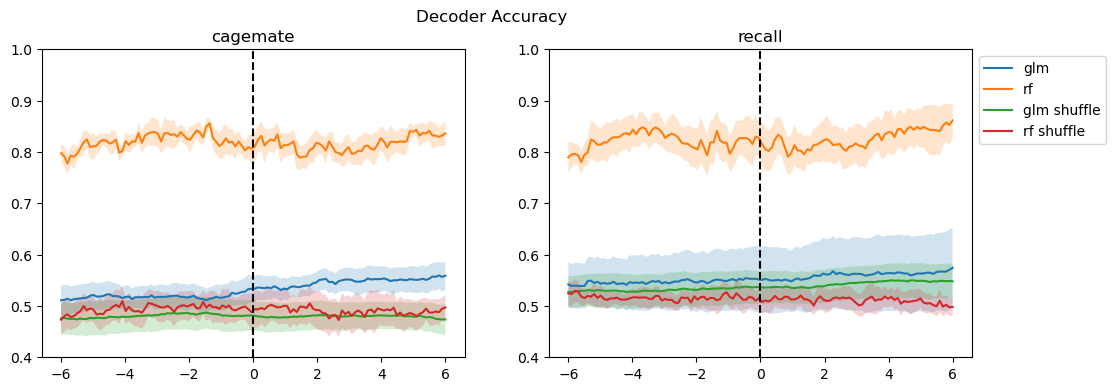

In [128]:
novel_vs_familiar_baseline = phase2_analysis.trial_decoder(equalize = 6, pre_window = 6, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= 8, events = ['novel','recall'])
cagemate_vs_familiar_baseline = phase2_analysis.trial_decoder(equalize = 6, pre_window = 6, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= 8, events = ['cagemate','recall'])


                                                                  Generalized\nLinear Model  \
novel vs long-term      short-term vs long-term   [1.5252240748163792, 0.20189395288516157]   
                        novel vs short-term        [0.10702459993535259, 0.919922520903188]   
short-term vs long-term novel vs short-term      [-0.9979864364886549, 0.37476631012770195]   

                                                                                  Shuffled   \
novel vs long-term      short-term vs long-term    [0.5142938624630515, 0.6341561749928368]   
                        novel vs short-term      [-1.1686247916352488, 0.30745093716340605]   
short-term vs long-term novel vs short-term       [-1.178161152722498, 0.30403684592151903]   

                                                                  Random Forest\nClassifier  \
novel vs long-term      short-term vs long-term  [6.7863554975990645, 0.002461585383926112]   
                        novel vs short-term     

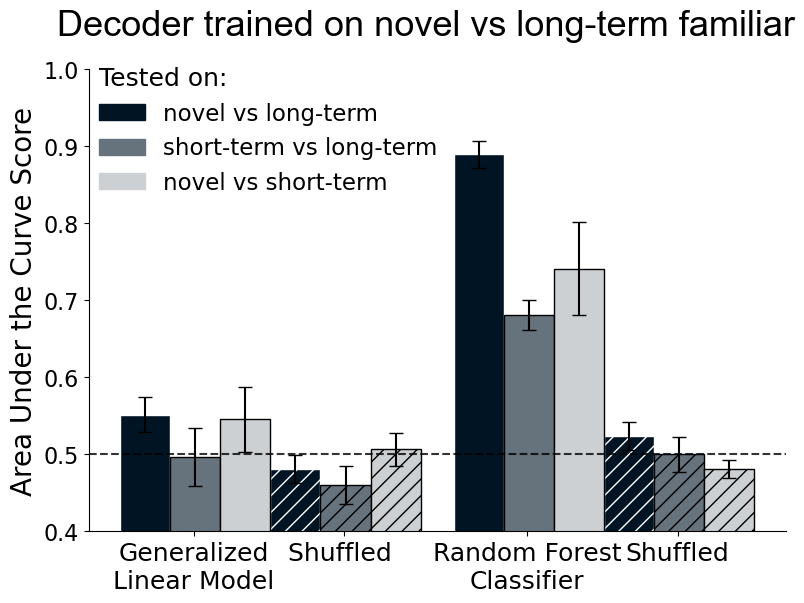

In [166]:


one_a_dict = {'novel vs long-term': novel_vs_cagemate_baseline['cagemate'], 
              'short-term vs long-term': cagemate_v_other['novel'],
              'novel vs short-term': novel_v_fam['cagemate']}

auc = one_a_dict
new_dict = collapsed_auc_dict(auc, 0, 3, 100, 6)
pre_window = 5
equalize = 5
avg_auc = {}
i = 1
no_plots = len(new_dict.keys())
height_fig = no_plots//2
categories = ['novel vs long-term', 'short-term vs long-term', 'novel vs short-term'] # Example categories
ttests = {}
for key in new_dict.keys():
    results = {}
    for pair in combinations(categories, 2):
        t_stat, p_value = ttest_rel(new_dict[key][pair[0]],new_dict[key][pair[1]])
        results[pair] = [t_stat, p_value]
    ttests[key] = results

ttess_df = pd.DataFrame.from_dict(ttests)

print(ttess_df)
avg_values = {category: [] for category in categories}
sem_values = {category: [] for category in categories}
for key in new_dict.keys():
    for category in categories:
        avg_values[category].append(np.mean(new_dict[key][category], axis=0))
        sem_values[category].append(sem(new_dict[key][category], axis=0))

bar_width = 0.3  # Width of each bar
x = np.arange(len(list(new_dict.keys())))  # x-axis positions
legend_labels = {category: [] for category in categories}
plt.figure(figsize=(9, 6))
col = [ hex_2_rgb('#001424'),hex_2_rgb('#66727c'), hex_2_rgb('#ccd0d3') ]
spacing = [0, -0.1, 0 , -0.1]
edge = ['white', 'black','black', 'black']
for i, category in enumerate(categories):
    positions = x + (i -0.3) * bar_width  # Adjust positions for each category
    alphas = [1, 1, 1, 1]
    hatches = ['','//','','//']
    for j, pos in enumerate(positions):
        bar = plt.bar(pos + spacing[j], avg_values[category][j], width=bar_width, yerr=sem_values[category][j],
                capsize=5, edgecolor=edge[i], alpha=alphas[j], label=category if i == 0 else '', color = col[i], hatch=hatches[j])
plt.ylim(0.4, 1)
plt.yticks(fontsize=16)
for i, color in enumerate(col):
    plt.plot([], [], color=color, label=categories[i], linewidth=5)  # Empty plots to create the legend
# Create handles for the legend (rectangles as pseudo bars)
legend_patches = [mpatches.Patch(color=col[i], label=categories[i]) for i in range(len(col))]
# Add the custom legend with rectangles as pseudo bars
legend = plt.legend(handles=legend_patches, fontsize = 16.5, frameon= False, bbox_to_anchor=(0.53,1.05), title = 'Tested on:')
legend.get_title().set_fontsize('18') 
legend.get_title().set_ha('left')
legend.get_title().set_position((-105, 1))
plt.xticks(x + spacing+0.2, new_dict.keys(), fontsize = 18)
plt.axhline(y=0.5, color='black', linestyle='--', alpha = 0.8)
plt.ylabel('Area Under the Curve Score', fontsize=20)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.suptitle('Decoder trained on novel vs long-term familiar', fontsize = 26, font = 'Arial')
plt.subplots_adjust(hspace=0.5)
plt.show()

                                                                   Generalized\nLinear Model  \
novel vs long-term      short-term vs long-term    [0.24608820523279307, 0.8177260065471438]   
                        novel vs short-term      [-0.011712034499087512, 0.9912162251416916]   
short-term vs long-term novel vs short-term         [-0.296654329957612, 0.7814963625930041]   

                                                                                 Shuffled   \
novel vs long-term      short-term vs long-term  [0.04105968849308199, 0.9692160448531656]   
                        novel vs short-term      [0.24504222846249427, 0.8184816855289958]   
short-term vs long-term novel vs short-term      [0.13013532757261614, 0.9027413348234489]   

                                                                 Random Forest\nClassifier  \
novel vs long-term      short-term vs long-term   [2.9396983049461713, 0.0424018728008069]   
                        novel vs short-term      [

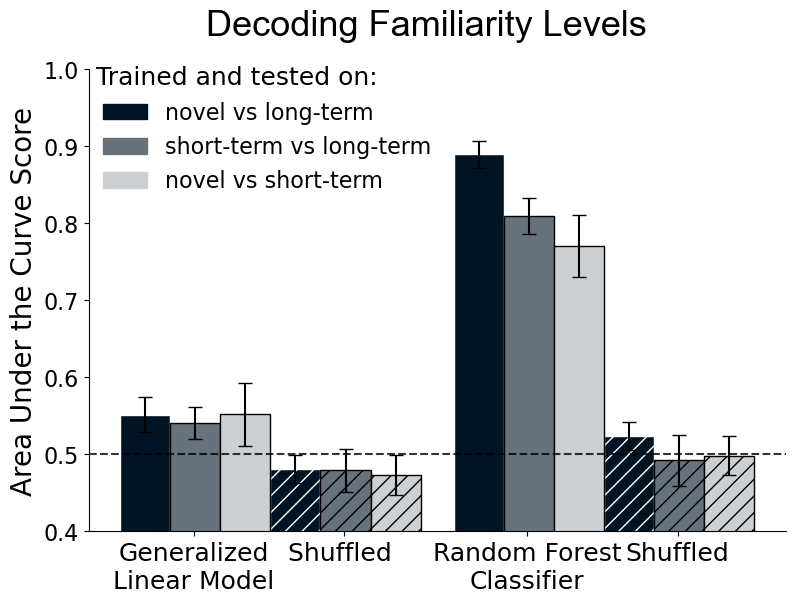

In [176]:
one_a_dict_baselines = {'novel vs long-term': novel_vs_cagemate_baseline['cagemate'], 
              'short-term vs long-term': cagemate_vs_familiar_baseline ['cagemate'],
              'novel vs short-term': novel_vs_familiar_baseline['recall']}

auc = one_a_dict_baselines
new_dict = collapsed_auc_dict(auc, 0, 3, 100, 6)

from scipy.stats import ttest_rel
import matplotlib.patches as mpatches
pre_window = 5
equalize = 5
avg_auc = {}
i = 1
no_plots = len(new_dict.keys())
height_fig = no_plots//2
categories = ['novel vs long-term', 'short-term vs long-term', 'novel vs short-term'] # Example categories
ttests = {}
for key in new_dict.keys():
    results = {}
    for pair in combinations(categories, 2):
        t_stat, p_value = ttest_rel(new_dict[key][pair[0]],new_dict[key][pair[1]])
        results[pair] = [t_stat, p_value]
    ttests[key] = results

ttess_df = pd.DataFrame.from_dict(ttests)

print(ttess_df)
avg_values = {category: [] for category in categories}
sem_values = {category: [] for category in categories}
for key in new_dict.keys():
    for category in categories:
        avg_values[category].append(np.mean(new_dict[key][category], axis=0))
        sem_values[category].append(sem(new_dict[key][category], axis=0))

bar_width = 0.3  # Width of each bar
x = np.arange(len(list(new_dict.keys())))  # x-axis positions
legend_labels = {category: [] for category in categories}
plt.figure(figsize=(9, 6))
col = [ hex_2_rgb('#001424'),hex_2_rgb('#66727c'), hex_2_rgb('#ccd0d3') ]
spacing = [0, -0.1, 0 , -0.1]
edge = ['white', 'black','black', 'black']
for i, category in enumerate(categories):
    positions = x + (i -0.3) * bar_width  # Adjust positions for each category
    alphas = [1, 1, 1, 1]
    hatches = ['','//','','//']
    for j, pos in enumerate(positions):
        bar = plt.bar(pos + spacing[j], avg_values[category][j], width=bar_width, yerr=sem_values[category][j],
                capsize=5, edgecolor = edge[i], alpha=alphas[j], hatch = hatches[j], label=category if i == 0 else '', color = col[i])
plt.ylim(0.4, 1)
plt.yticks(fontsize=16)
for i, color in enumerate(col):
    plt.plot([], [], color=color, label=categories[i], linewidth=5)  # Empty plots to create the legend

# Create handles for the legend (rectangles as pseudo bars)
legend_patches = [mpatches.Patch(color=col[i], label=categories[i]) for i in range(len(col))]

# Add the custom legend with rectangles as pseudo bars
legend = plt.legend(handles=legend_patches, fontsize = 16, frameon= False, bbox_to_anchor=(0.52,1.05), title = 'Trained and tested on:')
legend.get_title().set_fontsize('18') 
legend.get_title().set_ha('left')
legend.get_title().set_position((-30, 1))
plt.xticks(x + spacing+0.2, new_dict.keys(), fontsize = 18)
plt.axhline(y=0.5, color='black', linestyle='--', alpha = 0.8)
plt.ylabel('Area Under the Curve Score', fontsize=20)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.suptitle('Decoding Familiarity Levels', fontsize = 26, font = 'Arial')
plt.subplots_adjust(hspace=0.5)
plt.show()

### Fig1b. results and plotting

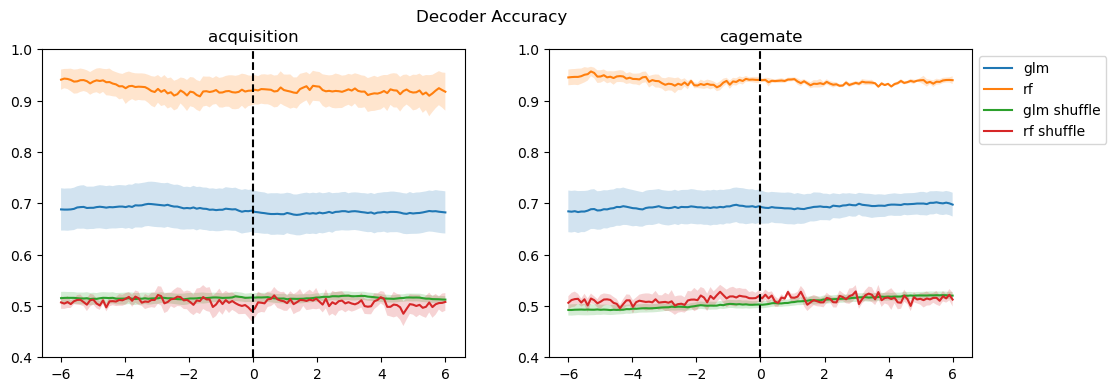

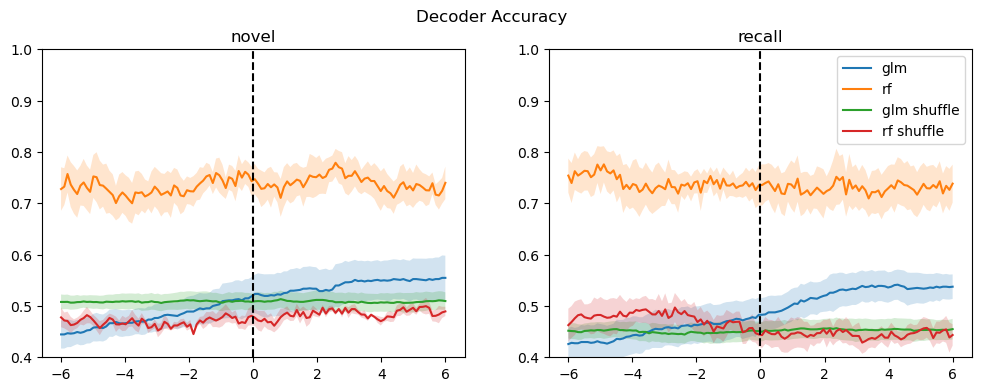

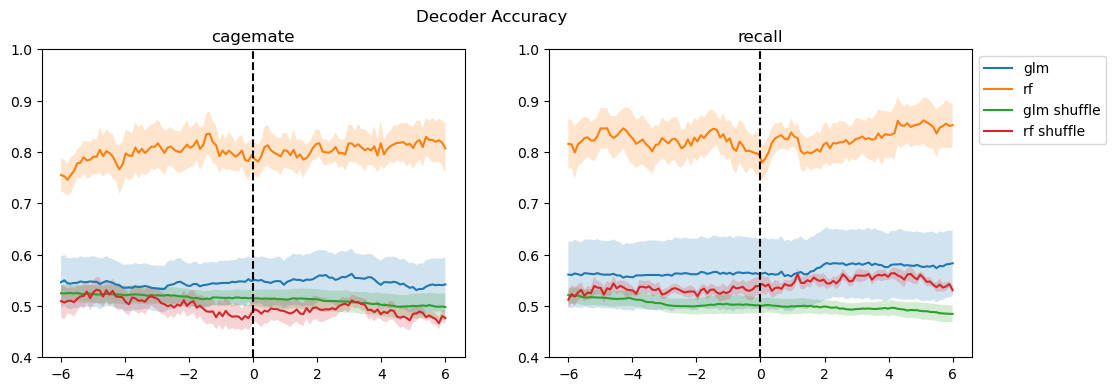

In [127]:
acq_vs_cagemate_baseline = phase2_analysis.trial_decoder(equalize = 6, pre_window = 6, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= 8, events = ['acquisition','cagemate'])
novel_vs_familiar_baseline = phase2_analysis.trial_decoder(equalize = 6, pre_window = 6, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= 8, events = ['novel','recall'])
cagemate_vs_familiar_baseline = phase2_analysis.trial_decoder(equalize = 6, pre_window = 6, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= 8, events = ['cagemate','recall'])





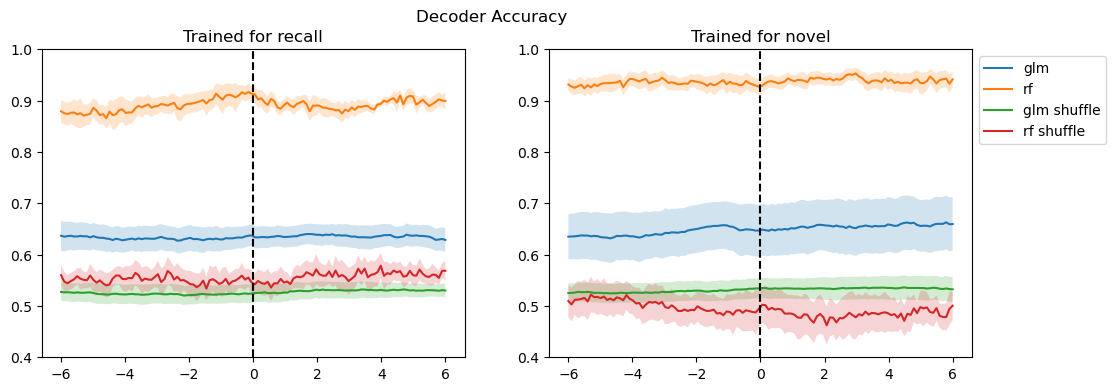

In [177]:
nov_acq_v_recall_auc = cross_trial_decoder(equalize = 6, pre_window = 6, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= 8, same_event='acquisition', event1='recall', event2='novel')


In [ ]:
acq_vs_novel_baseline
acq_vs_recall_baseline
acq_vs_cagemate_baseline
nov_acq_v_recall_auc (acq v (recall/novel) )
acq_v_fam (acq v (cagemate/fam))
nov_acq_v_fam_auc (acw v (cagemate/novel))

In [179]:
one_b_dict_acq_fam = {'acquisition vs short-term': acq_vs_recall_baseline['acquisition'], 
              'acquisition vs novel': nov_acq_v_recall_auc['recall'],
              'acquisition vs long-term': acq_v_fam['recall']}

one_b_dict_acq_cagemate = {'acquisition vs long-term': acq_vs_cagemate_baseline['acquisition'], 
              'acquisition vs novel': nov_acq_v_fam_auc['cagemate'],
              'acquisition vs short-term': acq_v_fam['cagemate']}

one_b_dict_acq_nov = {'acquisition vs novel': acq_vs_novel_baseline['acquisition'], 
              'acquisition vs short-term': nov_acq_v_recall_auc['novel'],  
              'acquisition vs long-term': nov_acq_v_fam_auc['novel']}

one_b_baselines = {'acquisition vs novel': acq_vs_novel_baseline['acquisition'],
                    'acquisition vs short-term': acq_vs_recall_baseline['acquisition'],
                    'acquisition vs long-term': acq_vs_cagemate_baseline['acquisition']}


one_b_results = [one_b_dict_acq_fam, one_b_dict_acq_nov, one_b_dict_acq_cagemate, one_b_baselines]
collapsed_one_b_results = []
for auc in one_b_results:
    collapsed_one_b_results.append(collapsed_auc_dict(auc, 0, 3, 100, 6))





In [187]:
for one_bdict in collapsed_one_b_results:
    print(one_bdict['Shuffled'].keys())

dict_keys(['acquisition vs short-term', 'acquisition vs novel', 'acquisition vs long-term'])
dict_keys(['acquisition vs novel', 'acquisition vs short-term', 'acquisition vs long-term'])
dict_keys(['acquisition vs long-term', 'acquisition vs novel', 'acquisition vs short-term'])
dict_keys(['acquisition vs novel', 'acquisition vs short-term', 'acquisition vs long-term'])


In [ ]:
i = 1
no_plots = len(new_dict.keys())
height_fig = no_plots//2
categories = ['novel vs long-term', 'short-term vs long-term', 'novel vs short-term'] # Example categories
ttests = {}
for key in new_dict.keys():
    results = {}
    for pair in combinations(categories, 2):
        t_stat, p_value = ttest_rel(new_dict[key][pair[0]],new_dict[key][pair[1]])
        results[pair] = [t_stat, p_value]
    ttests[key] = results

ttess_df = pd.DataFrame.from_dict(ttests)

print(ttess_df)
avg_values = {category: [] for category in categories}
sem_values = {category: [] for category in categories}
for key in new_dict.keys():
    for category in categories:
        avg_values[category].append(np.mean(new_dict[key][category], axis=0))
        sem_values[category].append(sem(new_dict[key][category], axis=0))

bar_width = 0.3  # Width of each bar
x = np.arange(len(list(new_dict.keys())))  # x-axis positions
legend_labels = {category: [] for category in categories}
plt.figure(figsize=(9, 6))
col = [ hex_2_rgb('#001424'),hex_2_rgb('#66727c'), hex_2_rgb('#ccd0d3') ]
spacing = [0, -0.1, 0 , -0.1]
edge = ['white', 'black','black', 'black']
for i, category in enumerate(categories):
    positions = x + (i -0.3) * bar_width  # Adjust positions for each category
    alphas = [1, 1, 1, 1]
    hatches = ['','//','','//']
    for j, pos in enumerate(positions):
        bar = plt.bar(pos + spacing[j], avg_values[category][j], width=bar_width, yerr=sem_values[category][j],
                capsize=5, edgecolor = edge[i], alpha=alphas[j], hatch = hatches[j], label=category if i == 0 else '', color = col[i])
plt.ylim(0.4, 1)
plt.yticks(fontsize=16)
for i, color in enumerate(col):
    plt.plot([], [], color=color, label=categories[i], linewidth=5)  # Empty plots to create the legend

# Create handles for the legend (rectangles as pseudo bars)
legend_patches = [mpatches.Patch(color=col[i], label=categories[i]) for i in range(len(col))]

# Add the custom legend with rectangles as pseudo bars
legend = plt.legend(handles=legend_patches, fontsize = 18, frameon= False, bbox_to_anchor=(0.58,1.05), title = 'Trained and tested on:')
legend.get_title().set_fontsize('18') 
legend.get_title().set_ha('left')
legend.get_title().set_position((-40, 1))
plt.xticks(x + spacing+0.2, new_dict.keys(), fontsize = 18)
plt.axhline(y=0.5, color='black', linestyle='--', alpha = 0.8)
plt.ylabel('Area Under the Curve Score', fontsize=20)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.suptitle('Decoding Familiarity Levels', fontsize = 26, font = 'Arial')
plt.subplots_adjust(hspace=0.5)
plt.show()

In [ ]:
aucs = [all_4, acq_nov, acq_fam]
with open('auc_collection_phase2.pkl', 'wb') as file:
    pickle.dump(aucs, file)

In [ ]:
with open('auc_collection_phase2.pkl', 'rb') as file:
    auc_collection = pickle.load(file)

In [ ]:
auc_,aster_collection_250sw_100tb = [acq_vs_cagemate_baseline, acq_vs_novel_baselinewindow, 
acq_vs_recall_baseline, novel_vs_cagemate_baseline,
novel_vs_familiar_baseline, cagemate_vs_novel_baseline, cagemate_vs_familiar_baseline,
recall_vs_cagemate_baseline, recall_vs_novel_baseline, nov_acq_v_fam_auc, novel_v_fam, cagemate_v_other, fam_v_other,
acq_v_fam, nov_acq_v_fam_auc, acq_nov, acq_fam, all_3_larger_timebins, all_4_larger_timebins ]
with open('250sw_100tb_auc_collection', 'wb') as file:
    pickle.dump(auc_,aster_collection_250sw_100tb, file)

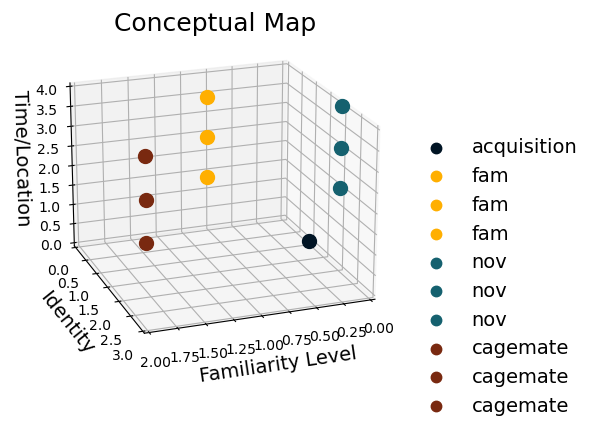

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
#familiarity x identity x time/location
acquisition = [0, 1, 0]

familiar_1 = [1, 1, 2]
familiar_2 = [1, 1, 3]
familiar_3 = [1, 1, 4]

novel_1 = [0, 2, 2] 
novel_2 = [0, 2, 3] 
novel_3 = [0, 2, 4] 

cagemate_1 = [2, 3, 2]
cagemate_2 = [2, 3, 3]
cagemate_3 = [2, 3, 4]
points = [acquisition, familiar_1, familiar_2, familiar_3, novel_1, novel_2, novel_3, cagemate_1, cagemate_2, cagemate_3]
labels = ['acquisition', 'fam', 'fam', 'fam', 'nov', 'nov', 'nov', 'cagemate', 'cagemate', 'cagemate']
color_fam = {'cagemate': hex_2_rgb('#792910'), 'fam': (1.0, 0.6862745098039216, 0.0), 
             'nov': hex_2_rgb('#15616F'), 'acquisition': hex_2_rgb('#001424')}
for point in range(len(points)):
    ax.scatter(points[point][0], points[point][1], points[point][2], label= labels[point], color = color_fam[labels[point]], s=100)
ax.legend(loc="upper left", bbox_to_anchor=(1, .70), frameon = False, fontsize = 14, markerscale = .75)
ax.set_xlabel("Familiarity Level", fontsize = 14)
ax.set_ylabel("Identity", fontsize = 14)
ax.set_zlabel("Time/Location", fontsize = 14)
ax.view_init(azim = 70, elev = 20
    )
ax.set_xlim(0, 2)
ax.set_ylim(0, 3)
ax.set_zlim(0, 4)
plt.title('Conceptual Map', fontsize = 18, y = 1, x = .5)
plt.show()

In [ ]:

glm = {}
glm_shuffle = {}
rf = {}
rf_shuffle = {}
for key in auc_8session.keys():
    glm[key] =auc_8session[key]['glm']
    rf[key] =auc_8session[key]['rf']
    glm_shuffle_temp = []
    rf_shuffle_temp = []
    for i in range(5):
        glm_shuffle_temp.append(auc[key]['glm_shuffle'][i])
        rf_shuffle_temp.append(auc[key]['rf_shuffle'][i])
    glm_shuffle[key] = np.array(glm_shuffle_temp).reshape(25,100)
    rf_shuffle[key] = np.array(rf_shuffle_temp).reshape(25,100)
model_dict = {'Generalized Linear Model':glm, 'Random Forest Classifier':rf,
              'Generalized Linear Model\nSHUFFLED':glm_shuffle, 
              'Random Forest Classifier\nSHUFFLED':rf_shuffle}
pre_window = 5
equalize = 5
avg_auc = {}
no_plots = len(model_dict.keys())
height_fig = math.ceil(no_plots/2)
i = 1
alpha = 0.1
plt.figure(figsize=(10,4*height_fig))
plt.figure(figsize=(10,4))
for key in ['Generalized Linear Model', 'Random Forest Classifier']:
    novel_avg = np.mean(model_dict[key]['novel'], axis = 0)
    novel_sem = sem(model_dict[key]['novel'], axis = 0)
    x =np.linspace(-pre_window, equalize, len(novel_avg))
    cagemate_avg = np.mean(model_dict[key]['cagemate'], axis = 0)
    cagemate_sem = sem(model_dict[key]['cagemate'], axis = 0)
    familiar_avg = np.mean(model_dict[key]['recall'], axis = 0)
    familiar_sem = sem(model_dict[key]['recall'], axis = 0)
    if key == 'Generalized Linear Model':
        shuffle_key = 'Generalized Linear Model\nSHUFFLED'
    else:
        shuffle_key = 'Random Forest Classifier\nSHUFFLED'
    novelshuf_avg = np.mean(model_dict[shuffle_key]['novel'], axis = 0)
    novelshuf_sem = sem(model_dict[shuffle_key]['novel'], axis = 0)
    x =np.linspace(-pre_window, equalize, len(novelshuf_avg))
    cagemateshuf_avg = np.mean(model_dict[shuffle_key]['cagemate'], axis = 0)
    cagemateshuf_sem = sem(model_dict[shuffle_key]['cagemate'], axis = 0)
    familiarshuf_avg = np.mean(model_dict[shuffle_key]['recall'], axis = 0)
    familiarshuf_sem = sem(model_dict[shuffle_key]['recall'], axis = 0)
    plt.subplot(1,2,i)
    plt.plot(x, novel_avg, label ='novel', color=hex_2_rgb('#15616F'))
    plt.fill_between(x, novel_avg-novel_sem, novel_avg+novel_sem,color=hex_2_rgb('#15616F'), alpha= alpha)
    plt.plot(x, familiar_avg, label = 'familiar', color = (1.0, 0.6862745098039216, 0.0))
    plt.fill_between(x, familiar_avg-familiar_sem, familiar_avg+familiar_sem, color = (1.0, 0.6862745098039216, 0.0), alpha = alpha)
    plt.plot(x, cagemate_avg, label = 'cagemate', color=hex_2_rgb('#792910'))
    plt.fill_between(x, cagemate_avg-cagemate_sem, cagemate_avg+cagemate_sem,color=hex_2_rgb('#792910'), alpha = alpha)
    plt.plot(x, novelshuf_avg, label ='novel shuffled',  linestyle='--', color=hex_2_rgb('#15616F'))
    plt.fill_between(x, novelshuf_avg-novelshuf_sem, novelshuf_avg+novelshuf_sem,color=hex_2_rgb('#15616F'), alpha= alpha)
    plt.plot(x, familiarshuf_avg, label = 'familiar shuffled', linestyle='--',  color = (1.0, 0.6862745098039216, 0.0))
    plt.fill_between(x, familiarshuf_avg-familiarshuf_sem, familiarshuf_avg+familiarshuf_sem, color = (1.0, 0.6862745098039216, 0.0), alpha = alpha)
    plt.plot(x, cagemateshuf_avg, label = 'cagemate shuffled',  linestyle='--', color=hex_2_rgb('#792910'))
    plt.fill_between(x, cagemateshuf_avg-cagemateshuf_sem, cagemateshuf_avg+cagemateshuf_sem, color=hex_2_rgb('#792910'), alpha = alpha)
    plt.title(f'{key}', fontsize = 16)
    plt.ylim(.4, 1)
    plt.xlim(-5,5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Time to investigation onset', fontsize=14)
    plt.ylabel('Area Under the Curve Score', fontsize=14)
    plt.axvline(x=0, color='k', linestyle='--')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    if i ==2:
        plt.legend(bbox_to_anchor = (1.07,.75), frameon=False)
    i += 1
plt.suptitle('8 sessions for real', fontsize = 20, font = 'Arial', x = .6, y = 1.1)
plt.subplots_adjust(wspace=0.3)
plt.show()


NameError: name 'auc_8session' is not defined

In [ ]:
minus_1pc_auc = trial_decoder(equalize = 5, pre_window = 5, post_window = 0,num_fold=5, num_shuffle=5, no_PCs= 8, events = ['novel', 'recall','cagemate'])

NameError: name 'trial_decoder' is not defined

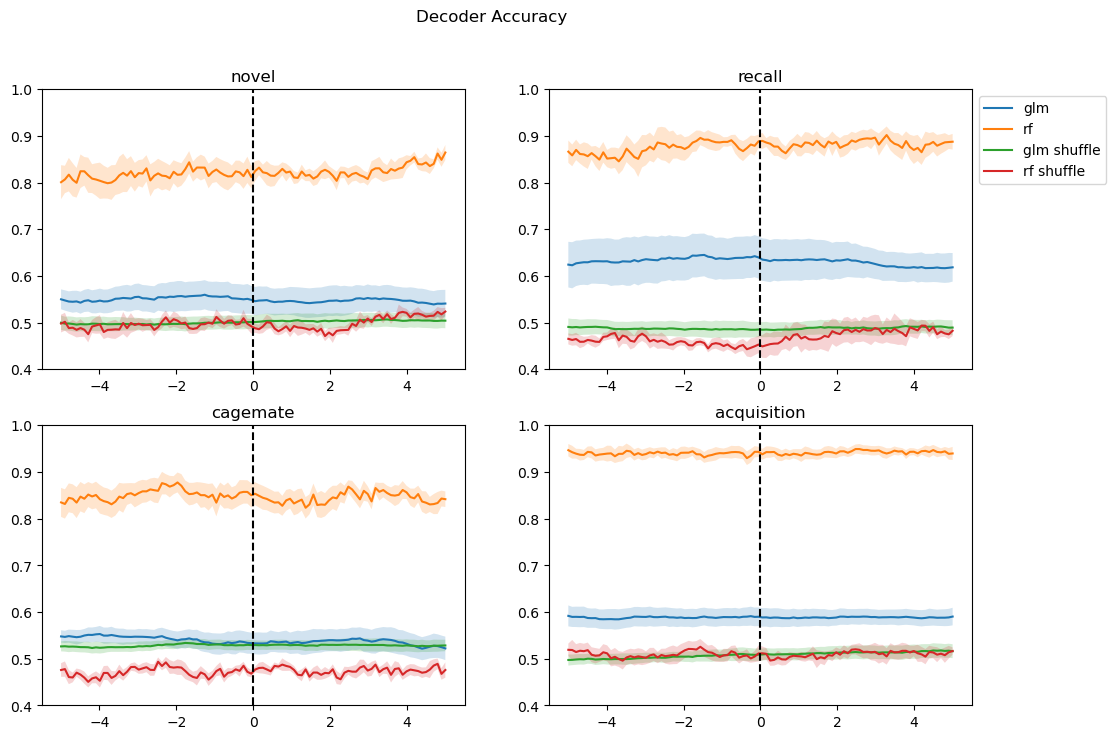

In [ ]:
minus_1pc_auc = trial_decoder(equalize = 5, pre_window = 5, post_window = 0,num_fold=5, num_shuffle=5, no_PCs= 8, events = ['novel', 'recall','cagemate', 'acquisition'])

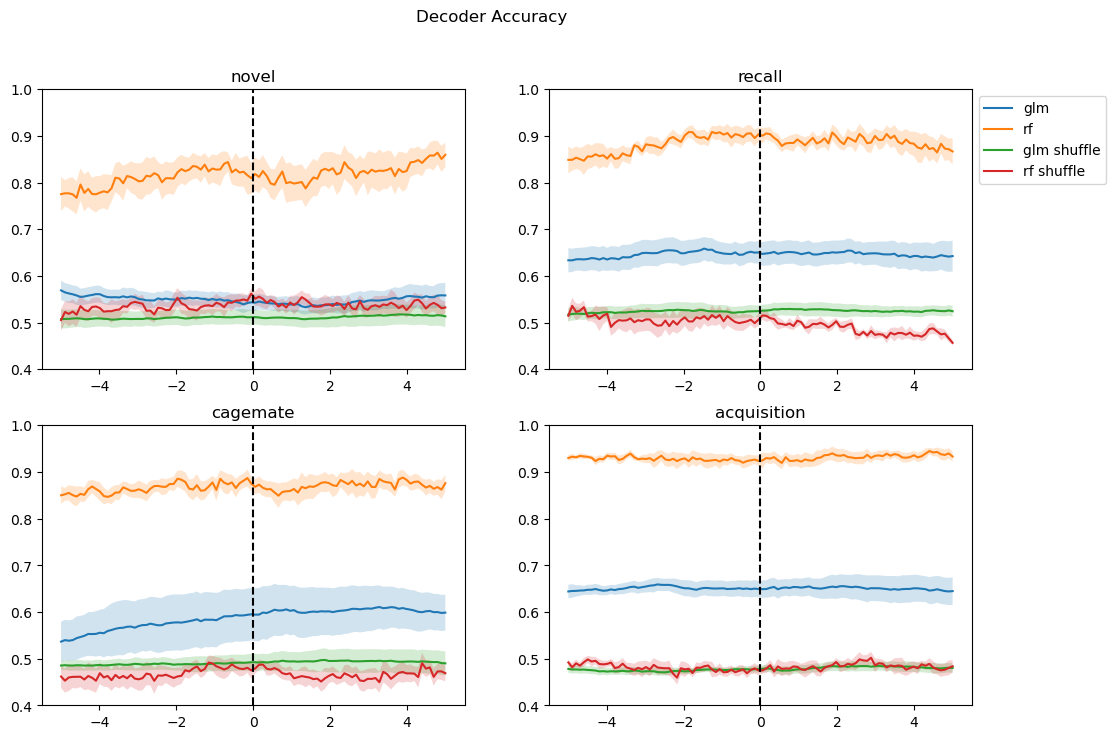

In [ ]:
allconditions_auc = phase2_analysis.trial_decoder(equalize = 5, pre_window = 5, post_window = 0,num_fold=5, num_shuffle=5, no_PCs= 8, events = ['novel', 'recall','cagemate', 'acquisition'])

### Time decoder functions



In [259]:
phase2_collection.collection.keys()

FCN = ['20230803_101331_1_merged.rec', 
'20230804_121600_1_merged.rec', 
'20230817_113746_1_merged.rec']

CNF = ['20230817_100823_1_merged.rec',
'20230803_141047_1_merged.rec',
'20230818_133620_1_merged.rec']

NFC = ['20230818_115728_1_merged.rec',
'20230804_141009_1_merged.rec',
'20230803_121318_1_merged.rec']


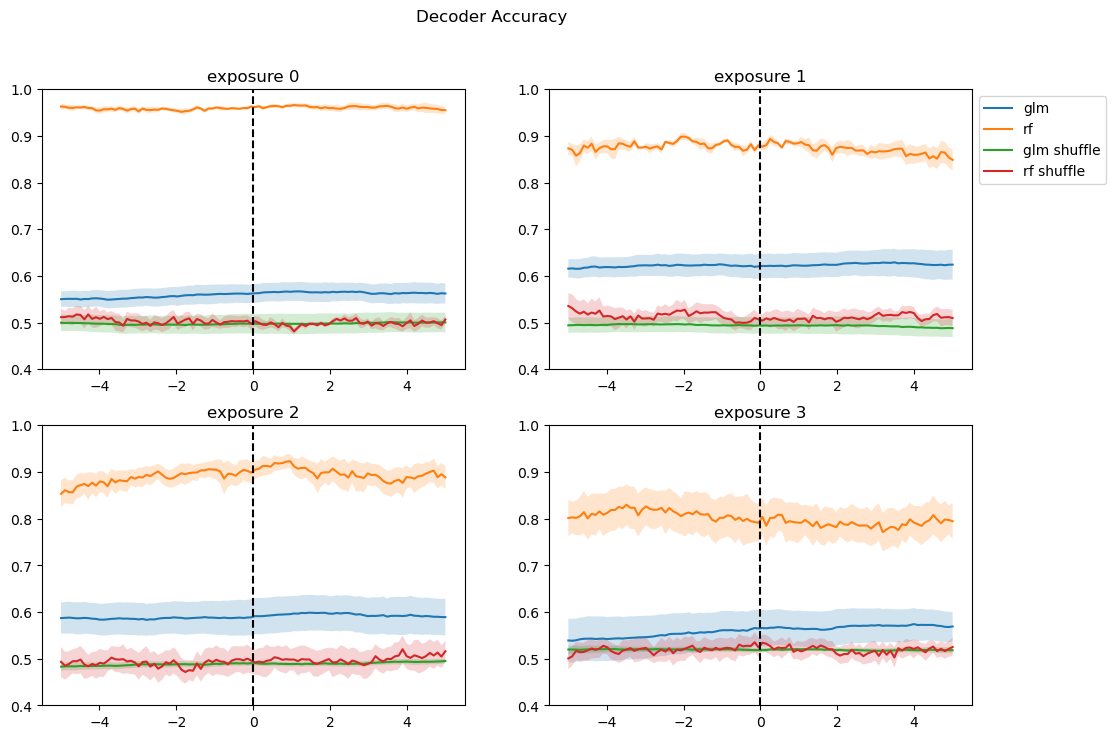

In [10]:
time_auc = phase2_analysis.trial_decoder(equalize = 5,
                                        pre_window = 5,
                                        post_window = 0,
                                        num_fold = 5,
                                        num_shuffle = 5,
                                        no_PCs = 8,
                                        events = ['exposure 0', 'exposure 1', 'exposure 2', 'exposure 3'],
                                        plot = True)

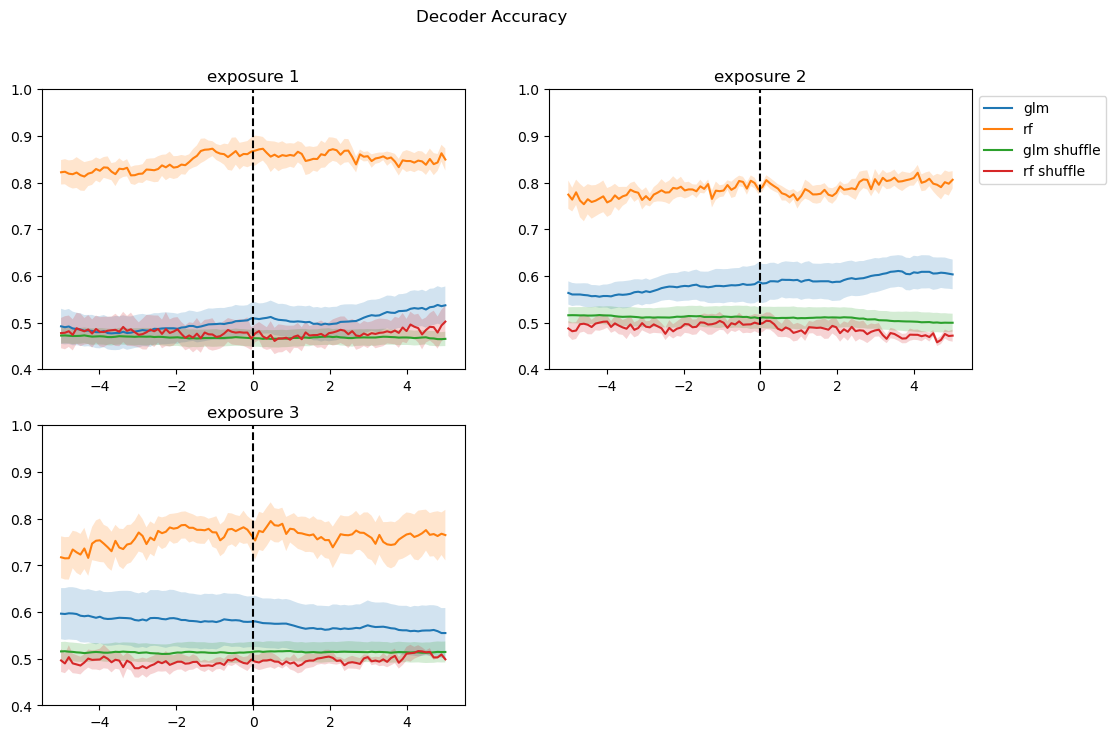

In [11]:
time_auc_no_acq = phase2_analysis.trial_decoder(equalize = 5,
                                        pre_window = 5,
                                        post_window = 0,
                                        num_fold = 5,
                                        num_shuffle = 5,
                                        no_PCs = 8,
                                        events = ['exposure 1', 'exposure 2', 'exposure 3'],
                                        plot = True)

In [12]:
# with open('time_auc.pkl','wb') as file:
#     pickle.dump(time_auc, file)

# with open('time_auc_no_acq.pkl','wb') as file:
#     pickle.dump(time_auc_no_acq, file)

In [4]:
with open('time_auc.pkl', 'rb') as file:
    time_auc = pickle.load(file)

with open('time_auc_no_acq.pkl', 'rb') as file:
    time_auc_no_acq = pickle.load(file)

In [ ]:
id_auc = phase2_analysis.trial_decoder(equalize = 5,
                                        pre_window = 5,
                                        post_window = 0,
                                        num_fold = 5,
                                        num_shuffle = 5,
                                        no_PCs = 8,
                                        events = ['acquisition', 'novel', 'recall', 'cagemate'],
                                        plot = True)

In [280]:
def __PCA_for_decoding_tagged_(equalize, pre_window, post_window, no_PCs, events, counter_events = None):
        full_PCA_matrix, t_df, key, coefficients, explained_variance_ratios = phase2_analysis.PCA_matrix_generation(equalize, pre_window, post_window, events = events)
        recordings = full_PCA_matrix.columns.to_list()
        recording_list = np.unique(recordings)
        coefficients = coefficients[:, :no_PCs]
        recording_indices = get_indices(recordings)
        decoder_data = {}
        if counter_events is not None:
            for event in counter_events:
                if event not in events:
                    events.append(event)
        #decoder data dict: events for keys, values is a list of len(events)
        #each element in the list is the transformed matrix
        for recording in recording_list:
            #iterate through recording
            start = recording_indices[recording][0]
            stop = recording_indices[recording][1]
            #trim weight matrix for only those neurons in the current recording
            subset_coeff = coefficients[start:stop+1, :]
            recording_instance = phase2_analysis.ephyscollection.get_by_name(recording)
            recording_data = {}
            for event in events:
                #grab all event firing rates for current event in current recording
                event_firing_rates = phase2_analysis.__get_event_firing_rates__(recording_instance, event,
                                                                equalize, pre_window, post_window)
                for trial in range(len(event_firing_rates)):
                    #iterate through each event
                    trial_data = np.transpose(event_firing_rates[trial])
                    #transpoe event firing rates from neurons x timebins to timebins x neurons
                    transformed_trial = np.dot(trial_data, subset_coeff)
                    #transform each trial with original weight matrix
                    #T (timebins x pcs) = D (timebins x neurons). W (pcs x neurons) 
                    if event in recording_data.keys():
                        #append transformed matrix to decoder_data1 dict
                        recording_data[event].append(transformed_trial)
                    else: 
                        recording_data[event] = []
                        recording_data[event].append(transformed_trial)
            decoder_data[recording] = recording_data
        return decoder_data



def make_training_data(group_a, group_b, group_c, events, test_event, equalize, pre_window, post_window, no_PCs, num_fold, num_shuffle, plot=True):
    decoder_data = __PCA_for_decoding_tagged_(equalize, pre_window, post_window, no_PCs, events)
    ex_trial_matrix = decoder_data[group_a[0]][events[0]][0]
    T = ex_trial_matrix.shape[0]
    auc = {}  
    groups = ['group_a', 'group_b', 'group_c']
    group_dict = {'group_a': group_a, 'group_b': group_b, 'group_c':group_c}
    for group in groups:
        data_neg_test = []
        data_pos_test = []
        data_neg_train = []
        data_pos_train = []
        for recording in group_dict[group]:
            data = decoder_data[recording]
            for event in events:
                if event == test_event:
                    for trial in data[event]:
                        data_pos_test.append(trial)
                else:
                    for trial in data[event]:
                        data_neg_test.append(trial)
        data_pos_test = np.stack(data_pos_test, axis=2)
        data_neg_test = np.stack(data_neg_test, axis=2)
        num_pos_test = data_pos_test.shape[2]
        num_neg_test = data_neg_test.shape[2]
        for train_group in np.setdiff1d(groups, group):
            for recording in group_dict[train_group]:
                data = decoder_data[recording]
                for event in events:
                    if event == test_event:
                        for trial in data[event]:
                            data_pos_train.append(trial)
                    else:
                        for trial in data[event]:
                            data_neg_train.append(trial)
        data_pos_train = np.stack(data_pos_train, axis=2)
        data_neg_train = np.stack(data_neg_train, axis=2)
        num_pos_train = data_pos_train.shape[2]
        num_neg_train = data_neg_train.shape[2]
        print('training set:', num_neg_train, num_pos_train, num_neg_train/num_pos_train)
        print('testing set:', num_neg_test, num_pos_test, num_neg_test/num_pos_test)
        data_pos_train = data_pos_train[:, :, np.random.permutation(num_pos_train)]
        data_pos_test = data_pos_test[:, :, np.random.permutation(num_pos_test)]
        data_neg_train = data_neg_train[:, :, np.random.permutation(num_neg_train)]
        data_neg_test = data_neg_test[:, :, np.random.permutation(num_neg_test)]
        auc[group] = {'glm': [], 'rf': [], 'glm_shuffle': [], 'rf_shuffle': []}
        for fold in range(num_fold):
            auc_glm = []
            auc_rf = []
            auc_glm_shuffle = []
            auc_rf_shuffle = []
            pos_fold_test = num_pos_test // num_fold
            pos_fold_train = num_pos_train //num_fold
            neg_fold_train = num_neg_train // num_fold
            neg_fold_test = num_neg_test // num_fold
            data_test = np.concatenate((data_pos_test[:, :, fold * pos_fold_test:(fold + 1) * pos_fold_test],
                                        data_neg_test[:, :, fold * neg_fold_test:(fold + 1) * neg_fold_test]), axis=2)
            #here B is pos and c is neg
            label_test = np.concatenate((np.ones((fold + 1) * pos_fold_test - fold * pos_fold_test),
                                        np.zeros((fold + 1) * neg_fold_test - fold * neg_fold_test)))
            #so here i want A to be pos and b to neg  
            data_train = np.concatenate((
                data_pos_train[:, :, np.setdiff1d(np.arange(num_pos_train), 
                np.arange(fold * pos_fold_train, (fold + 1) * pos_fold_train))],
                data_neg_train[:, :, np.setdiff1d(np.arange(num_neg_train), 
                np.arange(fold * neg_fold_train, (fold + 1) * neg_fold_train))]),
                axis=2)
            label_train = np.concatenate((np.ones(num_pos_train - (fold + 1) * pos_fold_train + fold * pos_fold_train),
                                        np.zeros(num_neg_train - (fold + 1) * neg_fold_train + fold * neg_fold_train)))
            for timebin in range(T):
                model_glm = LogisticRegression(class_weight='balanced')
                model_glm.fit(data_train[timebin, :, :].T, label_train)
                pred_glm = model_glm.predict_proba(data_test[timebin, :, :].T)
                auc_glm.append(roc_auc_score(label_test, pred_glm[:, 1]))
                
                model_rf = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight = 'balanced'), n_estimators=50, random_state=0)
                model_rf.fit(data_train[timebin, :, :].T, label_train)
                pred_rf = model_rf.predict_proba(data_test[timebin, :, :].T)
                auc_rf.append(roc_auc_score(label_test, pred_rf[:, 1]))
            auc[group]['glm'].append(auc_glm)
            auc[group]['rf'].append(auc_rf)
            for shuffle in range(num_shuffle):
                temp_glm_shuffle = []
                temp_rf_shuffle = []
                label_train = np.random.permutation(label_train)
                for timebin in range(T):
                    model_glm = LogisticRegression(class_weight='balanced')
                    model_glm.fit(data_train[timebin, :, :].T, label_train)
                    pred_glm = model_glm.predict_proba(data_test[timebin, :, :].T)
                    temp_glm_shuffle.append(roc_auc_score(label_test, pred_glm[:, 1]))

                    model_rf = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight = 'balanced'), n_estimators=50, random_state=0)
                    model_rf.fit(data_train[timebin, :, :].T, label_train)
                    pred_rf = model_rf.predict_proba(data_test[timebin, :, :].T)
                    temp_rf_shuffle.append(roc_auc_score(label_test, pred_rf[:, 1]))
                auc_glm_shuffle.append(temp_glm_shuffle)
                auc_rf_shuffle.append(temp_rf_shuffle)
            auc[group]['glm_shuffle'].append(auc_glm_shuffle)
            auc[group]['rf_shuffle'].append(auc_rf_shuffle)
    if plot:
        __plot_auc__(auc, equalize, pre_window)
    return auc
            



training set: 117 58 2.0172413793103448
testing set: 48 28 1.7142857142857142
training set: 95 50 1.9
testing set: 70 36 1.9444444444444444
training set: 118 64 1.84375
testing set: 47 22 2.1363636363636362


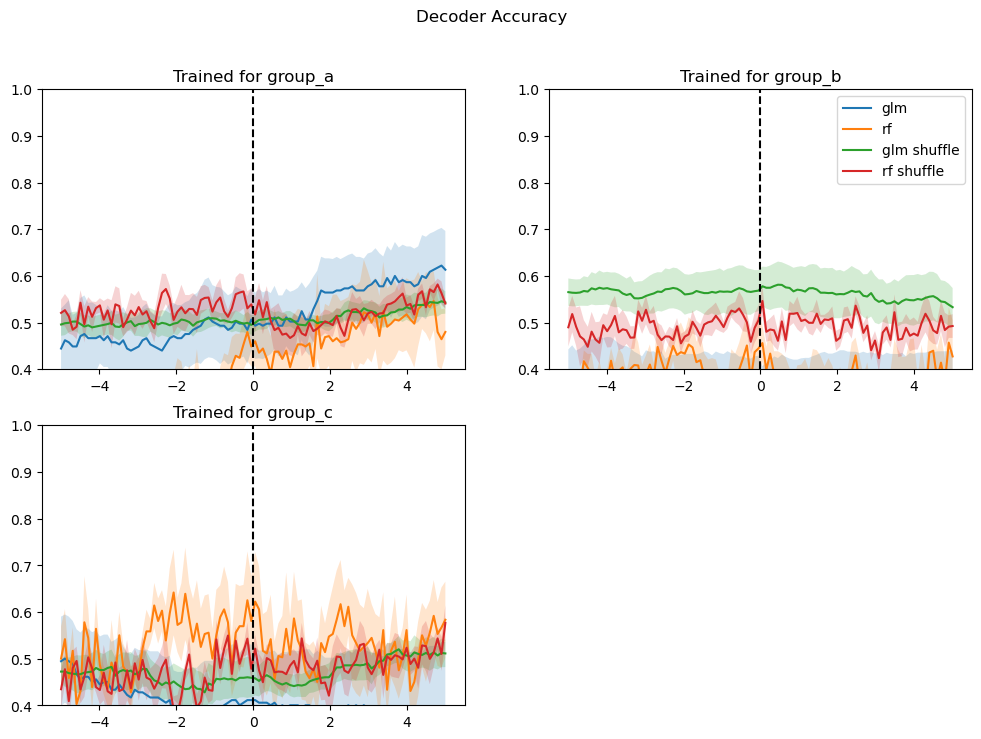

In [281]:
tester = make_training_data(FCN, CNF, NFC, events = ['cagemate', 'novel', 'recall'], 
                            test_event = 'cagemate', equalize = 5, pre_window = 5, post_window = 0, no_PCs= 8, num_fold = 5, num_shuffle= 5)


training set: 116 59 1.9661016949152543
testing set: 50 26 1.9230769230769231
training set: 94 51 1.8431372549019607
testing set: 72 34 2.1176470588235294
training set: 122 60 2.033333333333333
testing set: 44 25 1.76


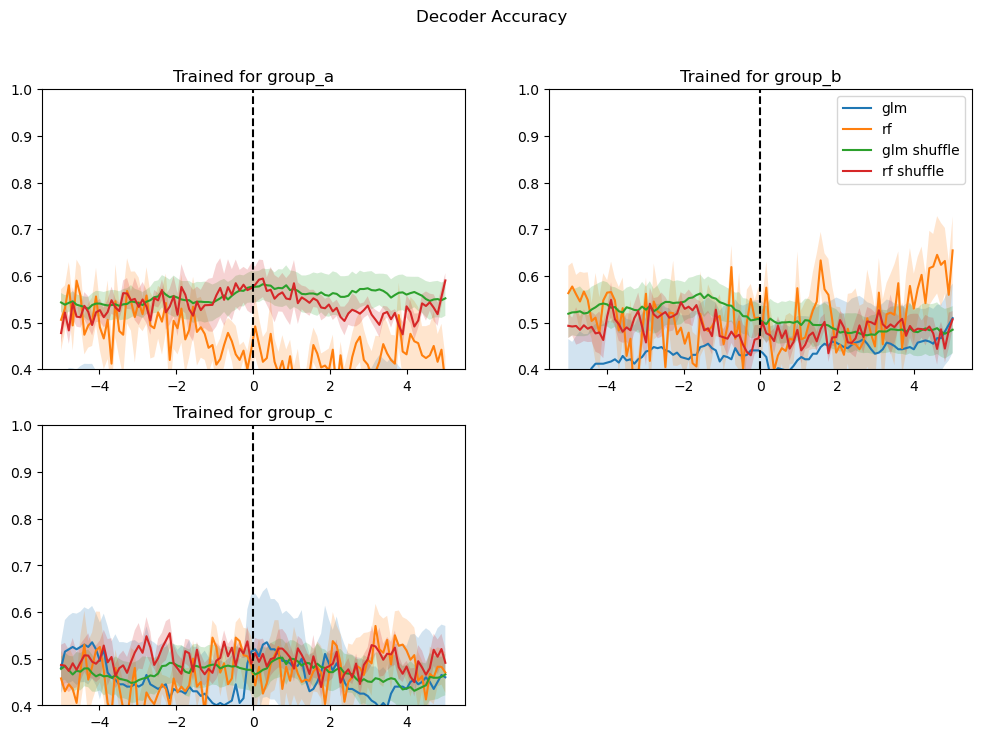

In [282]:
novel_time = make_training_data(FCN, CNF, NFC, events = ['cagemate', 'novel', 'recall'], 
                            test_event = 'novel', equalize = 5, pre_window = 5, post_window = 0, no_PCs= 8, num_fold = 5, num_shuffle= 5)

training set: 117 58 2.0172413793103448
testing set: 54 22 2.4545454545454546
training set: 101 44 2.2954545454545454
testing set: 70 36 1.9444444444444444
training set: 124 58 2.1379310344827585
testing set: 47 22 2.1363636363636362


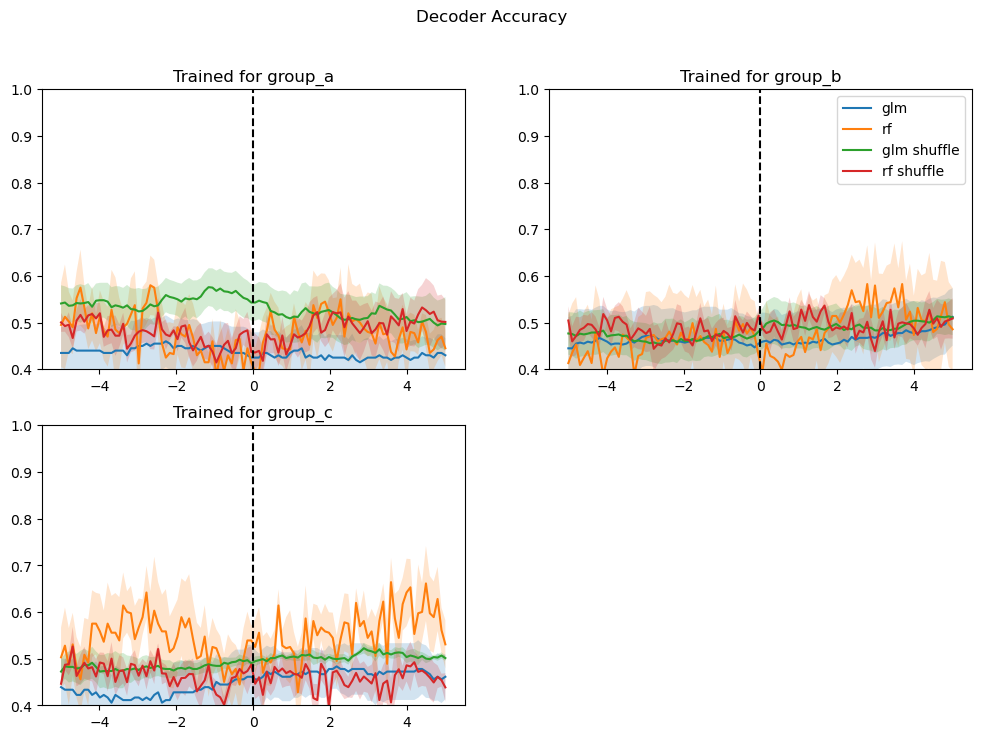

In [283]:
recall_time = make_training_data(FCN, CNF, NFC, events = ['cagemate', 'novel', 'recall'], 
                            test_event = 'recall', equalize = 5, pre_window = 5, post_window = 0, no_PCs= 8, num_fold = 5, num_shuffle= 5)